In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score,recall_score
import optuna
import warnings


In [3]:
def compute_costs(LoanAmount):
     return({'Risk_No Risk': 5.0 + .6 * LoanAmount, 'No Risk_No Risk': 1.0 - .05 * LoanAmount,
         'Risk_Risk': 1.0, 'No Risk_Risk': 1.0})
def score(solution: pd.DataFrame, submission: pd.DataFrame) -> float:
   '''
   A custom metric for the German credit dataset
   '''
   real_prop = {'Risk': .02, 'No Risk': .98}
   train_prop = {'Risk': 1/3, 'No Risk': 2/3}
   custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}
   costs = compute_costs(solution['LoanAmount'])
   y_true = solution['Risk']    
   y_pred = submission['Risk']
   loss = (y_true=='Risk') * custom_weight['Risk'] *\
               ((y_pred=='Risk') * costs['Risk_Risk'] + (y_pred=='No Risk') * costs['Risk_No Risk']) +\
            (y_true=='No Risk') * custom_weight['No Risk'] *\
               ((y_pred=='Risk') * costs['No Risk_Risk'] + (y_pred=='No Risk') * costs['No Risk_No Risk'])
   return loss.mean()


In [5]:
train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')
train_df.head(20)
 # no duplicates # no missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   CheckingStatus            3999 non-null   object
 1   LoanDuration              3999 non-null   int64 
 2   CreditHistory             3999 non-null   object
 3   LoanPurpose               3999 non-null   object
 4   LoanAmount                3999 non-null   int64 
 5   ExistingSavings           3999 non-null   object
 6   EmploymentDuration        3999 non-null   object
 7   InstallmentPercent        3999 non-null   int64 
 8   Sex                       3999 non-null   object
 9   OthersOnLoan              3999 non-null   object
 10  CurrentResidenceDuration  3999 non-null   int64 
 11  OwnsProperty              3999 non-null   object
 12  Age                       3999 non-null   int64 
 13  InstallmentPlans          3999 non-null   object
 14  Housing                 

In [6]:
import pandas as pd

# Charger les données
# df = pd.read_csv('path_to_your_file.csv')  # Décommentez cette ligne si vous avez un fichier CSV

# Liste des variables catégorielles
categorical_columns = train_df.select_dtypes(include=['object']).columns

# Afficher les modalités pour chaque variable catégorielle
for col in categorical_columns:
    print(f"Modalities of {col}:")
    print(train_df[col].unique())
    print("-" * 50)


Modalities of CheckingStatus:
['0_to_200' 'less_0' 'no_checking' 'greater_200']
--------------------------------------------------
Modalities of CreditHistory:
['credits_paid_to_date' 'prior_payments_delayed' 'outstanding_credit'
 'all_credits_paid_back' 'no_credits']
--------------------------------------------------
Modalities of LoanPurpose:
['other' 'car_new' 'furniture' 'retraining' 'education' 'vacation'
 'appliances' 'car_used' 'radio_tv' 'repairs' 'business']
--------------------------------------------------
Modalities of ExistingSavings:
['100_to_500' 'less_100' '500_to_1000' 'unknown' 'greater_1000']
--------------------------------------------------
Modalities of EmploymentDuration:
['less_1' '1_to_4' 'greater_7' '4_to_7' 'unemployed']
--------------------------------------------------
Modalities of Sex:
['female' 'male']
--------------------------------------------------
Modalities of OthersOnLoan:
['none' 'co-applicant' 'guarantor']
---------------------------------------

In [7]:
# CheckingStatus : 1) semble utile OHE 4 variables 2) réfléchir aux interactions notamment avec Loan Amount 2) class imbalanced few >200
# Loan Duration : 1) Significatif variable quantitative à inclure 2) réfléchir à spliter en bins par année
# CreditHistory : 1) Variable à oneHotEncoder car semble très importante 2) class unbalanced very few no credits
# LoanPurpose :  1) Variable qui semble significative, réfléchir à la OHE car 8 variables 2) categories imbalanced
# LoanAmount : 1) Variable quantitative à inclure car + elle augmente plus la proportion de risque est importante 2) essayer de spliter en catégories
# ExistingSavings : 1) Variable à OHE regrouper 500_to_100 et greater_1000 en une seule cat donc 3 cat
# EmploymentDuration : 1) significatif OHE 2) peut etre grouper unemployed and less than 1
# InstallmentPercent : 1) variable uantitative significative
# Sex : 1) Do not include does not help much 2) try to include
# OthersOnLoan : 1) Utile mais fusionner les modalités guarantor et co-applicant, donc transformer en variable booléenne valant 0 si valait avant "none" et 1 si valait avant "guarantor" ou "co-applicant"
# CurrentResidenceDuration : 1) Inclure mais remplacer tous les 6 par des 5     2) Relation inverse à ce qui semblerait logique donc essayer de supprimer
# Owns Property : 1) Significatif à inclure OHE, 4 nouvelles caté
# Age : 1) variable quantitative à garder
# InstallmentPlans : 1) Utile OHE 3 variables 2) Utile mais fusionner les modalités bank et stores, donc transformer en variable booléenne valant 0 si valait avant "none" et 1 si valait avant "bank" ou "stores"
# Housing : 1) Utile OHE trois nouvelles variables
# ExistingCreditsCount : 1) seulement 3 valeurs int 1, 2 ,3 -> convertir en variable catégorielle et OHE donc 3 novuelles variables
# Job : 1) Utile mais fusionner modalités "unemployed" et "unskilled", ensuite OHE donc trois variables
# Dependents : 1) Significatif mais convertir en category puis OHE 2 variables
# Telephone : 1) Significatif créer une booléenne qui vaut 1 quand yes et 0 quand none 2) essayer de drop car pas logique
# ForeignWorker : 1) Do not include does not help much

# A ajouter / feature engineering 

# Ajouter Age at loan end selon la formule train_df['Age_at_loan_end'] = (train_df['Age'] + (train_df['LoanDuration'] / 12)).round().astype(int)
# Crééer une variable loanamountpermont égale à loanamount /loan duration puis crééer ces bins 0 à 99 une de 100 à 399 une de 400 à 799 une de 800 à 1099 et une de 1100 + mais transformer en category et faire un OHE


# EDA

## General

In [8]:
profile = ProfileReport(train_df, explorative=True)
# Ou sauvegarder en HTML
profile.to_file("EDA_report.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:00<00:00, 306.13it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

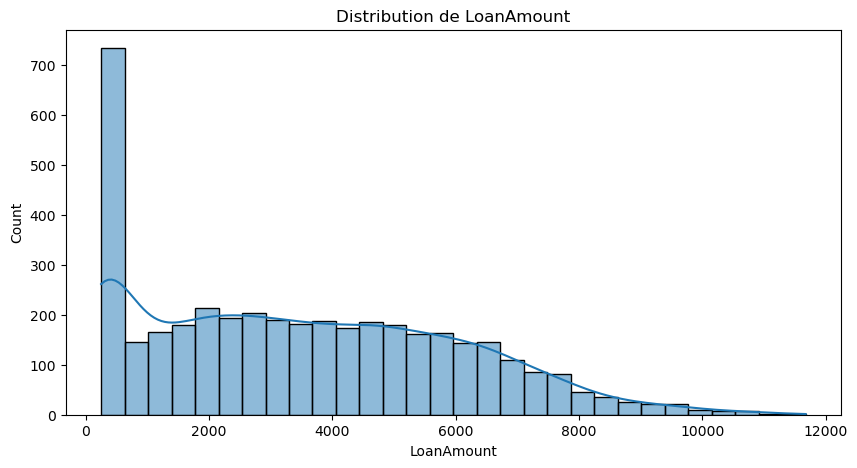

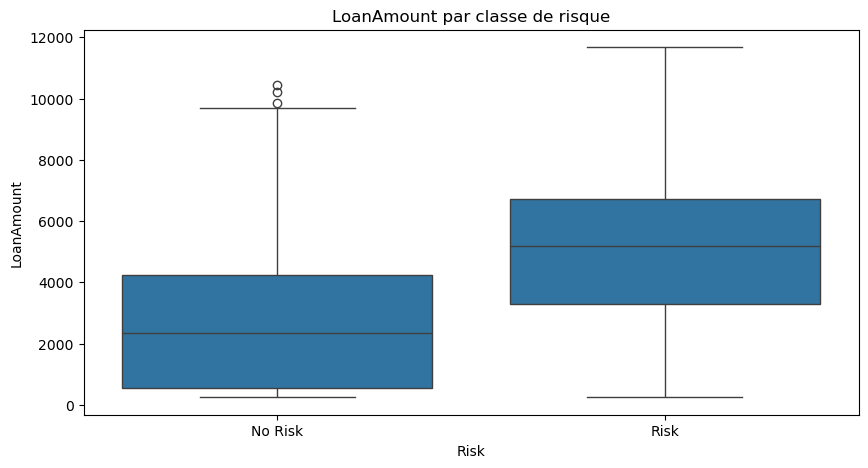

In [9]:

# Distribution du montant du prêt
plt.figure(figsize=(10,5))
sns.histplot(train_df['LoanAmount'], bins=30, kde=True)
plt.title("Distribution de LoanAmount")
plt.show()


plt.figure(figsize=(10,5))
sns.boxplot(x=train_df['Risk'], y=train_df['LoanAmount'])
plt.title("LoanAmount par classe de risque")
plt.show()


Loan amount varie énormément -> il faut le prendre en compte pour la prédiction de chaque point vu qu'il est dans la formule de perte

On voit que les prêts à risque sont généralement plus important.

## Loan amount

Risk
No Risk    0.667417
Risk       0.332583
Name: proportion, dtype: float64


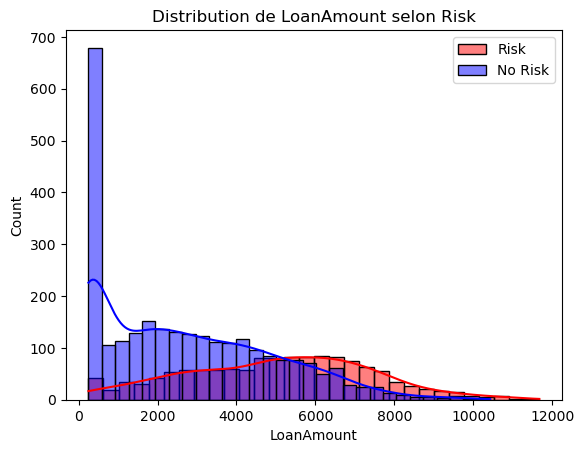

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/4038971818.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_risk_percent = train_df.groupby("LoanAmount_Bin")["Risk"].value_counts(normalize=True).unstack() * 100


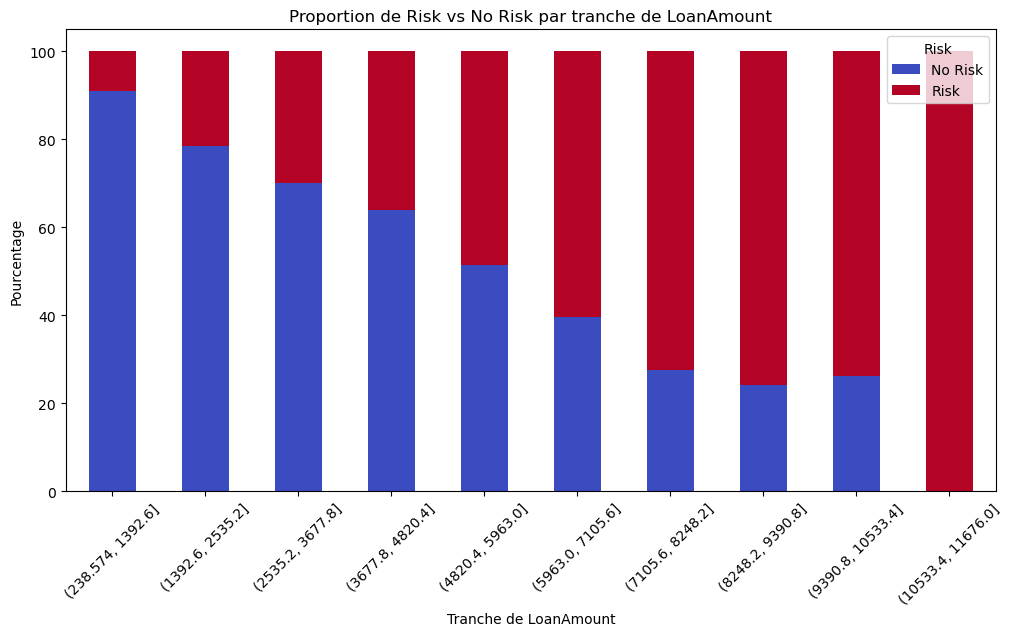

In [10]:

print(train_df['Risk'].value_counts(normalize=True))  # Pourcentage de chaque classe
sns.histplot(train_df[train_df['Risk'] == "Risk"]['LoanAmount'], color="red", label="Risk", kde=True, bins=30)
sns.histplot(train_df[train_df['Risk'] == "No Risk"]['LoanAmount'], color="blue", label="No Risk", kde=True, bins=30)
plt.legend()
plt.title("Distribution de LoanAmount selon Risk")
plt.show()

train_df["LoanAmount_Bin"] = pd.cut(train_df["LoanAmount"], bins=10)  # 10 tranches égales

# Calculer le pourcentage de Risk et No Risk par tranche
loan_risk_percent = train_df.groupby("LoanAmount_Bin")["Risk"].value_counts(normalize=True).unstack() * 100

# Tracer le barplot empilé
loan_risk_percent.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion de Risk vs No Risk par tranche de LoanAmount")
plt.xlabel("Tranche de LoanAmount")
plt.ylabel("Pourcentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


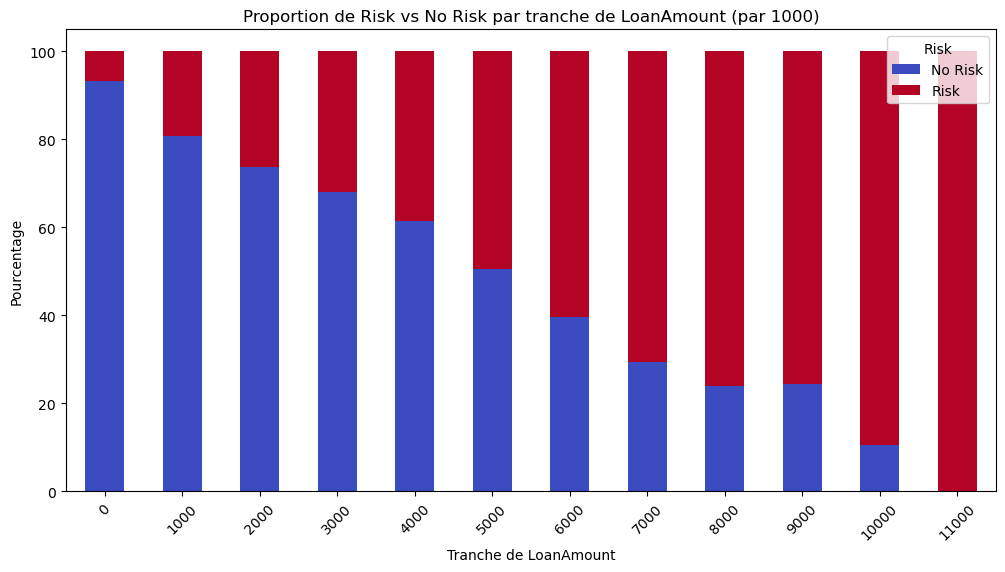

In [11]:
# Créer une nouvelle colonne pour regrouper les montants des prêts par tranches de 1000
train_df["LoanAmount_Bin"] = (train_df["LoanAmount"] // 1000) * 1000

# Calculer la proportion de risque par tranche de prêt
loan_risk_percent = train_df.groupby("LoanAmount_Bin")["Risk"].value_counts(normalize=True).unstack() * 100

# Tracer le barplot empilé
loan_risk_percent.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion de Risk vs No Risk par tranche de LoanAmount (par 1000)")
plt.xlabel("Tranche de LoanAmount")
plt.ylabel("Pourcentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


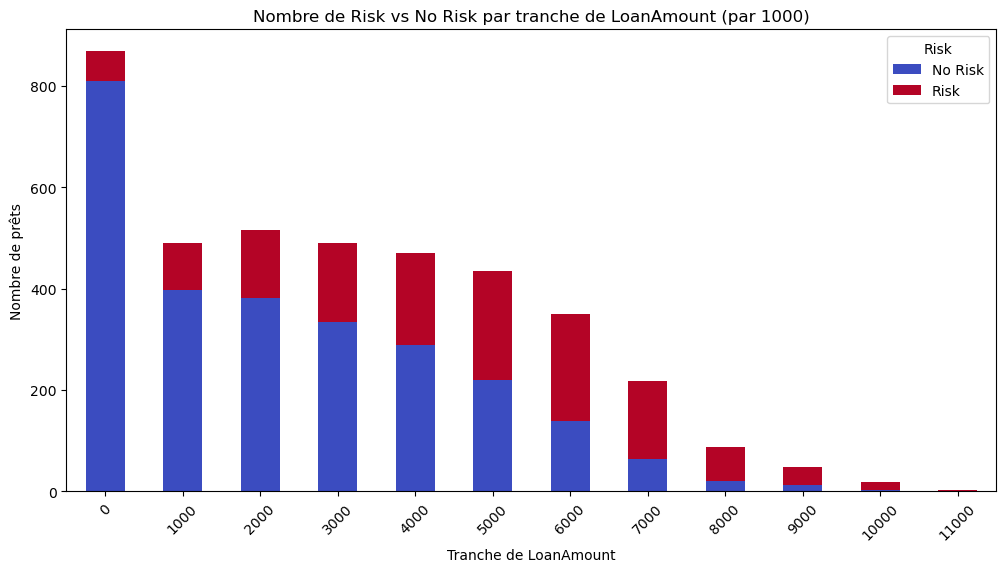

In [12]:
# Créer une nouvelle colonne pour regrouper les montants des prêts par tranches de 1000
train_df["LoanAmount_Bin"] = (train_df["LoanAmount"] // 1000) * 1000

# Compter le nombre de risques par tranche de prêt
loan_risk_count = train_df.groupby("LoanAmount_Bin")["Risk"].value_counts().unstack()

# Tracer le barplot empilé
loan_risk_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Nombre de Risk vs No Risk par tranche de LoanAmount (par 1000)")
plt.xlabel("Tranche de LoanAmount")
plt.ylabel("Nombre de prêts")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()

Logiuement, plus le loan augmente plus les prêts sont considérés risqués

Outliers selon IQR (n = 1):
       LoanAmount
count         1.0
mean      11676.0
std           NaN
min       11676.0
25%       11676.0
50%       11676.0
75%       11676.0
max       11676.0
Outliers selon les scores Z (n = 3):
         LoanAmount
count      3.000000
mean   11432.000000
std      218.604666
min    11254.000000
25%    11310.000000
50%    11366.000000
75%    11521.000000
max    11676.000000


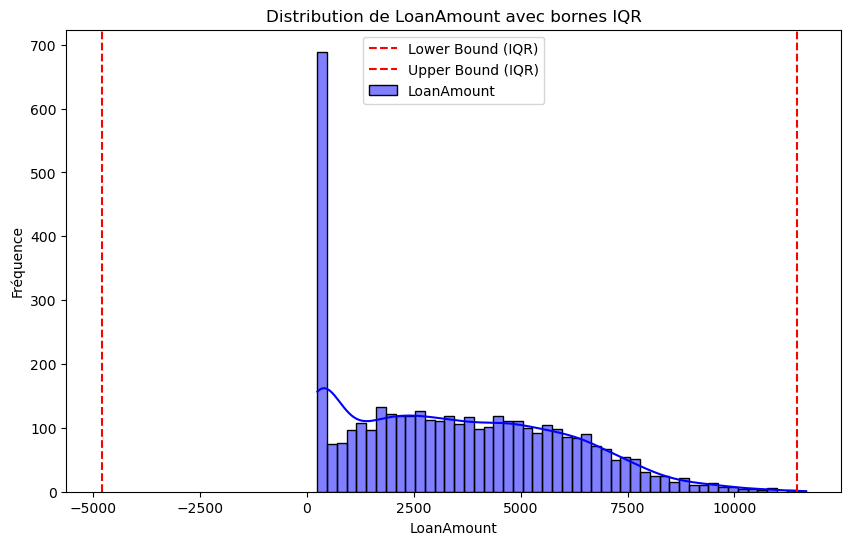

In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Méthode IQR (Interquartile Range)
Q1 = train_df['LoanAmount'].quantile(0.25)
Q3 = train_df['LoanAmount'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrer les outliers en utilisant IQR
outliers_iqr = train_df[(train_df['LoanAmount'] < lower_bound) | (train_df['LoanAmount'] > upper_bound)]

print(f"Outliers selon IQR (n = {len(outliers_iqr)}):")
print(outliers_iqr[['LoanAmount']].describe())

# 2️⃣ Méthode des scores Z
from scipy import stats
z_scores = np.abs(stats.zscore(train_df['LoanAmount']))

# Définir un seuil pour les outliers (par exemple, un Z-score supérieur à 3)
outliers_zscore = train_df[z_scores > 3]

print(f"Outliers selon les scores Z (n = {len(outliers_zscore)}):")
print(outliers_zscore[['LoanAmount']].describe())

# 3️⃣ Visualisation des outliers
plt.figure(figsize=(10, 6))

# Histogramme de LoanAmount
sns.histplot(train_df['LoanAmount'], bins=50, kde=True, color='blue', label='LoanAmount')
plt.axvline(lower_bound, color='r', linestyle='--', label="Lower Bound (IQR)")
plt.axvline(upper_bound, color='r', linestyle='--', label="Upper Bound (IQR)")

plt.title('Distribution de LoanAmount avec bornes IQR')
plt.xlabel('LoanAmount')
plt.ylabel('Fréquence')
plt.legend()
plt.show()


Pas d'outlier

## Credit History

CreditHistory
prior_payments_delayed    1355
credits_paid_to_date      1182
outstanding_credit         745
all_credits_paid_back      617
no_credits                 100
Name: count, dtype: int64


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/2358086904.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='CreditHistory', palette='viridis')


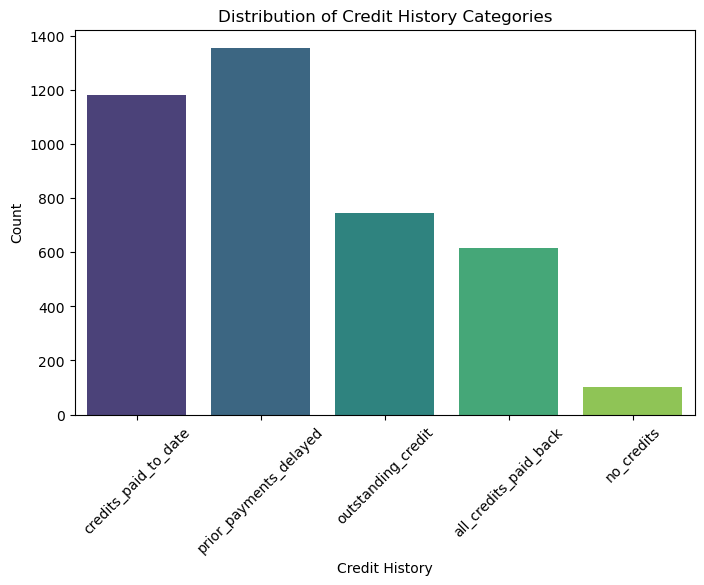

In [14]:
# Count the number of values in each category of CreditHistory
credit_history_counts = train_df['CreditHistory'].value_counts()

# Print the result
print(credit_history_counts)

# Visualize the distribution of CreditHistory categories
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='CreditHistory', palette='viridis')
plt.title('Distribution of Credit History Categories')
plt.xlabel('Credit History')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


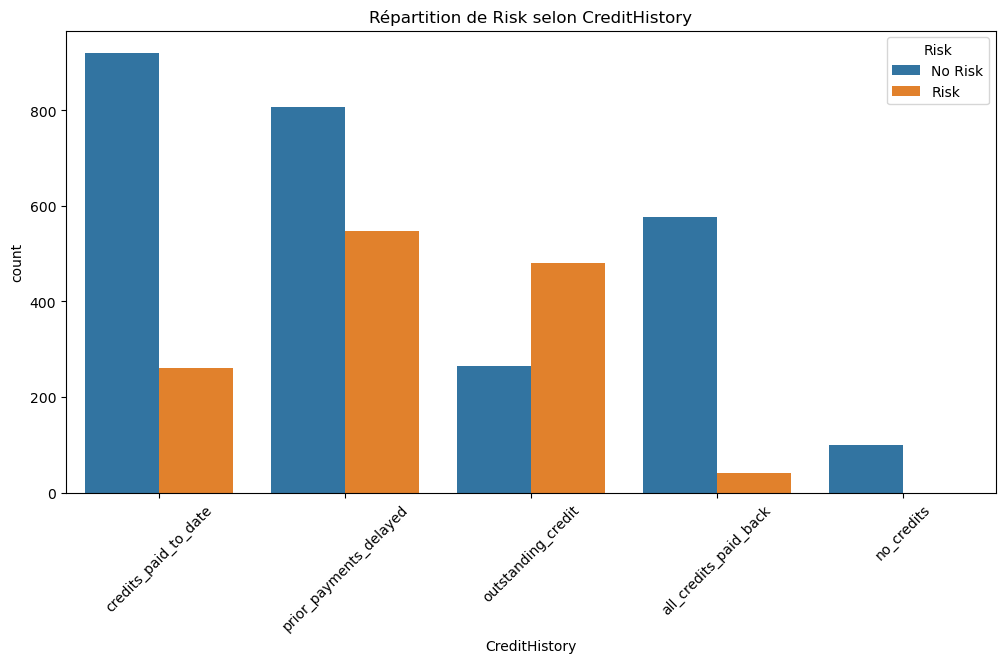

CreditHistory           Risk   
all_credits_paid_back   No Risk    0.935170
                        Risk       0.064830
credits_paid_to_date    No Risk    0.779188
                        Risk       0.220812
no_credits              No Risk    1.000000
outstanding_credit      Risk       0.645638
                        No Risk    0.354362
prior_payments_delayed  No Risk    0.595572
                        Risk       0.404428
Name: proportion, dtype: float64

In [15]:
# Vérifier l'influence de CreditHistory
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='CreditHistory', hue='Risk')
plt.title("Répartition de Risk selon CreditHistory")
plt.xticks(rotation=45)
plt.show()

# Taux de Risk par catégorie
train_df.groupby("CreditHistory")["Risk"].value_counts(normalize=True)


Répartition Différentes selon la credit History donc conserver

## Loan Purpose

LoanPurpose
car_new       769
furniture     688
car_used      640
radio_tv      601
appliances    446
repairs       219
vacation      164
retraining    132
education     131
business      118
other          91
Name: count, dtype: int64


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/79530092.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='LoanPurpose', palette='viridis')


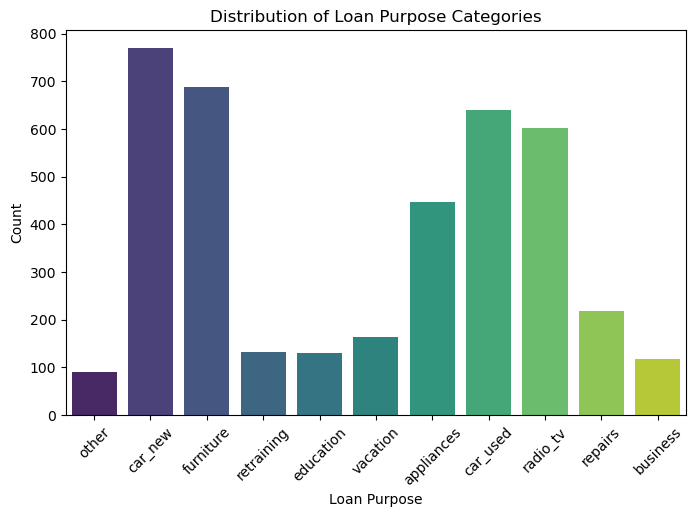

In [16]:
# Count the number of values in each category of LoanPurpose
loan_purpose_counts = train_df['LoanPurpose'].value_counts()

# Print the result
print(loan_purpose_counts)

# Visualize the distribution of LoanPurpose categories
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='LoanPurpose', palette='viridis')
plt.title('Distribution of Loan Purpose Categories')
plt.xlabel('Loan Purpose')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


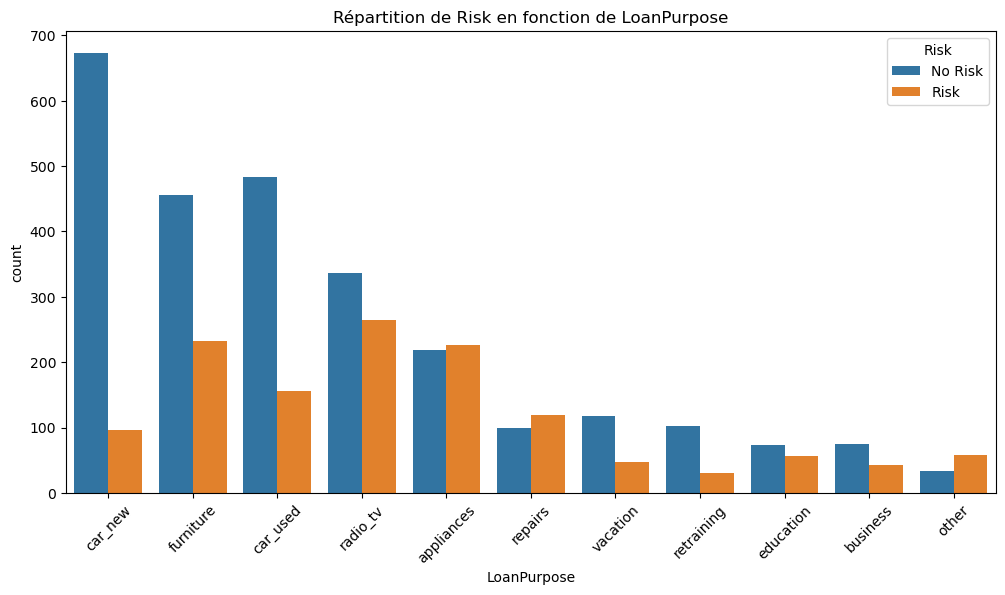

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x="LoanPurpose", hue="Risk", order=train_df["LoanPurpose"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Répartition de Risk en fonction de LoanPurpose")
plt.show()

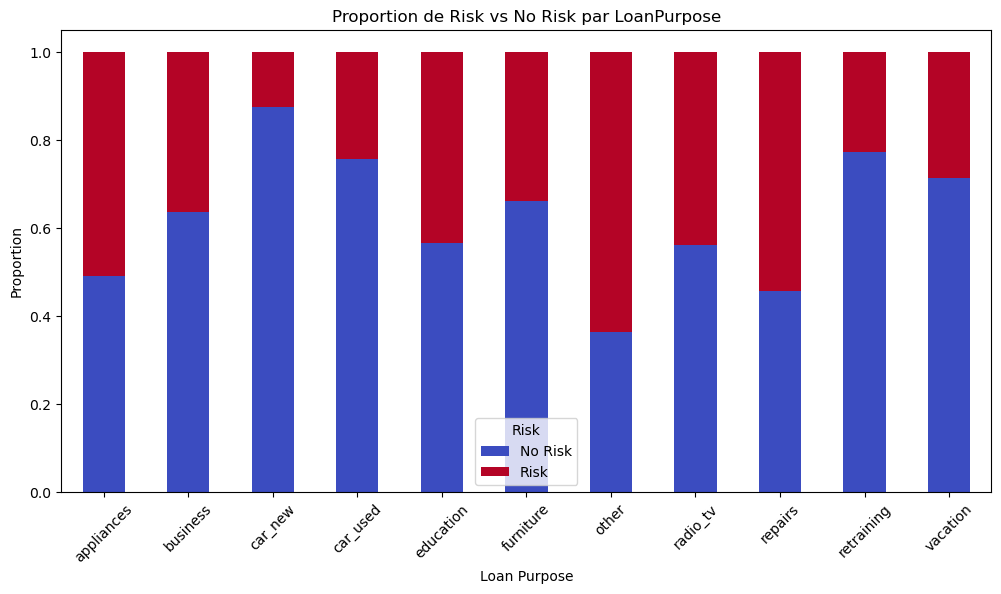

In [18]:
loan_risk_counts = train_df.groupby("LoanPurpose")["Risk"].value_counts(normalize=True).unstack()

loan_risk_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion de Risk vs No Risk par LoanPurpose")
plt.xlabel("Loan Purpose")
plt.ylabel("Proportion")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


Différences de ratio significatives visibles.

## CheckingStatus

CheckingStatus
no_checking    1590
less_0         1127
0_to_200       1036
greater_200     246
Name: count, dtype: int64


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/3920502717.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x='CheckingStatus', palette='viridis')


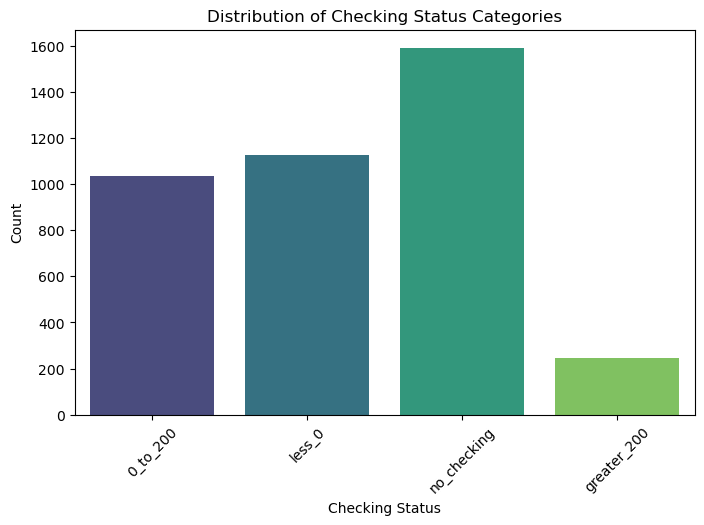

In [19]:
# Count the number of values in each category of CheckingStatus
checking_status_counts = train_df['CheckingStatus'].value_counts()

# Print the result
print(checking_status_counts)

# Visualize the distribution of CheckingStatus categories
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x='CheckingStatus', palette='viridis')
plt.title('Distribution of Checking Status Categories')
plt.xlabel('Checking Status')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


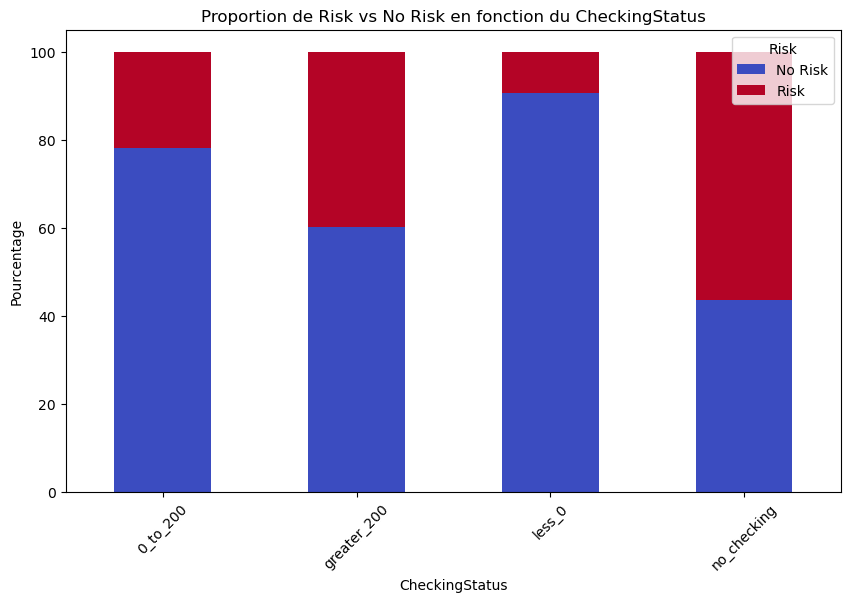

In [20]:
# Calcul de la proportion de Risk et No Risk par CheckingStatus
checking_risk_percent = train_df.groupby("CheckingStatus")["Risk"].value_counts(normalize=True).unstack() * 100

# Tracer le barplot empilé
checking_risk_percent.plot(kind="bar", stacked=True, figsize=(10, 6), colormap="coolwarm")

# Ajout des titres et labels
plt.title("Proportion de Risk vs No Risk en fonction du CheckingStatus")
plt.xlabel("CheckingStatus")
plt.ylabel("Pourcentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()

CheckingStatus
less_0         1465.656610
0_to_200       2666.769305
greater_200    3994.792683
no_checking    5364.801258
Name: LoanAmount, dtype: float64


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/1199524983.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=train_df, x="CheckingStatus", y="LoanAmount", order=avg_loan.index, palette="coolwarm")


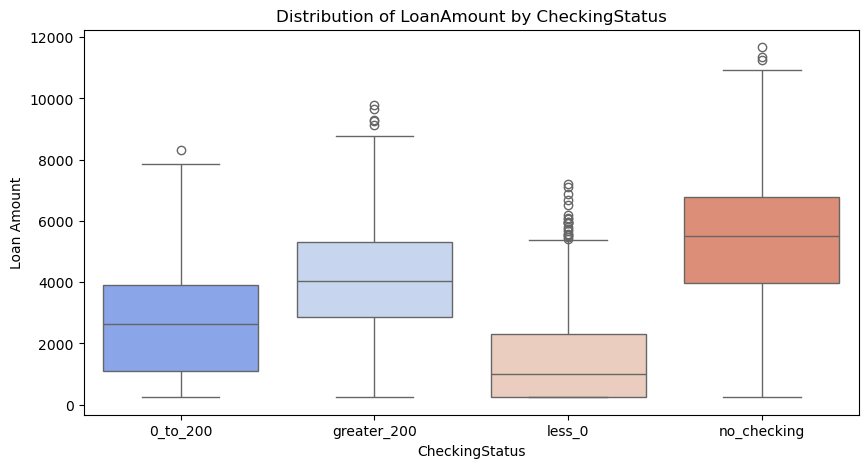

In [21]:
# 1️⃣ Check the average loan amount per CheckingStatus
avg_loan = train_df.groupby("CheckingStatus")["LoanAmount"].mean()
print(avg_loan.sort_values())  # Sorting to see the trend

# 2️⃣ Boxplot of LoanAmount by CheckingStatus
plt.figure(figsize=(10, 5))
sns.boxplot(data=train_df, x="CheckingStatus", y="LoanAmount", order=avg_loan.index, palette="coolwarm")
plt.title("Distribution of LoanAmount by CheckingStatus")
plt.xlabel("CheckingStatus")
plt.ylabel("Loan Amount")
plt.show()

Pertinent, possibles interaction avec loan amount

## Loan duration

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/4177718362.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('LoanDuration_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

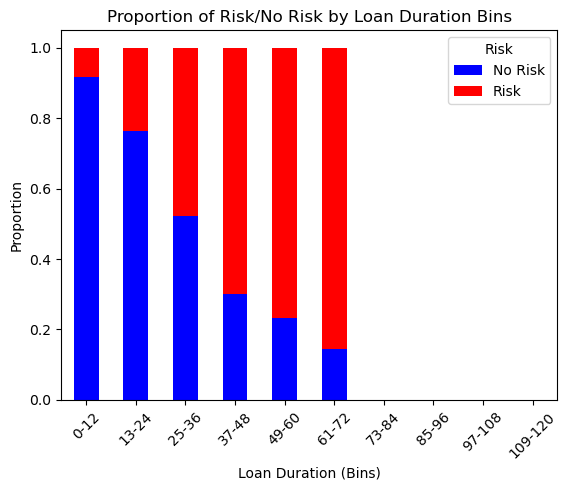

In [22]:
# Create bins for LoanDuration
bins = [0, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120]  # Define the bins for loan duration
labels = ['0-12', '13-24', '25-36', '37-48', '49-60', '61-72', '73-84', '85-96', '97-108', '109-120']  # Labels for the bins

# Create a new column 'LoanDuration_bin' based on the bins
train_df['LoanDuration_bin'] = pd.cut(train_df['LoanDuration'], bins=bins, labels=labels, right=False)

# Calculate the proportion of Risk/No Risk in each bin
risk_proportion = train_df.groupby('LoanDuration_bin')['Risk'].value_counts(normalize=True).unstack()

# Visualize the result
plt.figure(figsize=(10, 6))
risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'])
plt.title('Proportion of Risk/No Risk by Loan Duration Bins')
plt.xlabel('Loan Duration (Bins)')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])
plt.show()


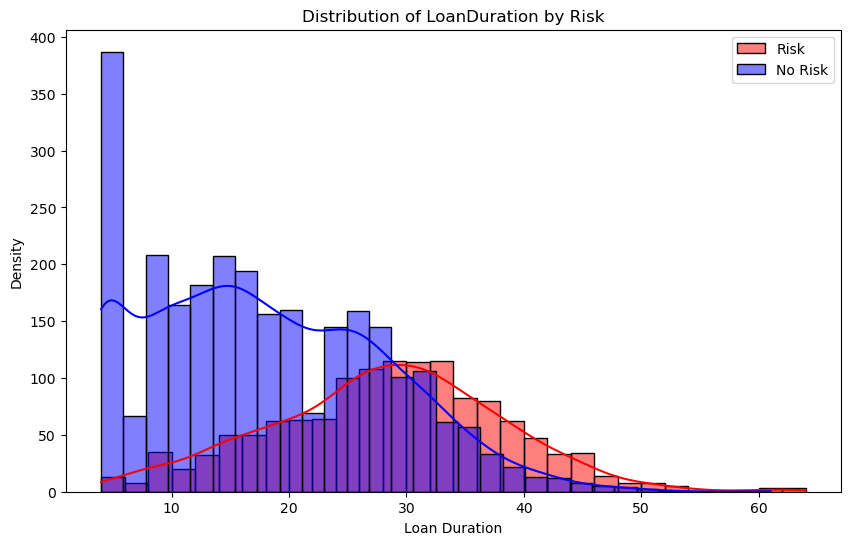

In [23]:
# 1️⃣ Plot the distribution of LoanDuration for Risk vs No Risk using histplot with KDE
plt.figure(figsize=(10, 6))
sns.histplot(train_df[train_df['Risk'] == "Risk"]['LoanDuration'], color="red", label="Risk", kde=True, bins=30)
sns.histplot(train_df[train_df['Risk'] == "No Risk"]['LoanDuration'], color="blue", label="No Risk", kde=True, bins=30)

# 2️⃣ Customize the plot
plt.legend()
plt.title("Distribution of LoanDuration by Risk")
plt.xlabel("Loan Duration")
plt.ylabel("Density")
plt.show()


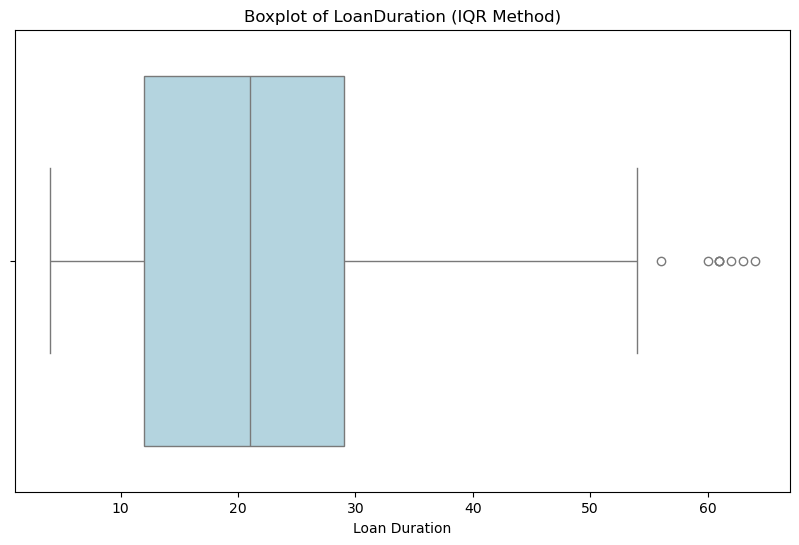

In [24]:
# 1️⃣ IQR method - Boxplot to visualize the outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=train_df['LoanDuration'], color='lightblue')
plt.title('Boxplot of LoanDuration (IQR Method)')
plt.xlabel('Loan Duration')
plt.show()


Significatif pas d'outlier

## Existing savings

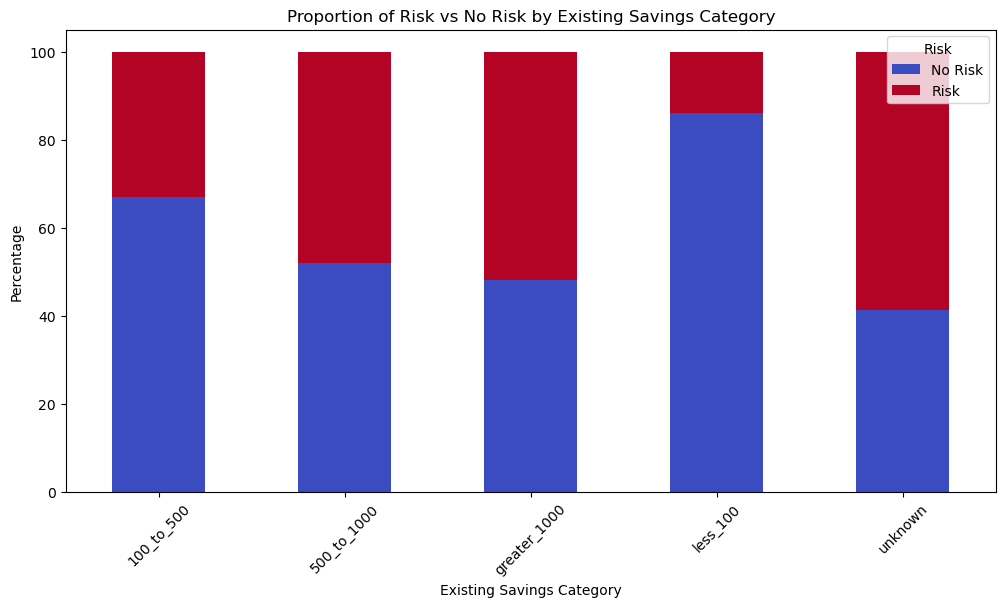

ExistingSavings
less_100        1485
100_to_500       883
500_to_1000      877
greater_1000     453
unknown          301
Name: count, dtype: int64


In [25]:
# 1️⃣ Calculate the count of Risk/No Risk for each category in ExistingSavings
existing_savings_counts = train_df.groupby('ExistingSavings')['Risk'].value_counts(normalize=True).unstack() * 100

# 2️⃣ Plot the proportion of Risk/No Risk for each category of ExistingSavings
existing_savings_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by Existing Savings Category")
plt.xlabel("Existing Savings Category")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()

# 3️⃣ Optionally, display the counts as well for better insight
print(train_df["ExistingSavings"].value_counts())


Significatif mais regrouper 500_to_100 et greater_1000 en une seule cat

## Employment Duration

EmploymentDuration
1_to_4        1150
4_to_7        1112
less_1         756
greater_7      738
unemployed     243
Name: count, dtype: int64


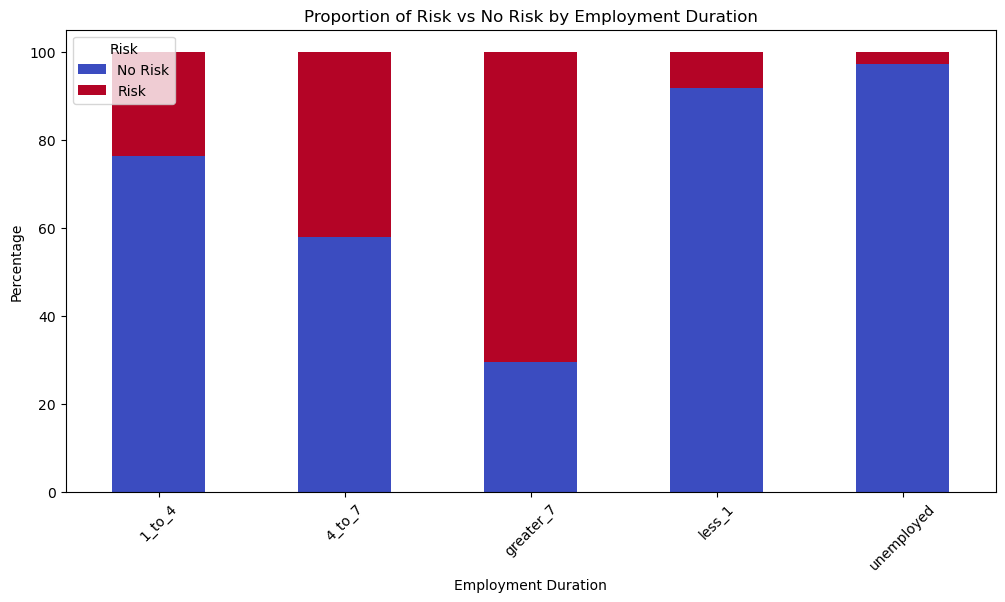

In [26]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('EmploymentDuration')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["EmploymentDuration"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by Employment Duration")
plt.xlabel("Employment Duration")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


## Installment Percent

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/1260883222.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('InstallmentPercent_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

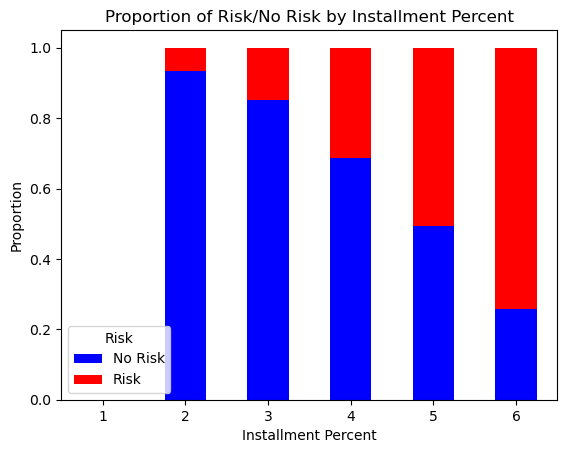

In [27]:
# Define bins and labels for InstallmentPercent
bins = [0, 1, 2, 3, 4, 5, 6]  # Covers the range from 1 to 6
labels = ['1', '2', '3', '4', '5', '6']  # Labels corresponding to each level

# Create a new column 'InstallmentPercent_bin' based on the bins
train_df['InstallmentPercent_bin'] = pd.cut(train_df['InstallmentPercent'], bins=bins, labels=labels, right=False)

# Calculate the proportion of Risk/No Risk in each bin
risk_proportion = train_df.groupby('InstallmentPercent_bin')['Risk'].value_counts(normalize=True).unstack()

# Visualize the result
plt.figure(figsize=(10, 6))
risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'])
plt.title('Proportion of Risk/No Risk by Installment Percent')
plt.xlabel('Installment Percent')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])
plt.show()


The higher the installment percent the higher the risk

## Sex

Sex
male      2480
female    1519
Name: count, dtype: int64


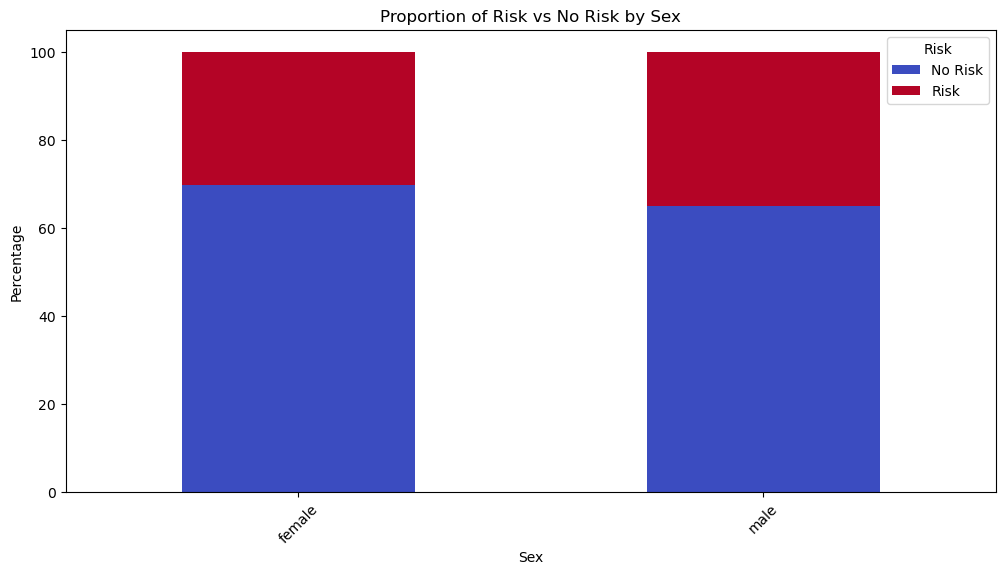

In [28]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('Sex')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["Sex"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by Sex")
plt.xlabel("Sex")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


In [29]:
from scipy.stats import chi2_contingency

# Create a contingency table for Sex and Risk
contingency_table = pd.crosstab(train_df['Sex'], train_df['Risk'])

# Perform the Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Chi-Square Statistic:", chi2_stat)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)
print("P-value:", p_value)

# Interpretation of the result
alpha = 0.05  # 5% significance level
if p_value < alpha:
    print("There is a significant relationship between Sex and Risk (reject null hypothesis).")
else:
    print("There is no significant relationship between Sex and Risk (fail to reject null hypothesis).")


Chi-Square Statistic: 9.985252843756381
Degrees of Freedom: 1
Expected Frequencies:
 [[1013.80620155  505.19379845]
 [1655.19379845  824.80620155]]
P-value: 0.001577988859277407
There is a significant relationship between Sex and Risk (reject null hypothesis).


In [30]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency

# Create a contingency table for Sex and Risk
contingency_table = pd.crosstab(train_df['Sex'], train_df['Risk'])

# Perform Chi-Square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Calculate Cramér's V
n = contingency_table.sum().sum()  # Total number of observations
phi2 = chi2_stat / n  # Phi-squared statistic
r, k = contingency_table.shape  # Number of rows and columns
cramers_v = np.sqrt(phi2 / min(r - 1, k - 1))  # Cramér's V formula

# Print the results
print("Cramér's V:", cramers_v)

# Interpretation of the result
if cramers_v < 0.1:
    print("The association between Sex and Risk is weak.")
elif cramers_v < 0.3:
    print("The association between Sex and Risk is moderate.")
else:
    print("The association between Sex and Risk is strong.")


Cramér's V: 0.049969365068013624
The association between Sex and Risk is weak.


Does not help much

## OthersOnLoan

OthersOnLoan
none            3334
co-applicant     580
guarantor         85
Name: count, dtype: int64


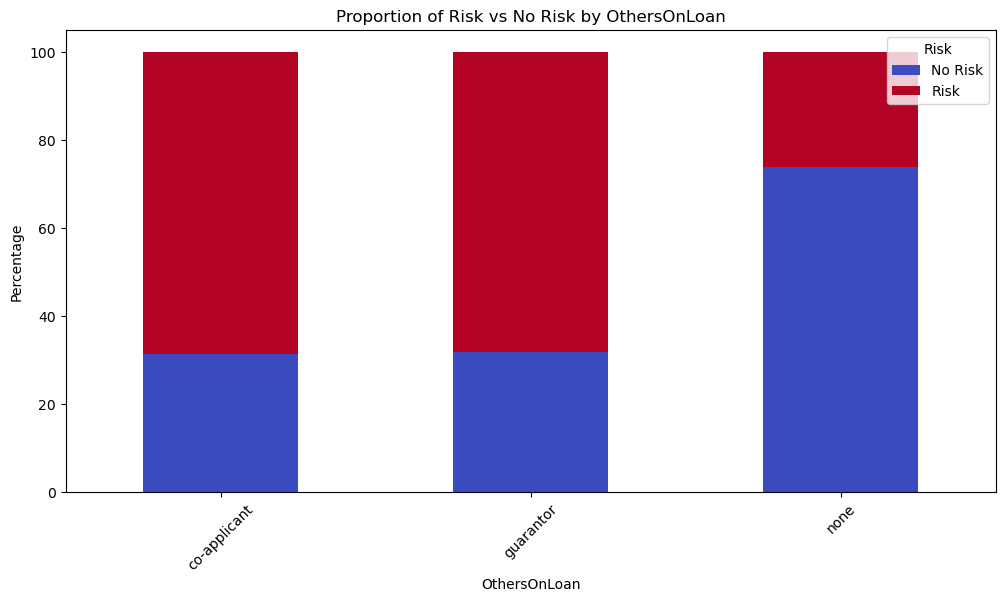

In [31]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('OthersOnLoan')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["OthersOnLoan"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by OthersOnLoan")
plt.xlabel("OthersOnLoan")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


In [32]:
from scipy.stats import chi2_contingency

# Filtrer le dataset pour exclure "none" et ne garder que "guarantor" et "co-applicant"
filtered_df = train_df[train_df['OthersOnLoan'].isin(['guarantor', 'co-applicant'])]

# Créer le tableau de contingence
contingency_table = pd.crosstab(filtered_df['OthersOnLoan'], filtered_df['Risk'])

# Appliquer le test du Chi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("Chi-Square Test for OthersOnLoan (Guarantor vs Co-Applicant):")
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

# Conclusion
if p_value < 0.05:
    print("There is a significant relationship between OthersOnLoan and Risk (reject null hypothesis).")
else:
    print("There is no significant relationship between OthersOnLoan and Risk (fail to reject null hypothesis).")

# Vérifier si les effectifs attendus sont trop faibles
if (expected < 5).sum() > 0:
    print("\n⚠️ Warning: Some expected frequencies are < 5, which may affect the validity of the Chi² test.")


Chi-Square Test for OthersOnLoan (Guarantor vs Co-Applicant):
Chi-Square Statistic: 0.0
P-value: 1.0
Degrees of Freedom: 1
Expected Frequencies:
 [[182.28571429 397.71428571]
 [ 26.71428571  58.28571429]]
There is no significant relationship between OthersOnLoan and Risk (fail to reject null hypothesis).


Utile mais fusionner les modalités guarantor et co-applicant, donc transformer en variable booléenne valant 0 si valait avant "none" et 1 si valait avant "guarantor" ou "co-applicant"

## CurrentResidenceDuration

In [33]:
train_df["CurrentResidenceDuration"].describe()
train_df["CurrentResidenceDuration"].value_counts()


CurrentResidenceDuration
3    1326
2    1019
4     858
1     520
5     273
6       3
Name: count, dtype: int64

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/1766233312.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('CurrentResidenceDuration_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

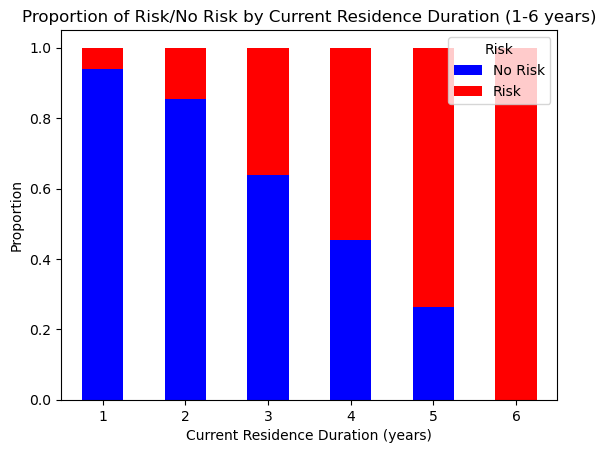

In [34]:
# Define bins and labels for CurrentResidenceDuration (1 to 6)
bins = [1, 2, 3, 4, 5, 6, 7]  # Covers values from 1 to 6
labels = ['1', '2', '3', '4', '5', '6']  # Labels corresponding to each level

# Create a new column 'CurrentResidenceDuration_bin' based on the bins
train_df['CurrentResidenceDuration_bin'] = pd.cut(train_df['CurrentResidenceDuration'], bins=bins, labels=labels, right=False)

# Calculate the proportion of Risk/No Risk in each bin
risk_proportion = train_df.groupby('CurrentResidenceDuration_bin')['Risk'].value_counts(normalize=True).unstack()

# Visualize the result
plt.figure(figsize=(10, 6))
risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'])
plt.title('Proportion of Risk/No Risk by Current Residence Duration (1-6 years)')
plt.xlabel('Current Residence Duration (years)')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])
plt.show()


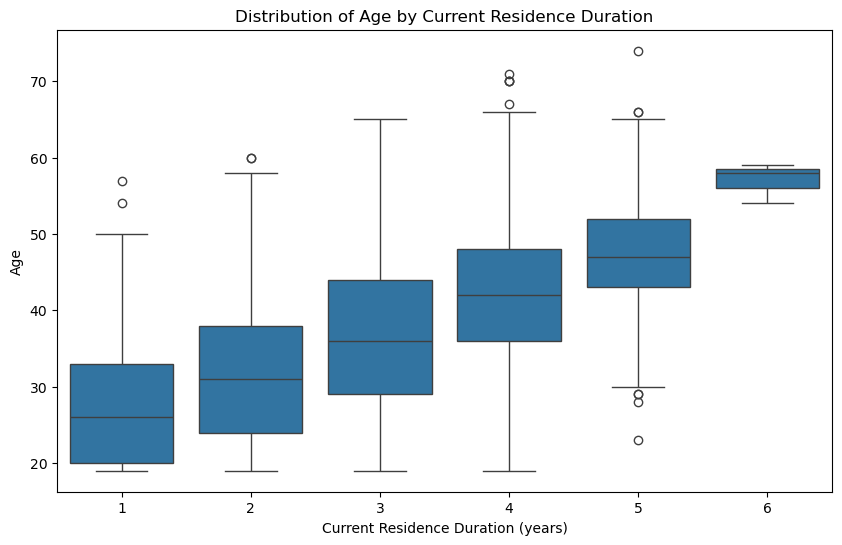

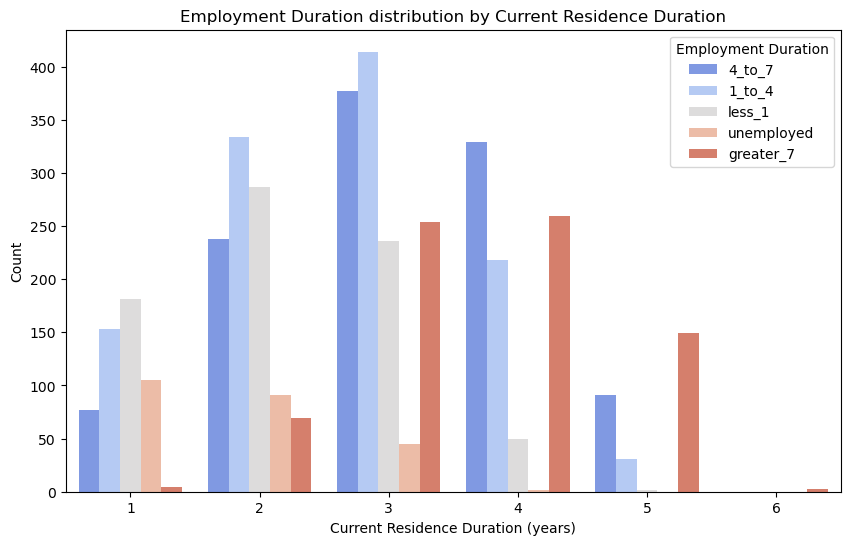

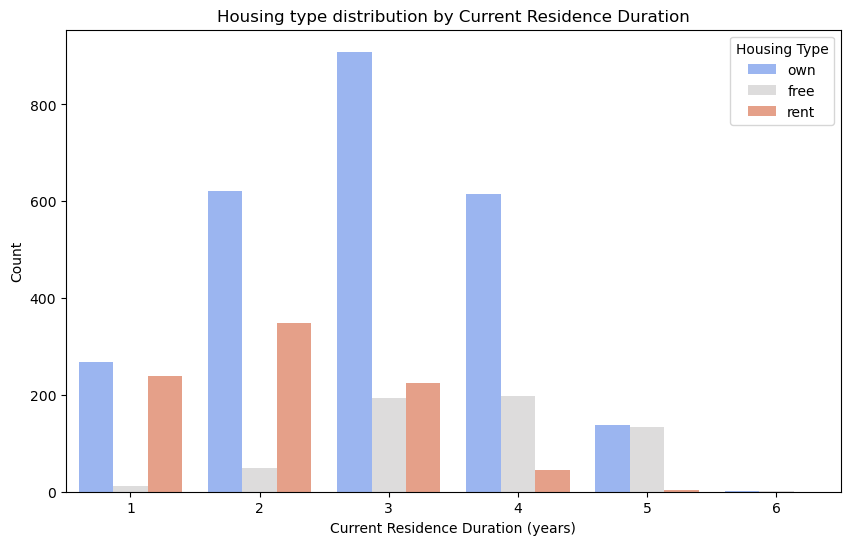

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/1113998991.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="CurrentResidenceDuration", y=train_df["Risk"].apply(lambda x: 1 if x == "Risk" else 0), data=train_df, ci=None)


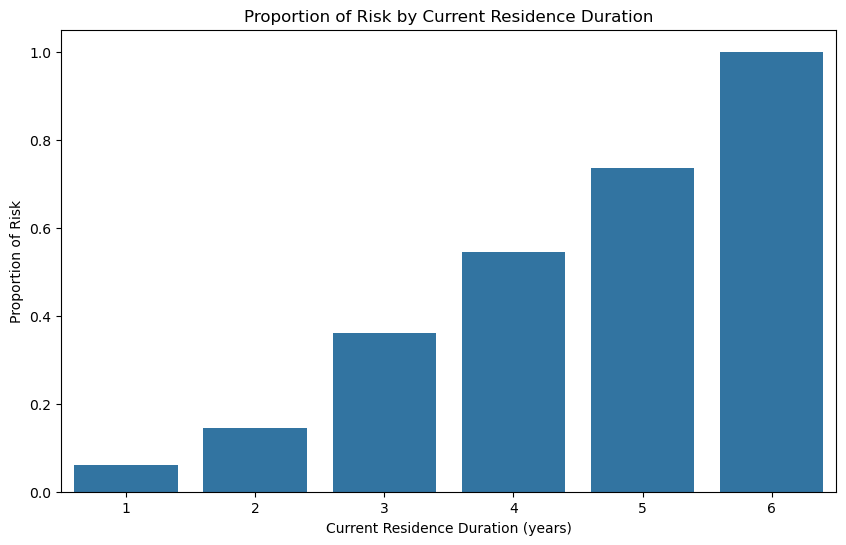

In [35]:
# 1. Analyse croisée entre Age et CurrentResidenceDuration
plt.figure(figsize=(10, 6))
sns.boxplot(x="CurrentResidenceDuration", y="Age", data=train_df)
plt.title("Distribution of Age by Current Residence Duration")
plt.xlabel("Current Residence Duration (years)")
plt.ylabel("Age")
plt.show()

# 2. Analyse croisée entre EmploymentDuration et CurrentResidenceDuration
plt.figure(figsize=(10, 6))
sns.countplot(x="CurrentResidenceDuration", hue="EmploymentDuration", data=train_df, palette="coolwarm")
plt.title("Employment Duration distribution by Current Residence Duration")
plt.xlabel("Current Residence Duration (years)")
plt.ylabel("Count")
plt.legend(title="Employment Duration")
plt.show()

# 3. Analyse croisée entre Housing et CurrentResidenceDuration
plt.figure(figsize=(10, 6))
sns.countplot(x="CurrentResidenceDuration", hue="Housing", data=train_df, palette="coolwarm")
plt.title("Housing type distribution by Current Residence Duration")
plt.xlabel("Current Residence Duration (years)")
plt.ylabel("Count")
plt.legend(title="Housing Type")
plt.show()

# 4. Analyse du risque en fonction de la durée de résidence et des autres variables
plt.figure(figsize=(10, 6))
sns.barplot(x="CurrentResidenceDuration", y=train_df["Risk"].apply(lambda x: 1 if x == "Risk" else 0), data=train_df, ci=None)
plt.title("Proportion of Risk by Current Residence Duration")
plt.xlabel("Current Residence Duration (years)")
plt.ylabel("Proportion of Risk")
plt.show()


A priori significatif mais contr intuitif donc essayer de virer + remplacer 6 par 5 pour éviter overfitting

## OwnsProperty

OwnsProperty
savings_insurance    1332
car_other            1228
real_estate           872
unknown               567
Name: count, dtype: int64


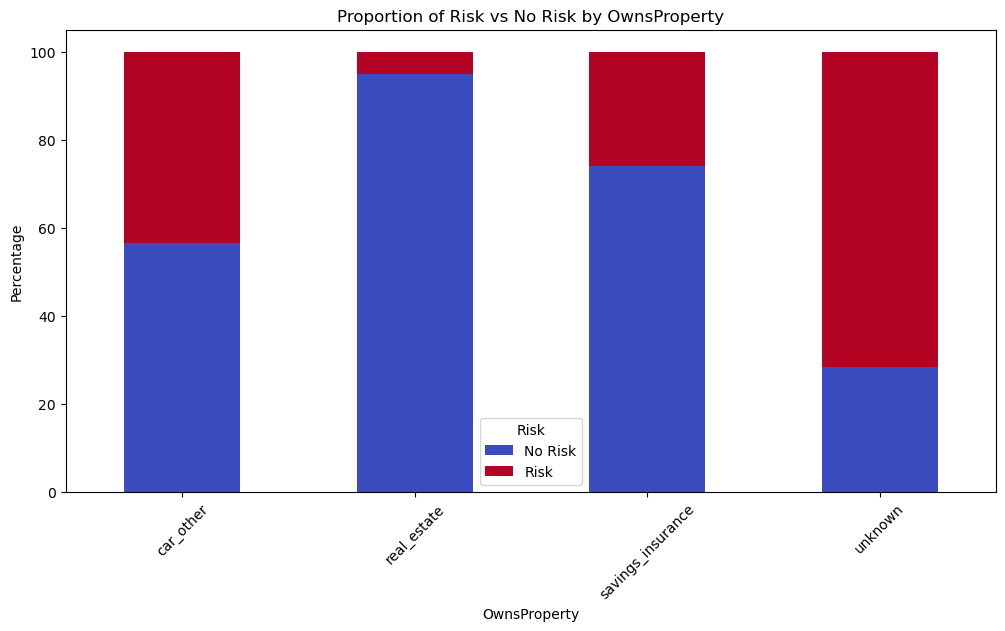

In [36]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('OwnsProperty')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["OwnsProperty"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by OwnsProperty")
plt.xlabel("OwnsProperty")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


Significatif

## Age

In [37]:
print(train_df["Age"].describe())
train_df["Age"].value_counts()

count    3999.000000
mean       35.896224
std        10.628733
min        19.000000
25%        28.000000
50%        36.000000
75%        44.000000
max        74.000000
Name: Age, dtype: float64


Age
19    343
36    155
40    141
33    136
41    133
28    132
34    131
37    129
39    129
42    123
31    123
32    120
38    118
43    115
45    115
30    113
29    112
44    109
35    108
46    102
27     97
47     97
26     90
24     89
25     86
49     77
22     76
48     74
23     71
50     71
51     63
20     61
21     56
52     55
53     45
54     42
55     35
56     23
57     21
58     20
59     16
60     14
61      7
65      5
62      4
64      4
63      4
66      3
70      3
67      1
71      1
74      1
Name: count, dtype: int64

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/1281070216.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('Age_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

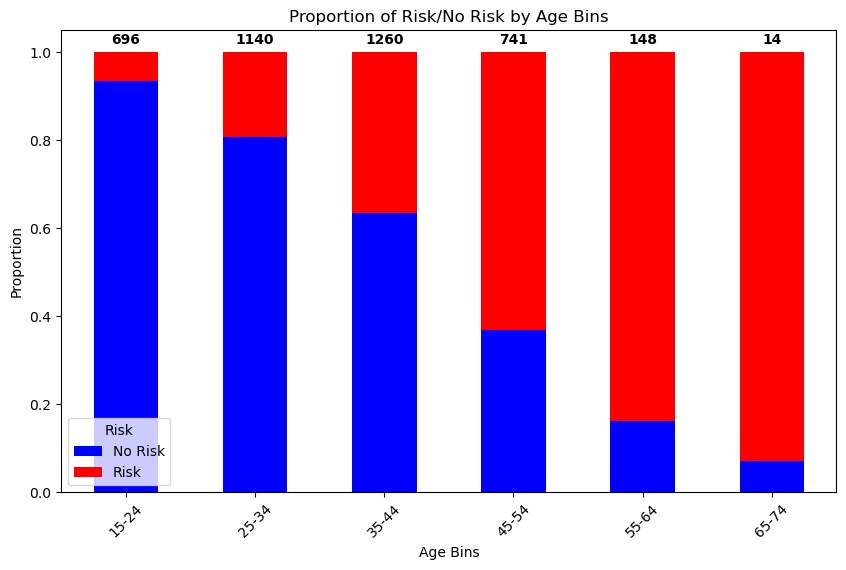

Age_bin
35-44    1260
25-34    1140
45-54     741
15-24     696
55-64     148
65-74      14
Name: count, dtype: int64


In [38]:
# Define bins and labels for Age (from 19 to 74)
bins = list(range(15, 81, 10))  # Bins de 10 ans : 15-24, 25-34, ..., 75-80
labels = [f"{i}-{i+9}" for i in bins[:-1]]  # Labels correspondants

# Create a new column 'Age_bin' based on the bins
train_df['Age_bin'] = pd.cut(train_df['Age'], bins=bins, labels=labels, right=False)

# Calculate the proportion of Risk/No Risk in each bin
risk_proportion = train_df.groupby('Age_bin')['Risk'].value_counts(normalize=True).unstack()

# Calculate the count of values per bin
bin_counts = train_df['Age_bin'].value_counts().sort_index()

# Visualize the proportion result
plt.figure(figsize=(10, 6))
ax = risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))
plt.title('Proportion of Risk/No Risk by Age Bins')
plt.xlabel('Age Bins')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])

# Annotate each bar with the count of values
for i, count in enumerate(bin_counts):
    ax.text(i, 1.02, f"{count}", ha='center', fontsize=10, fontweight='bold')

plt.show()
print(train_df['Age_bin'].value_counts())


Significatif conserver

## Installment Plans

InstallmentPlans
none      2807
stores     820
bank       372
Name: count, dtype: int64


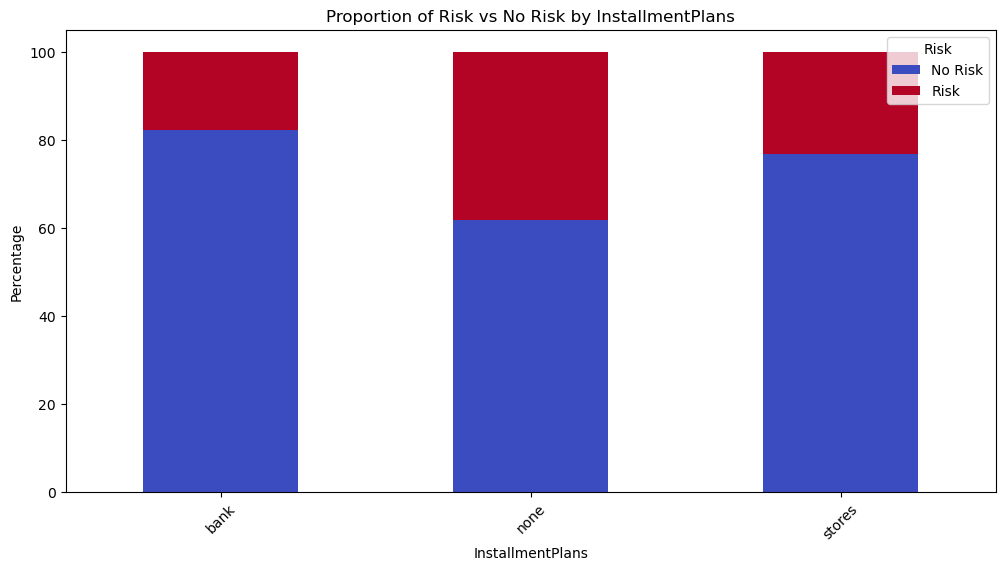

In [39]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('InstallmentPlans')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["InstallmentPlans"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by InstallmentPlans")
plt.xlabel("InstallmentPlans")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


In [40]:
from scipy.stats import chi2_contingency

# Filtrer le dataset pour exclure "none" et ne garder que "bank" et "stores"
filtered_df = train_df[train_df['InstallmentPlans'].isin(['bank', 'stores'])]

# Créer le tableau de contingence correct
contingency_table = pd.crosstab(filtered_df['InstallmentPlans'], filtered_df['Risk'])

# Appliquer le test du Chi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("Chi-Square Test for InstallmentPlans (Bank vs Stores):")
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

# Conclusion
if p_value < 0.05:
    print("There is a significant relationship between InstallmentPlans and Risk (reject null hypothesis).")
else:
    print("There is no significant relationship between InstallmentPlans and Risk (fail to reject null hypothesis).")


Chi-Square Test for InstallmentPlans (Bank vs Stores):
Chi-Square Statistic: 4.339764655153556
P-value: 0.03723206957414663
Degrees of Freedom: 1
Expected Frequencies:
 [[291.79530201  80.20469799]
 [643.20469799 176.79530201]]
There is a significant relationship between InstallmentPlans and Risk (reject null hypothesis).


## Housing

Housing
own     2554
rent     860
free     585
Name: count, dtype: int64


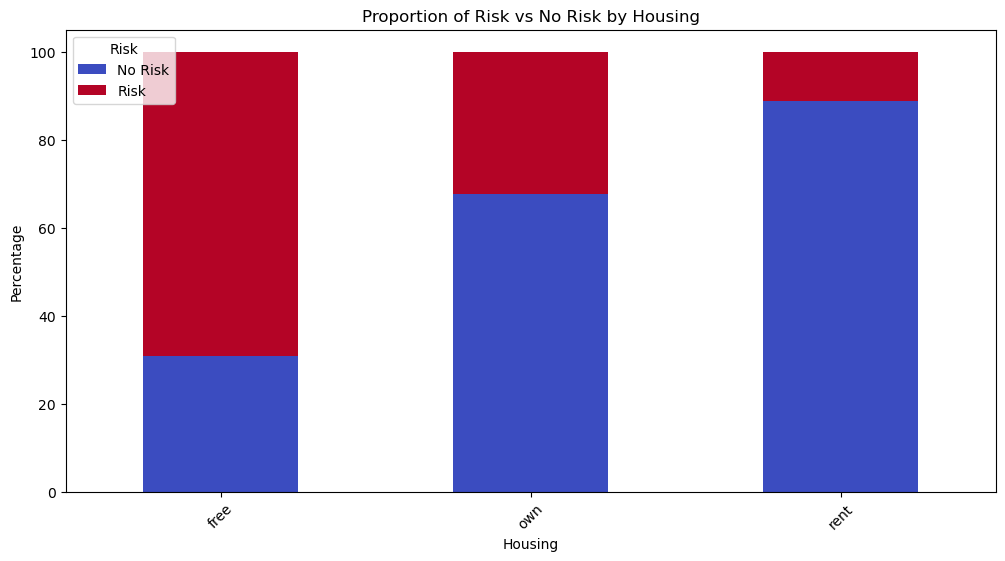

In [41]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('Housing')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["Housing"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by Housing")
plt.xlabel("Housing")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


Significatif, keep

##  ExistingCreditsCount

In [42]:
print(train_df["ExistingCreditsCount"].describe())
train_df["ExistingCreditsCount"].value_counts()

count    3999.000000
mean        1.470618
std         0.568098
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: ExistingCreditsCount, dtype: float64


ExistingCreditsCount
1    2264
2    1588
3     147
Name: count, dtype: int64

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/3850208286.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('ExistingCreditsCount_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

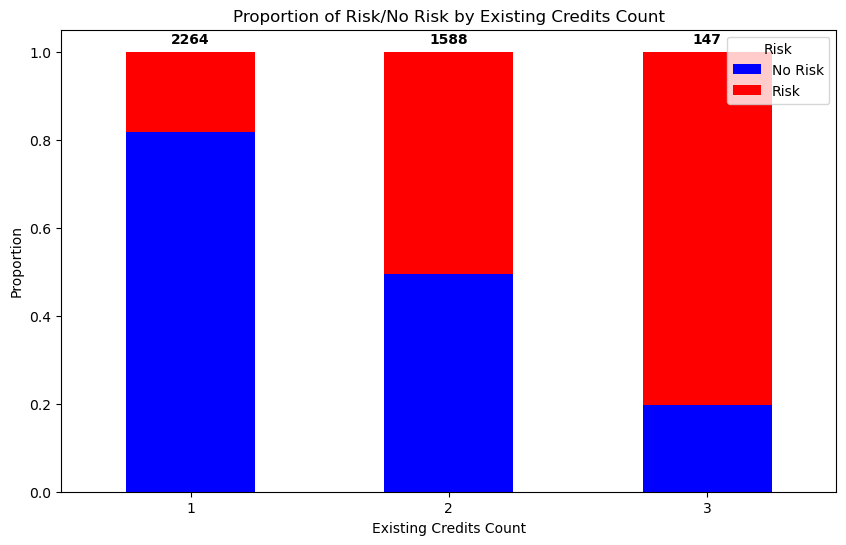

ExistingCreditsCount_bin
1    2264
2    1588
3     147
Name: count, dtype: int64


In [43]:
# Define bins and labels for ExistingCreditsCount (1, 2, 3)
bins = [1, 2, 3,4]  # Bins pour couvrir 1, 2 et 3
labels = ['1', '2', '3']  # Labels correspondants

# Create a new column 'ExistingCreditsCount_bin' based on the bins
train_df['ExistingCreditsCount_bin'] = pd.cut(train_df['ExistingCreditsCount'], bins=bins, labels=labels, right=False)

# Calculate the proportion of Risk/No Risk in each bin
risk_proportion = train_df.groupby('ExistingCreditsCount_bin')['Risk'].value_counts(normalize=True).unstack()

# Calculate the count of values per bin
bin_counts = train_df['ExistingCreditsCount_bin'].value_counts().sort_index()

# Visualize the proportion result
plt.figure(figsize=(10, 6))
ax = risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))
plt.title('Proportion of Risk/No Risk by Existing Credits Count')
plt.xlabel('Existing Credits Count')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])

# Annotate each bar with the count of values
for i, count in enumerate(bin_counts):
    ax.text(i, 1.02, f"{count}", ha='center', fontsize=10, fontweight='bold')

plt.show()

# Print the count of values in each bin
print(train_df['ExistingCreditsCount_bin'].value_counts())


Préférer OHE

## job

Job
skilled                     2726
unskilled                    535
management_self-employed     507
unemployed                   231
Name: count, dtype: int64


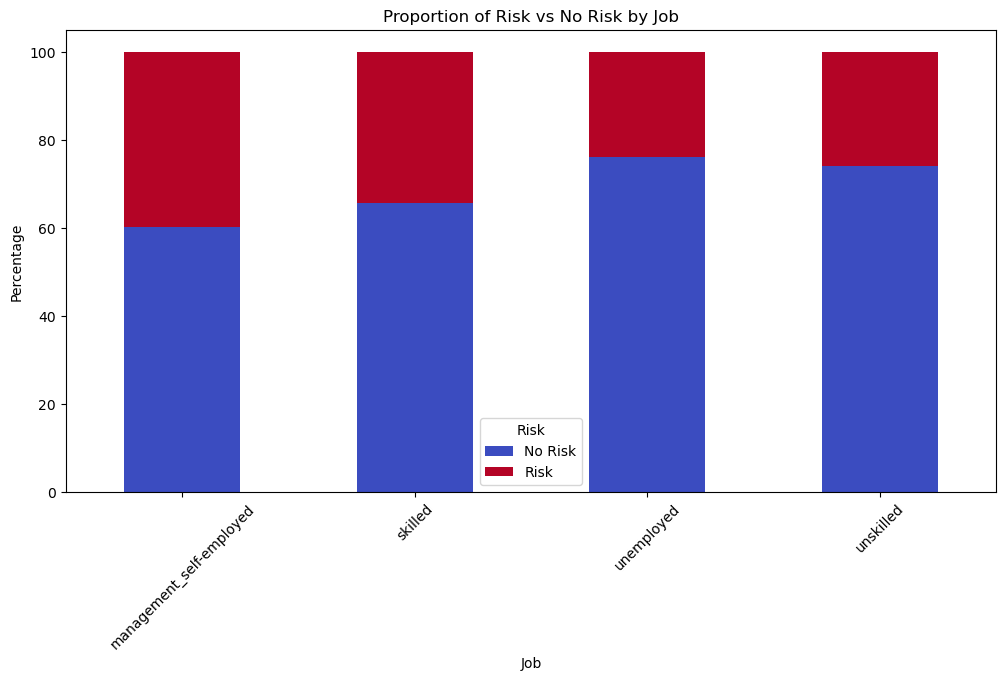

In [44]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('Job')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["Job"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by Job")
plt.xlabel("Job")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


In [45]:
from scipy.stats import chi2_contingency

# Filtrer le dataset pour ne garder que "unskilled" et "unemployed"
filtered_df = train_df[train_df['Job'].isin(['unskilled', 'unemployed'])]

# Créer le tableau de contingence
contingency_table = pd.crosstab(filtered_df['Job'], filtered_df['Risk'])

# Appliquer le test du Chi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("🔹 Chi-Square Test for Job (Unskilled vs Unemployed):")
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

# Conclusion
if p_value < 0.05:
    print("⚠️ Il y a une différence significative entre 'unskilled' et 'unemployed' (on rejette H0).")
    print("👉 Il est pertinent de les garder séparés.")
else:
    print("✅ Aucune différence significative entre 'unskilled' et 'unemployed' (on ne rejette pas H0).")
    print("👉 Il est possible de les fusionner sans perte d'information.")


🔹 Chi-Square Test for Job (Unskilled vs Unemployed):
Chi-Square Statistic: 0.29573211301132063
P-value: 0.5865704568806445
Degrees of Freedom: 1
Expected Frequencies:
 [[172.49608355  58.50391645]
 [399.50391645 135.49608355]]
✅ Aucune différence significative entre 'unskilled' et 'unemployed' (on ne rejette pas H0).
👉 Il est possible de les fusionner sans perte d'information.


In [46]:
from scipy.stats import chi2_contingency

# Filtrer le dataset pour ne garder que "management", "self-employed" et "skilled"
filtered_df = train_df[train_df['Job'].isin(['management_self-employed', 'skilled'])]

# Créer le tableau de contingence
contingency_table = pd.crosstab(filtered_df['Job'], filtered_df['Risk'])

# Appliquer le test du Chi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("🔹 Chi-Square Test for Job (Management, Self-Employed, Skilled):")
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

# Conclusion
if p_value < 0.05:
    print("⚠️ Il y a une différence significative entre 'management', 'self-employed' et 'skilled' (on rejette H0).")
    print("👉 Il est pertinent de les garder séparés.")
else:
    print("✅ Aucune différence significative entre 'management', 'self-employed' et 'skilled' (on ne rejette pas H0).")
    print("👉 Il est possible de les fusionner en une seule catégorie.")


🔹 Chi-Square Test for Job (Management, Self-Employed, Skilled):
Chi-Square Statistic: 5.5970640076453195
P-value: 0.017990602188038274
Degrees of Freedom: 1
Expected Frequencies:
 [[ 328.85214971  178.14785029]
 [1768.14785029  957.85214971]]
⚠️ Il y a une différence significative entre 'management', 'self-employed' et 'skilled' (on rejette H0).
👉 Il est pertinent de les garder séparés.


Pertinent mais fusionner unemployed et unskilled

## Dependents

In [47]:
print(train_df["Dependents"].describe())
train_df["Dependents"].value_counts()

count    3999.000000
mean        1.163541
std         0.369905
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: Dependents, dtype: float64


Dependents
1    3345
2     654
Name: count, dtype: int64

/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/1277436909.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('Dependents')['Risk'].value_counts(normalize=True).unstack() * 100


<Figure size 1000x600 with 0 Axes>

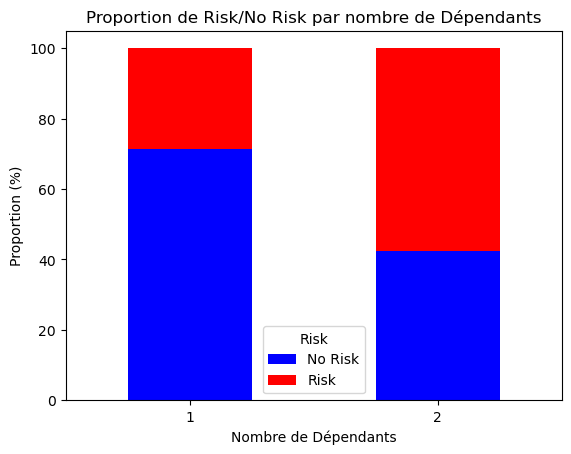

Dependents
1    3345
2     654
Name: count, dtype: int64


In [48]:

# Convertir 'Dependents' en variable catégorielle
train_df['Dependents'] = train_df['Dependents'].astype('category')

# Calculer la proportion de Risk/No Risk pour chaque modalité de Dependents
risk_proportion = train_df.groupby('Dependents')['Risk'].value_counts(normalize=True).unstack() * 100

# Visualiser les proportions avec un bar plot empilé
plt.figure(figsize=(10, 6))
risk_proportion.plot(kind="bar", stacked=True, color=['blue', 'red'])
plt.title('Proportion de Risk/No Risk par nombre de Dépendants')
plt.xlabel('Nombre de Dépendants')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])
plt.show()

# Afficher le comptage des valeurs de "Dependents"
print(train_df['Dependents'].value_counts())


Significatif

## Telephone

Telephone
none    2348
yes     1651
Name: count, dtype: int64


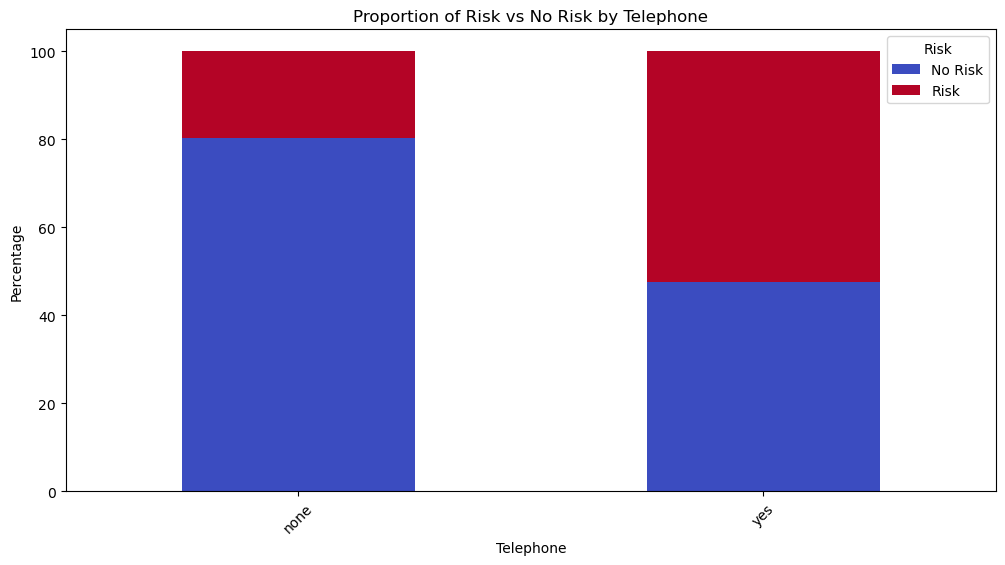

In [49]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('Telephone')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["Telephone"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by Telephone")
plt.xlabel("Telephone")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


In [50]:
import pandas as pd
from scipy.stats import chi2_contingency

# Filtrer les données pour ne conserver que les modalités "none" et "yes" de Telephone
filtered_df = train_df[train_df['Telephone'].isin(['none', 'yes'])]

# Créer le tableau de contingence
contingency_table = pd.crosstab(filtered_df['Telephone'], filtered_df['Risk'])

# Appliquer le test du Chi²
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats
print("Chi-Square Test for Telephone (none vs yes):")
print("Chi-Square Statistic:", chi2_stat)
print("P-value:", p_value)
print("Degrees of Freedom:", dof)
print("Expected Frequencies:\n", expected)

# Conclusion
if p_value < 0.05:
    print("There is a significant relationship between Telephone and Risk (reject null hypothesis).")
else:
    print("There is no significant relationship between Telephone and Risk (fail to reject null hypothesis).")


Chi-Square Test for Telephone (none vs yes):
Chi-Square Statistic: 468.20600418717135
P-value: 7.873301741233224e-104
Degrees of Freedom: 1
Expected Frequencies:
 [[1567.09477369  780.90522631]
 [1101.90522631  549.09477369]]
There is a significant relationship between Telephone and Risk (reject null hypothesis).


## Foreign Worker

ForeignWorker
yes    3908
no       91
Name: count, dtype: int64


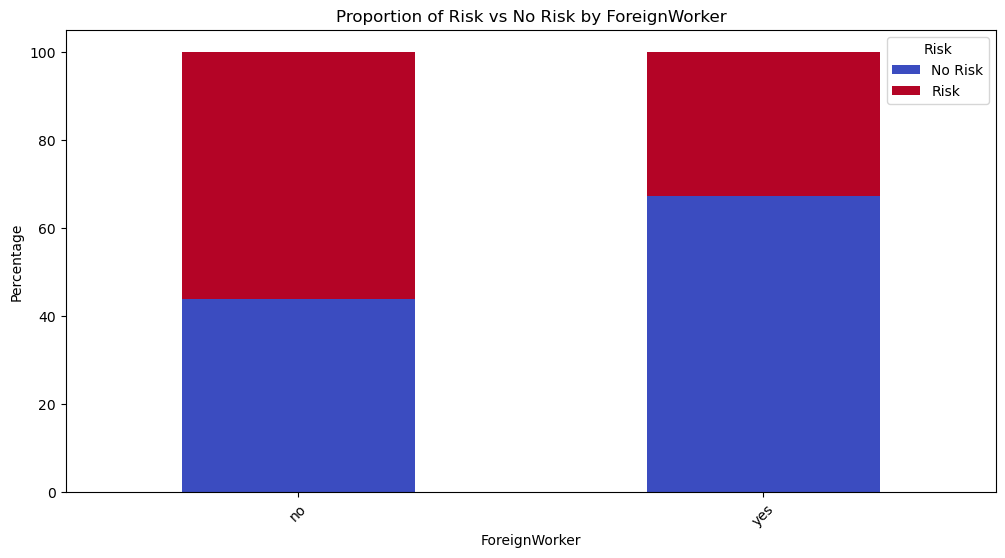

In [51]:
# Group by EmploymentDuration and calculate the percentage of Risk and No Risk
employment_duration_counts = train_df.groupby('ForeignWorker')['Risk'].value_counts(normalize=True).unstack() * 100

# Print the percentage table
print(train_df["ForeignWorker"].value_counts())

# Plot a stacked bar chart
employment_duration_counts.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion of Risk vs No Risk by ForeignWorker")
plt.xlabel("ForeignWorker")
plt.ylabel("Percentage")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()

In [52]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# Créer un tableau de contingence entre Risk et ForeignWorker
contingency_table = pd.crosstab(train_df['Risk'], train_df['ForeignWorker'])

# Appliquer le test du Chi-Carré
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Afficher les résultats du test du Chi-Carré
print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
print(f"Expected Frequencies:\n{expected}")

# Calcul de Cramér's V
n = contingency_table.sum().sum()  # Total des observations
phi2 = chi2_stat / n  # Calcul de Phi²
r, k = contingency_table.shape  # Nombre de lignes et de colonnes
phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))  # Corriger si nécessaire
cramer_v = np.sqrt(phi2corr / min(r - 1, k - 1))  # Calcul de Cramér's V

# Afficher la valeur de Cramér's V
print(f"Cramér's V: {cramer_v}")

# Conclusion du test
if p_value < 0.05:
    print("There is a significant relationship between Risk and ForeignWorker (reject null hypothesis).")
else:
    print("There is no significant relationship between Risk and ForeignWorker (fail to reject null hypothesis).")


Chi-Square Statistic: 20.74252504931197
P-value: 5.253624950688327e-06
Degrees of Freedom: 1
Expected Frequencies:
[[  60.73493373 2608.26506627]
 [  30.26506627 1299.73493373]]
Cramér's V: 0.07026238632294884
There is a significant relationship between Risk and ForeignWorker (reject null hypothesis).


Trop imbalanced + too low correlation

## LoanAmount per month

In [53]:
train_df['LoanAmount_per_month'] = train_df['LoanAmount'] / train_df['LoanDuration']


In [54]:
print(train_df["LoanAmount_per_month"].describe())

count    3999.000000
mean      171.380319
std       137.023682
min         6.097561
25%        79.074357
50%       152.142857
75%       219.257053
max      1453.250000
Name: LoanAmount_per_month, dtype: float64


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/820124868.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('LoanAmount_per_month_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

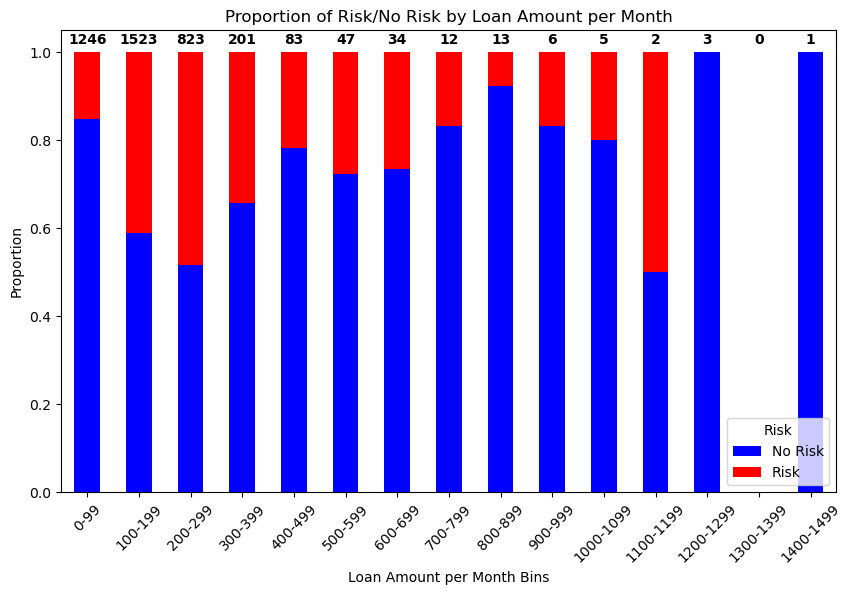

LoanAmount_per_month_bin
100-199      1523
0-99         1246
200-299       823
300-399       201
400-499        83
500-599        47
600-699        34
800-899        13
700-799        12
900-999         6
1000-1099       5
1200-1299       3
1100-1199       2
1400-1499       1
1300-1399       0
Name: count, dtype: int64


In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Définir les bins pour LoanAmount_per_month (de 100 en 100)
bins = list(range(0, 1600, 100))  # Plage de bins de 100 en 100

# Les labels doivent être un de moins que les bins
labels = [f"{i}-{i+99}" for i in range(0, 1500, 100)]  # Labels pour chaque bin (ajuster en fonction des bins)

# Créer une nouvelle colonne 'LoanAmount_per_month_bin' en fonction des bins
train_df['LoanAmount_per_month_bin'] = pd.cut(train_df['LoanAmount_per_month'], bins=bins, labels=labels, right=False)

# Calculer la proportion de Risk/No Risk dans chaque bin
risk_proportion = train_df.groupby('LoanAmount_per_month_bin')['Risk'].value_counts(normalize=True).unstack()

# Calculer le nombre de valeurs par bin
bin_counts = train_df['LoanAmount_per_month_bin'].value_counts().sort_index()

# Visualiser les résultats sous forme de graphique à barres empilées
plt.figure(figsize=(10, 6))
ax = risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))
plt.title('Proportion of Risk/No Risk by Loan Amount per Month')
plt.xlabel('Loan Amount per Month Bins')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])

# Annoter chaque barre avec le nombre de valeurs
for i, count in enumerate(bin_counts):
    ax.text(i, 1.02, f"{count}", ha='center', fontsize=10, fontweight='bold')

plt.show()

# Afficher le compte des observations par catégorie de LoanAmount_per_month_bin
print(train_df['LoanAmount_per_month_bin'].value_counts())


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/3162999372.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('LoanAmount_per_month_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

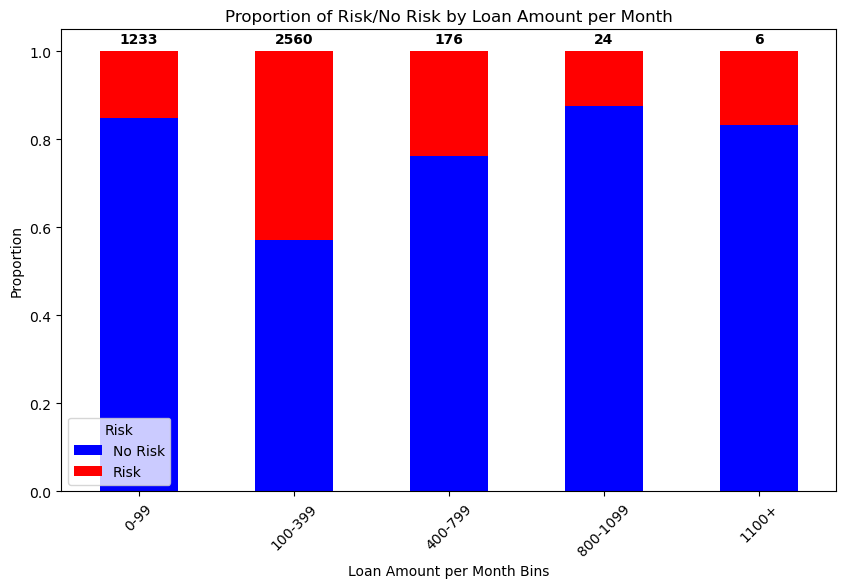

LoanAmount_per_month_bin
100-399     2560
0-99        1233
400-799      176
800-1099      24
1100+          6
Name: count, dtype: int64


In [56]:
import matplotlib.pyplot as plt
import pandas as pd

# Définir les bins avec les intervalles spécifiques
bins = [0, 99, 399, 799, 1099, float('inf')]  # Plage de bins personnalisée
labels = ['0-99', '100-399', '400-799', '800-1099', '1100+']  # Labels correspondants

# Créer une nouvelle colonne 'LoanAmount_per_month_bin' en fonction des bins
train_df['LoanAmount_per_month_bin'] = pd.cut(train_df['LoanAmount_per_month'], bins=bins, labels=labels, right=False)

# Calculer la proportion de Risk/No Risk dans chaque bin
risk_proportion = train_df.groupby('LoanAmount_per_month_bin')['Risk'].value_counts(normalize=True).unstack()

# Calculer le nombre de valeurs par bin
bin_counts = train_df['LoanAmount_per_month_bin'].value_counts().sort_index()

# Visualiser les résultats sous forme de graphique à barres empilées
plt.figure(figsize=(10, 6))
ax = risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))
plt.title('Proportion of Risk/No Risk by Loan Amount per Month')
plt.xlabel('Loan Amount per Month Bins')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])

# Annoter chaque barre avec le nombre de valeurs
for i, count in enumerate(bin_counts):
    ax.text(i, 1.02, f"{count}", ha='center', fontsize=10, fontweight='bold')

plt.show()

# Afficher le compte des observations par catégorie de LoanAmount_per_month_bin
print(train_df['LoanAmount_per_month_bin'].value_counts())


## Age at end

In [57]:
# Calculer l'âge à la fin du prêt et l'arrondir à l'entier le plus proche
train_df['Age_at_loan_end'] = (train_df['Age'] + (train_df['LoanDuration'] / 12)).round().astype(int)


In [58]:
print(train_df["Age_at_loan_end"].describe())

count    3999.000000
mean       37.646912
std        11.183443
min        19.000000
25%        29.000000
50%        38.000000
75%        46.000000
max        77.000000
Name: Age_at_loan_end, dtype: float64


/var/folders/l7/6_r15vlj5839j1442vhdwjh80000gn/T/ipykernel_42944/2659272684.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_proportion = train_df.groupby('Age_at_loan_end_bin')['Risk'].value_counts(normalize=True).unstack()


<Figure size 1000x600 with 0 Axes>

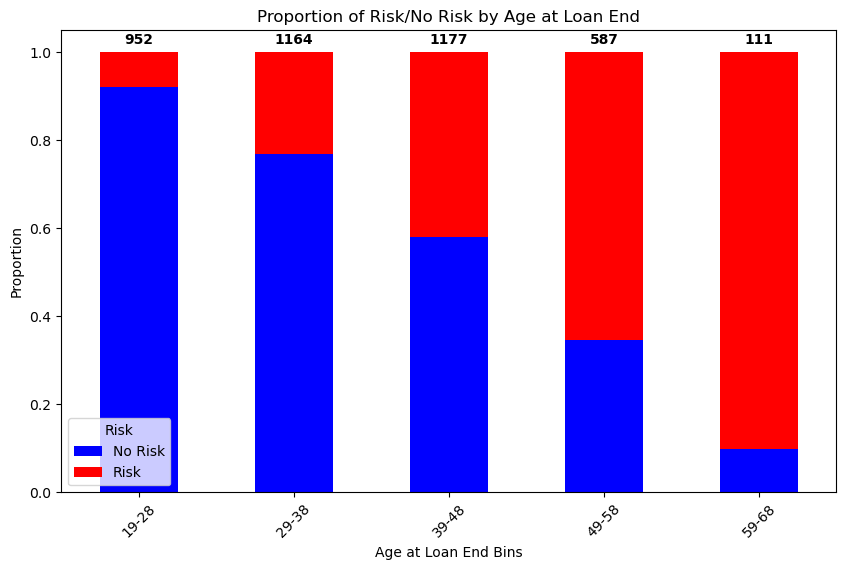

Age_at_loan_end_bin
39-48    1177
29-38    1164
19-28     952
49-58     587
59-68     111
Name: count, dtype: int64


In [59]:
import matplotlib.pyplot as plt
import pandas as pd

# Définir les bins pour Age_at_loan_end (de 10 en 10)
bins = list(range(19, 78, 10))  # Plage de bins de 10 en 10 (19-28, 29-38, ..., 69-78)

# Les labels doivent être un de moins que les bins
labels = [f"{i}-{i+9}" for i in range(19, 68, 10)]  # Labels pour chaque bin (ajuster en fonction des bins)

# Créer une nouvelle colonne 'Age_at_loan_end_bin' en fonction des bins
train_df['Age_at_loan_end_bin'] = pd.cut(train_df['Age_at_loan_end'], bins=bins, labels=labels, right=False)

# Calculer la proportion de Risk/No Risk dans chaque bin
risk_proportion = train_df.groupby('Age_at_loan_end_bin')['Risk'].value_counts(normalize=True).unstack()

# Calculer le nombre de valeurs par bin
bin_counts = train_df['Age_at_loan_end_bin'].value_counts().sort_index()

# Visualiser les résultats sous forme de graphique à barres empilées
plt.figure(figsize=(10, 6))
ax = risk_proportion.plot(kind='bar', stacked=True, color=['blue', 'red'], figsize=(10, 6))
plt.title('Proportion of Risk/No Risk by Age at Loan End')
plt.xlabel('Age at Loan End Bins')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Risk', labels=['No Risk', 'Risk'])

# Annoter chaque barre avec le nombre de valeurs
for i, count in enumerate(bin_counts):
    ax.text(i, 1.02, f"{count}", ha='center', fontsize=10, fontweight='bold')

plt.show()

# Afficher le compte des observations par catégorie de Age_at_loan_end_bin
print(train_df['Age_at_loan_end_bin'].value_counts())


Correlation between Age_at_loan_end and Age: 0.9970664043155291


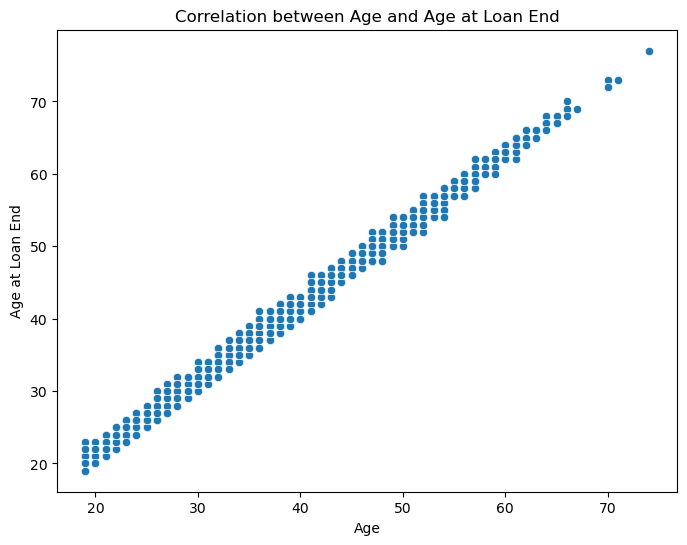

In [60]:
# Calculer la corrélation entre Age_at_loan_end et Age
correlation = train_df['Age_at_loan_end'].corr(train_df['Age'])

# Afficher la corrélation
print(f"Correlation between Age_at_loan_end and Age: {correlation}")

# Visualiser la corrélation avec un scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_df['Age'], y=train_df['Age_at_loan_end'])
plt.title('Correlation between Age and Age at Loan End')
plt.xlabel('Age')
plt.ylabel('Age at Loan End')
plt.show()


# Prepocessing

In [61]:
def feature_engineering(df):
    # 1) Compute Age at loan end
    df['Age_at_loan_end'] = (df['Age'] + (df['LoanDuration'] / 12)).round().astype(np.int64)
    
    # 2) Compute LoanAmount per month: LoanAmount / LoanDuration
    df['LoanAmount_per_month'] = df['LoanAmount'] / df['LoanDuration']
    
    # 3) Bin LoanAmount_per_month into predefined categories
    bins = [0, 99, 399, 799, 1099, np.inf]
    labels = ['0-99', '100-399', '400-799', '800-1099', '1100+']
    df['LoanAmount_per_month'] = pd.cut(df['LoanAmount_per_month'], bins=bins, labels=labels, right=False)

    # 4) Modify 'ExistingSavings': merge '500_to_1000' and 'greater_1000' into '500+'
    df['ExistingSavings'] = df['ExistingSavings'].replace({'500_to_1000': '500+', 'greater_1000': '500+'})

    # 5) Modify 'OthersOnLoan': convert to boolean (1 if 'guarantor' or 'co-applicant', else 0)
    df['OthersOnLoan'] = df['OthersOnLoan'].apply(lambda x: 1 if x in ['guarantor', 'co-applicant'] else 0).astype(bool)


    # 6) Modify 'CurrentResidenceDuration': replace all 6s with 5s
    df['CurrentResidenceDuration'] = df['CurrentResidenceDuration'].replace(6, 5)

    # 7) Convert 'Telephone' to boolean (1 if 'yes', else 0)
    df['Telephone'] = df['Telephone'].apply(lambda x: 1 if x == 'yes' else 0).astype(bool)

    # 8) Convert 'Dependents' to categorical
    df['Dependents'] = df['Dependents'].astype('category')

    # 9) Convert 'ExistingCreditsCount' to categorical
    df['ExistingCreditsCount'] = df['ExistingCreditsCount'].astype('category')

    # 10) Modify 'Job': merge 'unemployed' and 'unskilled' into 'unemployed_or_unskilled'
    df['Job'] = df['Job'].replace({'unemployed': 'unemployed_or_unskilled', 'unskilled': 'unemployed_or_unskilled'})

    # 11) Drop 'Sex' and 'ForeignWorker' columns
    #df = df.drop(columns=['Sex', 'ForeignWorker'])

    return df

In [62]:
def get_features_type(dataset):
    """Classify dataset features into categorical, numerical, and boolean features."""
    categorical_features = [
        col for col in dataset.columns if dataset[col].dtype in ["category", "object"]
    ]
    numerical_features = [
        col for col in dataset.columns if dataset[col].dtype in ["float64", "int64", "int32"]
    ]
    boolean_features = [
        col for col in dataset.columns if dataset[col].dtype == "bool"
    ]
    return categorical_features, numerical_features, boolean_features


def create_preprocessor(df):
    """Create a preprocessing pipeline with passthrough for boolean variables."""
    categorical_cols, numerical_cols, boolean_cols = get_features_type(df)

    # Pipeline for numerical features (standardization)
    numerical_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Pipeline for categorical features (one-hot encoding)
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Column transformer with passthrough for boolean variables
    preprocessor = ColumnTransformer([
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols),
        ('bool', 'passthrough', boolean_cols)  # Keep boolean variables as they are
    ])

    return preprocessor


# Main

In [63]:
    train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
    test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')

# 1) Séparer les features et la cible
    X = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
    y = train_df['Risk']

    # 2) Split des données en train et test (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 3 ) Appliquer le preprocessing

    X_train_transformed = feature_engineering(X_train)
    X_test_transformed = feature_engineering(X_test)

    preprocessor = create_preprocessor(X_train_transformed)
    X_train_prep = preprocessor.fit_transform(X_train_transformed)
    X_test_prep = preprocessor.transform(X_test_transformed)


    # 5) Entraîner le modèle
    model = HistGradientBoostingClassifier(max_depth=6,learning_rate=0.02, max_iter=300,l2_regularization=0)
    model.fit(X_train_prep, y_train)

    # 6) Prédictions et évaluation
    y_pred = model.predict(X_test_prep)
    y_pred_proba = model.predict_proba(X_test_prep)[:, 1]  # Probabilités pour la classe positive (1)

    # Calculer l'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy sur le jeu de test : {accuracy:.4f}")

    # Rapport de classification (Precision, Recall, F1-score)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Calculer l'AUC-ROC pour évaluer la performance du modèle
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC-ROC : {auc_roc:.4f}")


Accuracy sur le jeu de test : 0.7863

Classification Report:
              precision    recall  f1-score   support

     No Risk       0.79      0.90      0.84       512
        Risk       0.77      0.58      0.66       288

    accuracy                           0.79       800
   macro avg       0.78      0.74      0.75       800
weighted avg       0.78      0.79      0.78       800

AUC-ROC : 0.8399


In [64]:
import pandas as pd

# Créer un DataFrame avec y_true, y_pred et y_proba
results_df = pd.DataFrame({
    'y_true': y_test,  # Les vraies étiquettes de la cible
    'y_pred': y_pred,  # Les prédictions du modèle
    'y_proba': y_pred_proba  # Les probabilités pour la classe positive (1)
})

# Si tu souhaites avoir les probabilités pour la classe 0 aussi, tu peux faire :
y_pred_proba_class_0 = 1 - y_pred_proba  # Probabilité de la classe 0
results_df['y_proba_class_0'] = y_pred_proba_class_0

# Afficher le tableau
print(results_df.head())


       y_true   y_pred   y_proba  y_proba_class_0
1760  No Risk  No Risk  0.350527         0.649473
3326     Risk     Risk  0.878900         0.121100
1770  No Risk  No Risk  0.325459         0.674541
3176     Risk  No Risk  0.377787         0.622213
2099  No Risk  No Risk  0.016194         0.983806


In [65]:
# Créer un DataFrame avec X_test et y_test
solution = X_test.copy()  
solution['Risk'] = y_test  
submission = X_test.copy()  # Copie de X_test
submission['Risk'] = y_pred  # Ajout des prédictions 'Risk'


custom_loss = score(solution, submission)  
print(f"Custom loss score: {custom_loss:.4f}")



Custom loss score: -83.6747


In [66]:

def predict_with_proba(y_pred_proba, X_test) : 
    df_with_proba = X_test 
    df_with_proba["Proba_Risk"] = y_pred_proba

    ##
    real_prop = {'Risk': .02, 'No Risk': .98}
    train_prop = {'Risk': 1/3, 'No Risk': 2/3}
    custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}
    
    ##
    df_with_proba["Expected_loss_Risk"] = (df_with_proba["Proba_Risk"] * custom_weight['Risk'] * 1) + ((1-df_with_proba["Proba_Risk"]) * custom_weight['No Risk'] * 1)
    df_with_proba["Expected_loss_No_Risk"] = (df_with_proba["Proba_Risk"] * custom_weight['Risk'] * (5.0 + .6*df_with_proba["LoanAmount"])) + ((1-df_with_proba["Proba_Risk"]) * custom_weight['No Risk'] * (1.0 - .05*df_with_proba["LoanAmount"]))

    ##
    df_with_proba['Risk'] = np.where(df_with_proba['Expected_loss_Risk'] <= df_with_proba['Expected_loss_No_Risk'], 'Risk', 'No Risk')
    df_with_proba.drop(columns=["Expected_loss_Risk", "Expected_loss_No_Risk","Proba_Risk"], axis=1, inplace=True)

    return df_with_proba

In [67]:
# 1) Séparer les features et la cible
X = test_df.drop(columns=['Id'])  



# 3 ) Appliquer le preprocessing

X_transformed = feature_engineering(X)
X_prep = preprocessor.transform(X_transformed)


# 5) Entraîner le modèle

y_pred = model.predict(X_prep)
y_pred_proba = model.predict_proba(X_prep)[:, 1]  # Probabilités pour la classe positive (1)



In [68]:
print(pd.Series(y_pred).value_counts())

No Risk    739
Risk       262
Name: count, dtype: int64


In [69]:
df = predict_with_proba(y_pred_proba,X)
print(pd.Series(df["Risk"]).value_counts())


Risk
No Risk    809
Risk       192
Name: count, dtype: int64


# sutdy optuna

In [70]:
# Désactiver les warnings SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')


X = train_df.drop(columns=['Risk'])  
y = train_df['Risk']
X_transformed = feature_engineering(X)


def objective(trial):
    # Définir les hyperparamètres à tester
    max_iter = trial.suggest_int("max_iter", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.05, log=True)
    l2_regularization = trial.suggest_float("l2_regularization", 1e-5, 1e-3, log=True)

    # Initialiser le modèle avec les hyperparamètres suggérés
    model = HistGradientBoostingClassifier(
        max_iter=max_iter,
        max_depth=max_depth,
        learning_rate=learning_rate,
        l2_regularization=l2_regularization,
        random_state=8
    )

    # Définir la stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
    cv_losses = []

    for train_index, val_index in skf.split(X_transformed, y):
        X_train_fold, X_val_fold = X_transformed.iloc[train_index], X_transformed.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Preprocessing
        preprocessor = create_preprocessor(X_train_fold)
        X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
        X_val_fold_prep = preprocessor.transform(X_val_fold)

        # Entraîner le modèle
        model.fit(X_train_fold_prep, y_train_fold)

        # Prédictions avec les probabilités
        y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]
        df_with_proba = predict_with_proba(y_pred_proba, X_val_fold)

        # Calculer la perte personnalisée pour ce fold
        solution = X_val_fold.copy()  
        solution['Risk'] = y_val_fold
        custom_loss = score(solution, df_with_proba)
        
        # Ajouter le loss de ce fold à la liste des losses
        cv_losses.append(custom_loss)

    # Retourner la perte moyenne pour tous les folds
    return np.mean(cv_losses)

# Création de l'étude Optuna

def print_callback(study, trial):
    print(f"Trial {trial.number}: {trial.params} -> {trial.value}")


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50, callbacks=[print_callback])

# Affichage des meilleurs hyperparamètres
print(f"Best hyperparameters : {study.best_params}")
print(f"Best custom loss : {study.best_value}")
#Trial 0: {'max_iter': 455, 'max_depth': 14, 'learning_rate': 0.017364577424394734, 'l2_regularization': 0.017665835153490256} -> -91.52217564471216 random state 42

##Best hyperparameters : {'max_iter': 100, 'max_depth': 5, 'learning_rate': 0.07114061293853184, 'l2_regularization': 1.3702344526429108e-05}
#Best custom loss : -92.20013416614519

##Best hyperparameters : {'max_iter': 448, 'max_depth': 5, 'learning_rate': 0.016229879096215843, 'l2_regularization': 1.1774800450456339e-05}
##Best custom loss : -92.37314763454319

[I 2025-03-30 20:34:35,190] A new study created in memory with name: no-name-abe8eff3-e61d-4ec8-b88f-752b7ba5e95f
[I 2025-03-30 20:34:57,168] Trial 0 finished with value: -97.12223675125156 and parameters: {'max_iter': 470, 'max_depth': 5, 'learning_rate': 0.011719781999749011, 'l2_regularization': 0.00010894744548392042}. Best is trial 0 with value: -97.12223675125156.


Trial 0: {'max_iter': 470, 'max_depth': 5, 'learning_rate': 0.011719781999749011, 'l2_regularization': 0.00010894744548392042} -> -97.12223675125156


[I 2025-03-30 20:35:00,110] Trial 1 finished with value: -95.71507698998748 and parameters: {'max_iter': 188, 'max_depth': 3, 'learning_rate': 0.04508878135212494, 'l2_regularization': 1.8981288521479545e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 1: {'max_iter': 188, 'max_depth': 3, 'learning_rate': 0.04508878135212494, 'l2_regularization': 1.8981288521479545e-05} -> -95.71507698998748


[I 2025-03-30 20:35:13,758] Trial 2 finished with value: -96.17366239346059 and parameters: {'max_iter': 211, 'max_depth': 6, 'learning_rate': 0.030462204398314253, 'l2_regularization': 5.121817520594648e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 2: {'max_iter': 211, 'max_depth': 6, 'learning_rate': 0.030462204398314253, 'l2_regularization': 5.121817520594648e-05} -> -96.17366239346059


[I 2025-03-30 20:35:36,383] Trial 3 finished with value: -95.09415452581352 and parameters: {'max_iter': 300, 'max_depth': 8, 'learning_rate': 0.026187663075836427, 'l2_regularization': 5.097375581787795e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 3: {'max_iter': 300, 'max_depth': 8, 'learning_rate': 0.026187663075836427, 'l2_regularization': 5.097375581787795e-05} -> -95.09415452581352


[I 2025-03-30 20:35:48,244] Trial 4 finished with value: -95.58376202581351 and parameters: {'max_iter': 185, 'max_depth': 6, 'learning_rate': 0.036116707968421716, 'l2_regularization': 0.00027313014002176313}. Best is trial 0 with value: -97.12223675125156.


Trial 4: {'max_iter': 185, 'max_depth': 6, 'learning_rate': 0.036116707968421716, 'l2_regularization': 0.00027313014002176313} -> -95.58376202581351


[I 2025-03-30 20:35:53,464] Trial 5 finished with value: -95.45633932556322 and parameters: {'max_iter': 323, 'max_depth': 3, 'learning_rate': 0.021686847737831368, 'l2_regularization': 0.00037757091059761785}. Best is trial 0 with value: -97.12223675125156.


Trial 5: {'max_iter': 323, 'max_depth': 3, 'learning_rate': 0.021686847737831368, 'l2_regularization': 0.00037757091059761785} -> -95.45633932556322


[I 2025-03-30 20:36:04,643] Trial 6 finished with value: -93.76091646026285 and parameters: {'max_iter': 141, 'max_depth': 6, 'learning_rate': 0.012985201569863547, 'l2_regularization': 3.856569926671501e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 6: {'max_iter': 141, 'max_depth': 6, 'learning_rate': 0.012985201569863547, 'l2_regularization': 3.856569926671501e-05} -> -93.76091646026285


[I 2025-03-30 20:36:22,798] Trial 7 finished with value: -95.57009449984355 and parameters: {'max_iter': 298, 'max_depth': 6, 'learning_rate': 0.04551079852732449, 'l2_regularization': 0.000646895128465815}. Best is trial 0 with value: -97.12223675125156.


Trial 7: {'max_iter': 298, 'max_depth': 6, 'learning_rate': 0.04551079852732449, 'l2_regularization': 0.000646895128465815} -> -95.57009449984355


[I 2025-03-30 20:36:24,074] Trial 8 finished with value: -85.65238339533794 and parameters: {'max_iter': 66, 'max_depth': 3, 'learning_rate': 0.023314702281073334, 'l2_regularization': 1.645733404513037e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 8: {'max_iter': 66, 'max_depth': 3, 'learning_rate': 0.023314702281073334, 'l2_regularization': 1.645733404513037e-05} -> -85.65238339533794


[I 2025-03-30 20:36:32,578] Trial 9 finished with value: -96.50506939346057 and parameters: {'max_iter': 106, 'max_depth': 9, 'learning_rate': 0.04294129348163548, 'l2_regularization': 0.0003902934349776991}. Best is trial 0 with value: -97.12223675125156.


Trial 9: {'max_iter': 106, 'max_depth': 9, 'learning_rate': 0.04294129348163548, 'l2_regularization': 0.0003902934349776991} -> -96.50506939346057


[I 2025-03-30 20:37:12,137] Trial 10 finished with value: -96.50109550484981 and parameters: {'max_iter': 492, 'max_depth': 10, 'learning_rate': 0.010535026381132564, 'l2_regularization': 0.00013009821314255763}. Best is trial 0 with value: -97.12223675125156.


Trial 10: {'max_iter': 492, 'max_depth': 10, 'learning_rate': 0.010535026381132564, 'l2_regularization': 0.00013009821314255763} -> -96.50109550484981


[I 2025-03-30 20:37:45,671] Trial 11 finished with value: -95.3598658423029 and parameters: {'max_iter': 471, 'max_depth': 8, 'learning_rate': 0.016836022400056213, 'l2_regularization': 0.0001506132281090044}. Best is trial 0 with value: -97.12223675125156.


Trial 11: {'max_iter': 471, 'max_depth': 8, 'learning_rate': 0.016836022400056213, 'l2_regularization': 0.0001506132281090044} -> -95.3598658423029


[I 2025-03-30 20:38:15,438] Trial 12 finished with value: -96.16922384183356 and parameters: {'max_iter': 392, 'max_depth': 10, 'learning_rate': 0.01688556584024046, 'l2_regularization': 0.0008576788964339349}. Best is trial 0 with value: -97.12223675125156.


Trial 12: {'max_iter': 392, 'max_depth': 10, 'learning_rate': 0.01688556584024046, 'l2_regularization': 0.0008576788964339349} -> -96.16922384183356


[I 2025-03-30 20:38:19,575] Trial 13 finished with value: -70.8989262761264 and parameters: {'max_iter': 53, 'max_depth': 8, 'learning_rate': 0.010278049956320675, 'l2_regularization': 0.0002684185588070312}. Best is trial 0 with value: -97.12223675125156.


Trial 13: {'max_iter': 53, 'max_depth': 8, 'learning_rate': 0.010278049956320675, 'l2_regularization': 0.0002684185588070312} -> -70.8989262761264


[I 2025-03-30 20:38:29,686] Trial 14 finished with value: -96.4129421517522 and parameters: {'max_iter': 394, 'max_depth': 4, 'learning_rate': 0.016905793065939794, 'l2_regularization': 8.888125782575321e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 14: {'max_iter': 394, 'max_depth': 4, 'learning_rate': 0.016905793065939794, 'l2_regularization': 8.888125782575321e-05} -> -96.4129421517522


[I 2025-03-30 20:38:44,869] Trial 15 finished with value: -95.26026140003128 and parameters: {'max_iter': 384, 'max_depth': 5, 'learning_rate': 0.036280082803118945, 'l2_regularization': 0.0004039137700531733}. Best is trial 0 with value: -97.12223675125156.


Trial 15: {'max_iter': 384, 'max_depth': 5, 'learning_rate': 0.036280082803118945, 'l2_regularization': 0.0004039137700531733} -> -95.26026140003128


[I 2025-03-30 20:38:54,036] Trial 16 finished with value: -93.50335425516272 and parameters: {'max_iter': 119, 'max_depth': 9, 'learning_rate': 0.01358619569389284, 'l2_regularization': 0.00019336181582782415}. Best is trial 0 with value: -97.12223675125156.


Trial 16: {'max_iter': 119, 'max_depth': 9, 'learning_rate': 0.01358619569389284, 'l2_regularization': 0.00019336181582782415} -> -93.50335425516272


[I 2025-03-30 20:39:10,881] Trial 17 finished with value: -96.83394764502505 and parameters: {'max_iter': 246, 'max_depth': 7, 'learning_rate': 0.02014347815960233, 'l2_regularization': 0.0001001382407226679}. Best is trial 0 with value: -97.12223675125156.


Trial 17: {'max_iter': 246, 'max_depth': 7, 'learning_rate': 0.02014347815960233, 'l2_regularization': 0.0001001382407226679} -> -96.83394764502505


[I 2025-03-30 20:39:21,981] Trial 18 finished with value: -95.52187908088237 and parameters: {'max_iter': 228, 'max_depth': 5, 'learning_rate': 0.013333172240484288, 'l2_regularization': 7.926840347903402e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 18: {'max_iter': 228, 'max_depth': 5, 'learning_rate': 0.013333172240484288, 'l2_regularization': 7.926840347903402e-05} -> -95.52187908088237


[I 2025-03-30 20:39:44,106] Trial 19 finished with value: -96.42379231210889 and parameters: {'max_iter': 349, 'max_depth': 7, 'learning_rate': 0.019472158085943894, 'l2_regularization': 3.7320000413274546e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 19: {'max_iter': 349, 'max_depth': 7, 'learning_rate': 0.019472158085943894, 'l2_regularization': 3.7320000413274546e-05} -> -96.42379231210889


[I 2025-03-30 20:40:03,379] Trial 20 finished with value: -96.45112437108887 and parameters: {'max_iter': 446, 'max_depth': 5, 'learning_rate': 0.011698236759875377, 'l2_regularization': 2.4391478902434054e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 20: {'max_iter': 446, 'max_depth': 5, 'learning_rate': 0.011698236759875377, 'l2_regularization': 2.4391478902434054e-05} -> -96.45112437108887


[I 2025-03-30 20:40:18,982] Trial 21 finished with value: -95.20845454270963 and parameters: {'max_iter': 253, 'max_depth': 7, 'learning_rate': 0.028802558428506157, 'l2_regularization': 1.0758835824657867e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 21: {'max_iter': 253, 'max_depth': 7, 'learning_rate': 0.028802558428506157, 'l2_regularization': 1.0758835824657867e-05} -> -95.20845454270963


[I 2025-03-30 20:40:27,485] Trial 22 finished with value: -97.03432999186484 and parameters: {'max_iter': 120, 'max_depth': 9, 'learning_rate': 0.03721507374561408, 'l2_regularization': 0.00010835415075292487}. Best is trial 0 with value: -97.12223675125156.


Trial 22: {'max_iter': 120, 'max_depth': 9, 'learning_rate': 0.03721507374561408, 'l2_regularization': 0.00010835415075292487} -> -97.03432999186484


[I 2025-03-30 20:40:45,137] Trial 23 finished with value: -95.01060493976847 and parameters: {'max_iter': 259, 'max_depth': 9, 'learning_rate': 0.03670290165974513, 'l2_regularization': 8.489798228393481e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 23: {'max_iter': 259, 'max_depth': 9, 'learning_rate': 0.03670290165974513, 'l2_regularization': 8.489798228393481e-05} -> -95.01060493976847


[I 2025-03-30 20:40:49,393] Trial 24 finished with value: -93.84242548028786 and parameters: {'max_iter': 147, 'max_depth': 4, 'learning_rate': 0.01969228894232612, 'l2_regularization': 0.00013050202579194077}. Best is trial 0 with value: -97.12223675125156.


Trial 24: {'max_iter': 147, 'max_depth': 4, 'learning_rate': 0.01969228894232612, 'l2_regularization': 0.00013050202579194077} -> -93.84242548028786


[I 2025-03-30 20:41:15,139] Trial 25 finished with value: -94.35120569586985 and parameters: {'max_iter': 437, 'max_depth': 7, 'learning_rate': 0.03165102363087699, 'l2_regularization': 6.007976722793745e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 25: {'max_iter': 437, 'max_depth': 7, 'learning_rate': 0.03165102363087699, 'l2_regularization': 6.007976722793745e-05} -> -94.35120569586985


[I 2025-03-30 20:41:20,016] Trial 26 finished with value: -93.84794798795369 and parameters: {'max_iter': 177, 'max_depth': 4, 'learning_rate': 0.014702901266641775, 'l2_regularization': 0.00018922286376769166}. Best is trial 0 with value: -97.12223675125156.


Trial 26: {'max_iter': 177, 'max_depth': 4, 'learning_rate': 0.014702901266641775, 'l2_regularization': 0.00018922286376769166} -> -93.84794798795369


[I 2025-03-30 20:41:26,747] Trial 27 finished with value: -95.14238582571966 and parameters: {'max_iter': 92, 'max_depth': 8, 'learning_rate': 0.02327825359466535, 'l2_regularization': 0.00010337462791109988}. Best is trial 0 with value: -97.12223675125156.


Trial 27: {'max_iter': 92, 'max_depth': 8, 'learning_rate': 0.02327825359466535, 'l2_regularization': 0.00010337462791109988} -> -95.14238582571966


[I 2025-03-30 20:41:40,584] Trial 28 finished with value: -95.68644595071964 and parameters: {'max_iter': 352, 'max_depth': 5, 'learning_rate': 0.02588657767019986, 'l2_regularization': 0.00020940847531331067}. Best is trial 0 with value: -97.12223675125156.


Trial 28: {'max_iter': 352, 'max_depth': 5, 'learning_rate': 0.02588657767019986, 'l2_regularization': 0.00020940847531331067} -> -95.68644595071964


[I 2025-03-30 20:41:56,680] Trial 29 finished with value: -97.06660573404255 and parameters: {'max_iter': 221, 'max_depth': 9, 'learning_rate': 0.015388980234866935, 'l2_regularization': 6.785283035070172e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 29: {'max_iter': 221, 'max_depth': 9, 'learning_rate': 0.015388980234866935, 'l2_regularization': 6.785283035070172e-05} -> -97.06660573404255


[I 2025-03-30 20:42:12,150] Trial 30 finished with value: -95.83350745071967 and parameters: {'max_iter': 205, 'max_depth': 10, 'learning_rate': 0.011345642087472248, 'l2_regularization': 3.322543476696089e-05}. Best is trial 0 with value: -97.12223675125156.


Trial 30: {'max_iter': 205, 'max_depth': 10, 'learning_rate': 0.011345642087472248, 'l2_regularization': 3.322543476696089e-05} -> -95.83350745071967


[I 2025-03-30 20:42:29,644] Trial 31 finished with value: -97.32326514471214 and parameters: {'max_iter': 241, 'max_depth': 9, 'learning_rate': 0.014585037713851029, 'l2_regularization': 6.60619826582719e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 31: {'max_iter': 241, 'max_depth': 9, 'learning_rate': 0.014585037713851029, 'l2_regularization': 6.60619826582719e-05} -> -97.32326514471214


[I 2025-03-30 20:42:40,891] Trial 32 finished with value: -95.53355801423656 and parameters: {'max_iter': 151, 'max_depth': 9, 'learning_rate': 0.014849578444002922, 'l2_regularization': 6.222897763754237e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 32: {'max_iter': 151, 'max_depth': 9, 'learning_rate': 0.014849578444002922, 'l2_regularization': 6.222897763754237e-05} -> -95.53355801423656


[I 2025-03-30 20:43:01,661] Trial 33 finished with value: -97.14531554615145 and parameters: {'max_iter': 287, 'max_depth': 9, 'learning_rate': 0.015518669410780252, 'l2_regularization': 6.738669926907706e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 33: {'max_iter': 287, 'max_depth': 9, 'learning_rate': 0.015518669410780252, 'l2_regularization': 6.738669926907706e-05} -> -97.14531554615145


[I 2025-03-30 20:43:21,445] Trial 34 finished with value: -95.94957536592617 and parameters: {'max_iter': 283, 'max_depth': 8, 'learning_rate': 0.01514696305565702, 'l2_regularization': 6.388299546384179e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 34: {'max_iter': 283, 'max_depth': 8, 'learning_rate': 0.01514696305565702, 'l2_regularization': 6.388299546384179e-05} -> -95.94957536592617


[I 2025-03-30 20:43:37,692] Trial 35 finished with value: -96.123762795995 and parameters: {'max_iter': 219, 'max_depth': 10, 'learning_rate': 0.012108909752599921, 'l2_regularization': 4.526262493695805e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 35: {'max_iter': 219, 'max_depth': 10, 'learning_rate': 0.012108909752599921, 'l2_regularization': 4.526262493695805e-05} -> -96.123762795995


[I 2025-03-30 20:44:01,076] Trial 36 finished with value: -96.97080966505007 and parameters: {'max_iter': 332, 'max_depth': 9, 'learning_rate': 0.015581530552443327, 'l2_regularization': 2.6378841912510228e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 36: {'max_iter': 332, 'max_depth': 9, 'learning_rate': 0.015581530552443327, 'l2_regularization': 2.6378841912510228e-05} -> -96.97080966505007


[I 2025-03-30 20:44:14,224] Trial 37 finished with value: -96.2738890569462 and parameters: {'max_iter': 184, 'max_depth': 8, 'learning_rate': 0.017798916969643783, 'l2_regularization': 4.7312752655284116e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 37: {'max_iter': 184, 'max_depth': 8, 'learning_rate': 0.017798916969643783, 'l2_regularization': 4.7312752655284116e-05} -> -96.2738890569462


[I 2025-03-30 20:44:35,462] Trial 38 finished with value: -97.24802878535671 and parameters: {'max_iter': 294, 'max_depth': 9, 'learning_rate': 0.012313203492606662, 'l2_regularization': 7.518055115157918e-05}. Best is trial 31 with value: -97.32326514471214.


Trial 38: {'max_iter': 294, 'max_depth': 9, 'learning_rate': 0.012313203492606662, 'l2_regularization': 7.518055115157918e-05} -> -97.24802878535671


[I 2025-03-30 20:44:58,025] Trial 39 finished with value: -97.43651932603255 and parameters: {'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.012332869861406765, 'l2_regularization': 0.0001495641475733654}. Best is trial 39 with value: -97.43651932603255.


Trial 39: {'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.012332869861406765, 'l2_regularization': 0.0001495641475733654} -> -97.43651932603255


[I 2025-03-30 20:45:20,652] Trial 40 finished with value: -97.19777091035671 and parameters: {'max_iter': 308, 'max_depth': 10, 'learning_rate': 0.012327240262578278, 'l2_regularization': 0.00014528256047577958}. Best is trial 39 with value: -97.43651932603255.


Trial 40: {'max_iter': 308, 'max_depth': 10, 'learning_rate': 0.012327240262578278, 'l2_regularization': 0.00014528256047577958} -> -97.19777091035671


[I 2025-03-30 20:45:43,008] Trial 41 finished with value: -97.55485914471215 and parameters: {'max_iter': 304, 'max_depth': 10, 'learning_rate': 0.01258083866037737, 'l2_regularization': 0.00015609442801803208}. Best is trial 41 with value: -97.55485914471215.


Trial 41: {'max_iter': 304, 'max_depth': 10, 'learning_rate': 0.01258083866037737, 'l2_regularization': 0.00015609442801803208} -> -97.55485914471215


[I 2025-03-30 20:46:08,011] Trial 42 finished with value: -97.36190944618275 and parameters: {'max_iter': 337, 'max_depth': 10, 'learning_rate': 0.01244443406970607, 'l2_regularization': 0.00014817557195821236}. Best is trial 41 with value: -97.55485914471215.


Trial 42: {'max_iter': 337, 'max_depth': 10, 'learning_rate': 0.01244443406970607, 'l2_regularization': 0.00014817557195821236} -> -97.36190944618275


[I 2025-03-30 20:46:31,194] Trial 43 finished with value: -97.46965923717148 and parameters: {'max_iter': 312, 'max_depth': 10, 'learning_rate': 0.010978723290507714, 'l2_regularization': 0.00027949477043482626}. Best is trial 41 with value: -97.55485914471215.


Trial 43: {'max_iter': 312, 'max_depth': 10, 'learning_rate': 0.010978723290507714, 'l2_regularization': 0.00027949477043482626} -> -97.46965923717148


[I 2025-03-30 20:46:55,156] Trial 44 finished with value: -97.52718230725908 and parameters: {'max_iter': 323, 'max_depth': 10, 'learning_rate': 0.011037763127241291, 'l2_regularization': 0.0002950985705421279}. Best is trial 41 with value: -97.55485914471215.


Trial 44: {'max_iter': 323, 'max_depth': 10, 'learning_rate': 0.011037763127241291, 'l2_regularization': 0.0002950985705421279} -> -97.52718230725908


[I 2025-03-30 20:47:21,784] Trial 45 finished with value: -96.99640169962453 and parameters: {'max_iter': 368, 'max_depth': 10, 'learning_rate': 0.011074912958804667, 'l2_regularization': 0.0003054104832079616}. Best is trial 41 with value: -97.55485914471215.


Trial 45: {'max_iter': 368, 'max_depth': 10, 'learning_rate': 0.011074912958804667, 'l2_regularization': 0.0003054104832079616} -> -96.99640169962453


[I 2025-03-30 20:47:46,014] Trial 46 finished with value: -96.81184818585733 and parameters: {'max_iter': 320, 'max_depth': 10, 'learning_rate': 0.01002662891441008, 'l2_regularization': 0.0004964942550718416}. Best is trial 41 with value: -97.55485914471215.


Trial 46: {'max_iter': 320, 'max_depth': 10, 'learning_rate': 0.01002662891441008, 'l2_regularization': 0.0004964942550718416} -> -96.81184818585733


[I 2025-03-30 20:48:16,622] Trial 47 finished with value: -97.28927751345432 and parameters: {'max_iter': 415, 'max_depth': 10, 'learning_rate': 0.011080700035046067, 'l2_regularization': 0.00023601072651444662}. Best is trial 41 with value: -97.55485914471215.


Trial 47: {'max_iter': 415, 'max_depth': 10, 'learning_rate': 0.011080700035046067, 'l2_regularization': 0.00023601072651444662} -> -97.28927751345432


[I 2025-03-30 20:48:36,821] Trial 48 finished with value: -97.3999922008761 and parameters: {'max_iter': 270, 'max_depth': 10, 'learning_rate': 0.013545882592550355, 'l2_regularization': 0.00016308590029264324}. Best is trial 41 with value: -97.55485914471215.


Trial 48: {'max_iter': 270, 'max_depth': 10, 'learning_rate': 0.013545882592550355, 'l2_regularization': 0.00016308590029264324} -> -97.3999922008761


[I 2025-03-30 20:48:56,743] Trial 49 finished with value: -97.35325705897998 and parameters: {'max_iter': 262, 'max_depth': 10, 'learning_rate': 0.013593717693859643, 'l2_regularization': 0.00034005908302750797}. Best is trial 41 with value: -97.55485914471215.


Trial 49: {'max_iter': 262, 'max_depth': 10, 'learning_rate': 0.013593717693859643, 'l2_regularization': 0.00034005908302750797} -> -97.35325705897998
Best hyperparameters : {'max_iter': 304, 'max_depth': 10, 'learning_rate': 0.01258083866037737, 'l2_regularization': 0.00015609442801803208}
Best custom loss : -97.55485914471215


# 1 st submission

In [71]:
# 1) Séparer les features et la cible

train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')

X_train = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y_train = train_df['Risk']


X_test = test_df.drop(columns=['Id']) 



# 3 ) Appliquer le preprocessing

X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)


# 5) Entraîner le modèle
model = HistGradientBoostingClassifier(max_depth=5,learning_rate=0.07114061293853184, max_iter=100,l2_regularization=1.3702344526429108e-05, random_state=8)
model.fit(X_train_prep, y_train)

# 6) Prédictions et évaluation
y_pred = model.predict(X_test_prep)
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
submission = predict_with_proba(y_pred_proba,test_df)

submission[['Id', 'Risk']].to_csv('submission_1.csv', index=False, sep=',', header=True)


In [72]:
print(pd.Series(y_pred).value_counts())

No Risk    736
Risk       265
Name: count, dtype: int64


In [73]:
print(pd.Series(submission["Risk"]).value_counts())

Risk
No Risk    808
Risk       193
Name: count, dtype: int64


# Submission 2

In [74]:

def predict_with_proba_with_greed(y_pred_proba, X_test, greed_factor) : 
    df_with_proba = X_test 
    df_with_proba["Proba_Risk"] = y_pred_proba

    ##
    real_prop = {'Risk': .02, 'No Risk': .98}
    train_prop = {'Risk': 1/3, 'No Risk': 2/3}
    custom_weight = {'Risk': real_prop['Risk']/train_prop['Risk'], 'No Risk': real_prop['No Risk']/train_prop['No Risk']}
    
    ##
    df_with_proba["Expected_loss_Risk"] = (df_with_proba["Proba_Risk"] * custom_weight['Risk'] * 1) + ((1-df_with_proba["Proba_Risk"]) * custom_weight['No Risk'] * 1)
    df_with_proba["Expected_loss_No_Risk"] = (df_with_proba["Proba_Risk"] * custom_weight['Risk'] * (5.0 + .6*df_with_proba["LoanAmount"])) + ((1-df_with_proba["Proba_Risk"]) * custom_weight['No Risk'] * (1.0 - .05*df_with_proba["LoanAmount"]))

    loss_diff = np.abs(df_with_proba["Expected_loss_Risk"] - df_with_proba["Expected_loss_No_Risk"])

    ##
    df_with_proba['Risk'] = np.where((df_with_proba['Expected_loss_Risk'] <= df_with_proba['Expected_loss_No_Risk']) & (loss_diff > greed_factor), 'Risk', 'No Risk')
    df_with_proba.drop(columns=["Expected_loss_Risk", "Expected_loss_No_Risk","Proba_Risk"], axis=1, inplace=True)

    return df_with_proba

In [75]:
# 1) Séparer les features et la cible

train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')

X_train = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y_train = train_df['Risk']


X_test = test_df.drop(columns=['Id']) 



# 3 ) Appliquer le preprocessing

X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)


# 5) Entraîner le modèle
model = HistGradientBoostingClassifier(max_depth=5,learning_rate=0.07114061293853184, max_iter=100,l2_regularization=1.3702344526429108e-05, random_state=8)
model.fit(X_train_prep, y_train)

# 6) Prédictions et évaluation
y_pred = model.predict(X_test_prep)
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
submission = predict_with_proba_with_greed(y_pred_proba,test_df,140)

print("Without proba ")
print(pd.Series(y_pred).value_counts())
print("with proba")
print(pd.Series(submission["Risk"]).value_counts())

submission[['Id', 'Risk']].to_csv('submission_2.csv', index=False, sep=',', header=True)



Without proba 
No Risk    736
Risk       265
Name: count, dtype: int64
with proba
Risk
No Risk    919
Risk        82
Name: count, dtype: int64


# Submission 3

In [76]:
# 1) Séparer les features et la cible

train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')

X_train = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y_train = train_df['Risk']


X_test = test_df.drop(columns=['Id']) 



# 3 ) Appliquer le preprocessing

X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)


# 5) Entraîner le modèle
model = HistGradientBoostingClassifier(max_depth=5,learning_rate=0.07114061293853184, max_iter=100,l2_regularization=1.3702344526429108e-05, random_state=8)
model.fit(X_train_prep, y_train)

# 6) Prédictions et évaluation
y_pred = model.predict(X_test_prep)
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]

print("Without proba ")
print(pd.Series(y_pred).value_counts())

submission = test_df
submission["Risk"] = y_pred
submission[['Id', 'Risk']].head()
submission[['Id', 'Risk']].to_csv('submission_3.csv', index=False, sep=',', header=True)



Without proba 
No Risk    736
Risk       265
Name: count, dtype: int64


# Submission 4

In [77]:
# 1) Séparer les features et la cible

train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')

X_train = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y_train = train_df['Risk']


X_test = test_df.drop(columns=['Id']) 



# 3 ) Appliquer le preprocessing

X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)


# 5) Entraîner le modèle
model = HistGradientBoostingClassifier(max_depth=5,learning_rate=0.07114061293853184, max_iter=100,l2_regularization=1.3702344526429108e-05, random_state=8)
class_weights = {"No Risk": 1, "Risk": 1.2}
sample_weights = y_train.map(class_weights)
model.fit(X_train_prep, y_train, sample_weight=sample_weights)

# 6) Prédictions et évaluation
y_pred = model.predict(X_test_prep)
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]

Risk_labels = np.where(y_pred_proba > 0.73, "Risk", "No Risk")


submission = test_df
submission["Risk"] = Risk_labels
submission[['Id', 'Risk']].head()
submission[['Id', 'Risk']].to_csv('submission_4.csv', index=False, sep=',', header=True)



# Submission 5

In [78]:
# 1) Séparer les features et la cible

train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')

X_train = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y_train = train_df['Risk']


X_test = test_df.drop(columns=['Id']) 



# 3 ) Appliquer le preprocessing

X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)


# 5) Entraîner le modèle
model = HistGradientBoostingClassifier(max_depth=5,learning_rate=0.07114061293853184, max_iter=100,l2_regularization=1.3702344526429108e-05, random_state=8)
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights = y_train.map(class_weights)
model.fit(X_train_prep, y_train, sample_weight=sample_weights)

# 6) Prédictions et évaluation
y_pred = model.predict(X_test_prep)
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]

Risk_labels = np.where(y_pred_proba > 0.71, "Risk", "No Risk")


submission = test_df
submission["Risk"] = Risk_labels
submission[['Id', 'Risk']].head()
submission[['Id', 'Risk']].to_csv('submission_5.csv', index=False, sep=',', header=True)



# Submission 6

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier

# Définition du modèle
model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    learning_rate=0.07114061293853184,
    l2_regularization=1.3702344526429108e-05,
    random_state=8
)

# Définition des intervalles de LoanAmount par tranche de 1000
intervals = [
    (0, 999), (1000, 1999), (2000, 2999), (3000, 3999), 
    (4000, 4999), (5000, 5999), (6000, 6999), (7000, 7999), (8000, float('inf'))
]

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 999): 0.70, (1000, 1999): 0.79, (2000, 2999): 0.75, (3000, 3999): 0.63,
    (4000, 4999): 0.69, (5000, 5999): 0.72, (6000, 6999): 0.71, (7000, 7999): 0.71,
    (8000, float('inf')): 0.71
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

X_train = train_df.drop(columns=['Risk'])  
y_train = train_df['Risk']
X_test = test_df.drop(columns=['Id'])

# Appliquer le preprocessing
X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)

# Entraîner le modèle
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights = y_train.map(class_weights)
model.fit(X_train_prep, y_train, sample_weight=sample_weights)

# Prédictions et application des seuils optimaux
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
Risk_labels = np.empty(len(y_pred_proba), dtype=object)

for (low, high), thresh in best_thresholds.items():
    mask = (X_test["LoanAmount"] >= low) & (X_test["LoanAmount"] <= high)
    Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")

# Générer le fichier de soumission
submission = test_df
submission["Risk"] = Risk_labels
submission[['Id', 'Risk']].to_csv('submission_6.csv', index=False, sep=',', header=True)


# Submission 7

In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier

# Définition du modèle
model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    learning_rate=0.07114061293853184,
    l2_regularization=1.3702344526429108e-05,
    random_state=8
)

# Définition des intervalles de LoanAmount par tranche de 1000
intervals = [
    (0, 999), (1000, 1999), (2000, 2999), (3000, 3999), 
    (4000, 4999), (5000, 5999), (6000, 6999), (7000, 7999), (8000, float('inf'))
]

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 999): 0.70, (1000, 1999): 0.79, (2000, 2999): 0.75, (3000, 3999): 0.63,
    (4000, 4999): 0.69, (5000, 5999): 0.72, (6000, 6999): 0.71, (7000, 7999): 0.71,
    (8000, float('inf')): 0.71
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

X_train = train_df.drop(columns=['Risk'])  
y_train = train_df['Risk']
X_test = test_df.drop(columns=['Id'])

# Appliquer le preprocessing
X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)

# Entraîner le modèle
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights = y_train.map(class_weights)
model.fit(X_train_prep, y_train, sample_weight=sample_weights)

# Prédictions et application des seuils optimaux
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
Risk_labels = np.empty(len(y_pred_proba), dtype=object)

for (low, high), thresh in best_thresholds.items():
    mask = (X_test["LoanAmount"] >= low) & (X_test["LoanAmount"] <= high)
    Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")

# Générer le fichier de soumission
submission = test_df
submission["Risk"] = Risk_labels
submission[['Id', 'Risk']].to_csv('submission_7.csv', index=False, sep=',', header=True)


# Autre test

In [81]:

threshold = 0.71 #0.71
class_weights = {"No Risk": 1, "Risk": 1.1} #1.1
sample_weights = y_train_fold.map(class_weights)

model.fit(X_train_fold_prep, y_train_fold, sample_weight=sample_weights)

y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]
Risk_labels = np.where(y_pred_proba > threshold, "Risk", "No Risk")
#Risk_labels = predict_with_proba(y_pred_proba)

y_true_binary = np.where(y_val_fold == "Risk", 1, 0)
y_pred_binary = np.where(Risk_labels == "Risk", 1, 0)

recall_risk = recall_score(y_true_binary, y_pred_binary, pos_label=1)
accuracy = accuracy_score(y_true_binary, y_pred_binary)

# Calcul de la custom loss
submission = X_val_fold.copy()
submission['Risk'] = Risk_labels
solution = X_val_fold.copy()
solution['Risk'] = y_val_fold
custom_loss = score(solution, submission)
print(f" Custom Loss: {custom_loss:.4f}")


NameError: name 'y_train_fold' is not defined

In [81]:
train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')

# 1) Séparer les features et la cible
X = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y = train_df['Risk']

X_train_transformed = feature_engineering(X_train)

# Définition du modèle
model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    learning_rate=0.07114061293853184,
    l2_regularization=1.3702344526429108e-05,
    random_state=8
)

# Définition des intervalles de LoanAmount par tranche de 1000
intervals = [(i, i + 499) for i in range(0, 8000, 500)] + [(8000, float('inf'))]

# Génération des seuils possibles (de 0.01 à 1.00 par pas de 0.01)
threshold_values = [0.4 + 0.01 * i for i in range(1, 41)]

# Initialisation des seuils à 0.05 (valeur par défaut)
best_thresholds = {interval: 0.05 for interval in intervals}
best_loss = float('inf')

# Définir la stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

# Optimisation des seuils
for interval in intervals:
    print(f"\n🔍 Optimisation pour l'intervalle {interval}")
    best_threshold_for_interval = best_thresholds[interval]
    
    for tresh in threshold_values:
        current_thresholds = best_thresholds.copy()
        current_thresholds[interval] = tresh

        cv_losses = []

        # Boucle sur les folds
        for train_index, val_index in skf.split(X_transformed, y):
            X_train_fold, X_val_fold = X_transformed.iloc[train_index], X_transformed.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            # Preprocessing
            preprocessor = create_preprocessor(X_train_fold)
            X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
            X_val_fold_prep = preprocessor.transform(X_val_fold)

            # Entraîner le modèle
            class_weights = {"No Risk": 1, "Risk": 1.1}
            sample_weights = y_train_fold.map(class_weights)
            model.fit(X_train_fold_prep, y_train_fold,sample_weight=sample_weights)
            y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]

            Risk_labels = np.empty(len(y_pred_proba), dtype=object)

            for (low, high), thresh in current_thresholds.items():
                mask = (X_val_fold["LoanAmount"] >= low) & (X_val_fold["LoanAmount"] <= high)
                Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")



            submission = X_val_fold.copy()
            submission['Risk'] = Risk_labels
            solution = X_val_fold.copy()
            solution['Risk'] = y_val_fold
            custom_loss = score(solution, submission)
            cv_losses.append(custom_loss)

        avg_loss = np.mean(cv_losses)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_threshold_for_interval = tresh

    best_thresholds[interval] = best_threshold_for_interval
    print(f"✅ Meilleur seuil pour {interval}: {best_threshold_for_interval:.2f}")

# Affichage des résultats globaux
print("\n🔹 Meilleure configuration de thresholds trouvée :")
print(best_thresholds)
print(f"Custom Loss Moyenne : {best_loss:.4f}")



🔍 Optimisation pour l'intervalle (0, 499)
✅ Meilleur seuil pour (0, 499): 0.45

🔍 Optimisation pour l'intervalle (500, 999)
✅ Meilleur seuil pour (500, 999): 0.71

🔍 Optimisation pour l'intervalle (1000, 1499)
✅ Meilleur seuil pour (1000, 1499): 0.59

🔍 Optimisation pour l'intervalle (1500, 1999)
✅ Meilleur seuil pour (1500, 1999): 0.76

🔍 Optimisation pour l'intervalle (2000, 2499)
✅ Meilleur seuil pour (2000, 2499): 0.77

🔍 Optimisation pour l'intervalle (2500, 2999)
✅ Meilleur seuil pour (2500, 2999): 0.58

🔍 Optimisation pour l'intervalle (3000, 3499)
✅ Meilleur seuil pour (3000, 3499): 0.58

🔍 Optimisation pour l'intervalle (3500, 3999)
✅ Meilleur seuil pour (3500, 3999): 0.70

🔍 Optimisation pour l'intervalle (4000, 4499)
✅ Meilleur seuil pour (4000, 4499): 0.74

🔍 Optimisation pour l'intervalle (4500, 4999)
✅ Meilleur seuil pour (4500, 4999): 0.64

🔍 Optimisation pour l'intervalle (5000, 5499)
✅ Meilleur seuil pour (5000, 5499): 0.67

🔍 Optimisation pour l'intervalle (5500, 599

In [67]:
train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
test_df = pd.read_csv("german_credit_test.csv",header=0,sep=',')

# 1) Séparer les features et la cible
X = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y = train_df['Risk']

# 2) Split des données en train et test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3 ) Appliquer le preprocessing

X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)


sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)
model.fit(X_train_prep, y_train, sample_weight=sample_weights)
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
Risk_labels = np.where(y_pred_proba > 0.71, "Risk", "No Risk")
submission = X_test.copy()
submission['Risk'] = Risk_labels
solution = X_test.copy()
solution['Risk'] = y_test
custom_loss = score(solution, submission)
print(custom_loss)


-87.7468425


# Study Optuna 2

In [ ]:
#Best hyperparameters : {'max_iter': 93, 'max_depth': 15, 'learning_rate': 0.04406543460760752, 'l2_regularization': 0.03709507486053978}
#Best custom loss : -97.33945736123279

Best hyperparameters : {'max_iter': 53, 'max_depth': 14, 'learning_rate': 0.0836511145339192, 'l2_regularization': 0.09883156698752094}
Best custom loss : -97.36120338313518

In [76]:
# Désactiver les warnings SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')


X = train_df.drop(columns=['Risk'])  
y = train_df['Risk']
X_transformed = feature_engineering(X)

# Définition des intervalles de LoanAmount par tranche de 1000
intervals = [
    (0, 999), (1000, 1999), (2000, 2999), (3000, 3999), 
    (4000, 4999), (5000, 5999), (6000, 6999), (7000, 7999), (8000, float('inf'))
]

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 999): 0.70, (1000, 1999): 0.79, (2000, 2999): 0.75, (3000, 3999): 0.63,
    (4000, 4999): 0.69, (5000, 5999): 0.72, (6000, 6999): 0.71, (7000, 7999): 0.71,
    (8000, float('inf')): 0.71
}


def objective(trial):
    # Définir les hyperparamètres à tester
    max_iter = trial.suggest_int("max_iter", 50, 100)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    l2_regularization = trial.suggest_float("l2_regularization", 1e-5, 1, log=True)

    # Initialiser le modèle avec les hyperparamètres suggérés
    model = HistGradientBoostingClassifier(
        max_iter=max_iter,
        max_depth=max_depth,
        learning_rate=learning_rate,
        l2_regularization=l2_regularization,
        random_state=8
    )

    # Définir la stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
    cv_losses = []

    for train_index, val_index in skf.split(X_transformed, y):
        X_train_fold, X_val_fold = X_transformed.iloc[train_index], X_transformed.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Preprocessing
        preprocessor = create_preprocessor(X_train_fold)
        X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
        X_val_fold_prep = preprocessor.transform(X_val_fold)

        # Entraîner le modèle
        class_weights = {"No Risk": 1, "Risk": 1.1}
        sample_weights = y_train_fold.map(class_weights)
        model.fit(X_train_fold_prep, y_train_fold, sample_weights)

        # Prédictions avec les probabilités
        y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]
        # Prédictions et application des seuils optimaux

        Risk_labels = np.empty(len(y_pred_proba), dtype=object)

        for (low, high), thresh in best_thresholds.items():
            mask = (X_val_fold["LoanAmount"] >= low) & (X_val_fold["LoanAmount"] <= high)
            Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")

        # Calculer la perte personnalisée pour ce fold
        submission = X_val_fold.copy()   
        submission["Risk"] = Risk_labels
        solution = X_val_fold.copy()  
        solution['Risk'] = y_val_fold
        custom_loss = score(solution, submission)
        
        # Ajouter le loss de ce fold à la liste des losses
        cv_losses.append(custom_loss)

    # Retourner la perte moyenne pour tous les folds
    return np.mean(cv_losses)

# Création de l'étude Optuna

def print_callback(study, trial):
    print(f"Trial {trial.number}: {trial.params} -> {trial.value}")


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, callbacks=[print_callback])

# Affichage des meilleurs hyperparamètres
print(f"Best hyperparameters : {study.best_params}")
print(f"Best custom loss : {study.best_value}")

[I 2025-03-29 16:31:07,299] A new study created in memory with name: no-name-89ca0434-23ff-4e18-a6f5-c13a76413b4b
[I 2025-03-29 16:31:09,126] Trial 0 finished with value: -95.56132490566333 and parameters: {'max_iter': 88, 'max_depth': 4, 'learning_rate': 0.049671572671146434, 'l2_regularization': 0.000224323171906728}. Best is trial 0 with value: -95.56132490566333.


Trial 0: {'max_iter': 88, 'max_depth': 4, 'learning_rate': 0.049671572671146434, 'l2_regularization': 0.000224323171906728} -> -95.56132490566333


[I 2025-03-29 16:31:11,539] Trial 1 finished with value: -95.73050650860452 and parameters: {'max_iter': 96, 'max_depth': 8, 'learning_rate': 0.06320710670460243, 'l2_regularization': 0.010953580538043819}. Best is trial 1 with value: -95.73050650860452.


Trial 1: {'max_iter': 96, 'max_depth': 8, 'learning_rate': 0.06320710670460243, 'l2_regularization': 0.010953580538043819} -> -95.73050650860452


[I 2025-03-29 16:31:13,609] Trial 2 finished with value: -96.29110528958074 and parameters: {'max_iter': 75, 'max_depth': 14, 'learning_rate': 0.06246136766528455, 'l2_regularization': 0.056751669389904696}. Best is trial 2 with value: -96.29110528958074.


Trial 2: {'max_iter': 75, 'max_depth': 14, 'learning_rate': 0.06246136766528455, 'l2_regularization': 0.056751669389904696} -> -96.29110528958074


[I 2025-03-29 16:31:17,574] Trial 3 finished with value: -92.01239941802253 and parameters: {'max_iter': 61, 'max_depth': 15, 'learning_rate': 0.023974701137253362, 'l2_regularization': 0.00012867982518080856}. Best is trial 2 with value: -96.29110528958074.


Trial 3: {'max_iter': 61, 'max_depth': 15, 'learning_rate': 0.023974701137253362, 'l2_regularization': 0.00012867982518080856} -> -92.01239941802253


[I 2025-03-29 16:31:21,980] Trial 4 finished with value: -87.84729357493742 and parameters: {'max_iter': 70, 'max_depth': 18, 'learning_rate': 0.016782686742730858, 'l2_regularization': 7.832033352094245e-05}. Best is trial 2 with value: -96.29110528958074.


Trial 4: {'max_iter': 70, 'max_depth': 18, 'learning_rate': 0.016782686742730858, 'l2_regularization': 7.832033352094245e-05} -> -87.84729357493742


[I 2025-03-29 16:31:26,114] Trial 5 finished with value: -96.34977202096371 and parameters: {'max_iter': 99, 'max_depth': 6, 'learning_rate': 0.0754493209810887, 'l2_regularization': 0.057738142251575135}. Best is trial 5 with value: -96.34977202096371.


Trial 5: {'max_iter': 99, 'max_depth': 6, 'learning_rate': 0.0754493209810887, 'l2_regularization': 0.057738142251575135} -> -96.34977202096371


[I 2025-03-29 16:31:28,155] Trial 6 finished with value: -84.64427275813516 and parameters: {'max_iter': 50, 'max_depth': 16, 'learning_rate': 0.021383625100828602, 'l2_regularization': 0.006046137838254339}. Best is trial 5 with value: -96.34977202096371.


Trial 6: {'max_iter': 50, 'max_depth': 16, 'learning_rate': 0.021383625100828602, 'l2_regularization': 0.006046137838254339} -> -84.64427275813516


[I 2025-03-29 16:31:33,518] Trial 7 finished with value: -95.87421953926784 and parameters: {'max_iter': 97, 'max_depth': 17, 'learning_rate': 0.06594816322260436, 'l2_regularization': 0.002590203366887616}. Best is trial 5 with value: -96.34977202096371.


Trial 7: {'max_iter': 97, 'max_depth': 17, 'learning_rate': 0.06594816322260436, 'l2_regularization': 0.002590203366887616} -> -95.87421953926784


[I 2025-03-29 16:31:38,258] Trial 8 finished with value: -96.00651410575719 and parameters: {'max_iter': 83, 'max_depth': 18, 'learning_rate': 0.08039168896269723, 'l2_regularization': 0.024098485067622796}. Best is trial 5 with value: -96.34977202096371.


Trial 8: {'max_iter': 83, 'max_depth': 18, 'learning_rate': 0.08039168896269723, 'l2_regularization': 0.024098485067622796} -> -96.00651410575719


[I 2025-03-29 16:31:41,310] Trial 9 finished with value: -92.95302078520027 and parameters: {'max_iter': 98, 'max_depth': 7, 'learning_rate': 0.018970350731136947, 'l2_regularization': 6.621043142074602e-05}. Best is trial 5 with value: -96.34977202096371.


Trial 9: {'max_iter': 98, 'max_depth': 7, 'learning_rate': 0.018970350731136947, 'l2_regularization': 6.621043142074602e-05} -> -92.95302078520027


[I 2025-03-29 16:31:46,264] Trial 10 finished with value: -80.80926001689613 and parameters: {'max_iter': 86, 'max_depth': 11, 'learning_rate': 0.011394433889245692, 'l2_regularization': 0.9408889879447215}. Best is trial 5 with value: -96.34977202096371.


Trial 10: {'max_iter': 86, 'max_depth': 11, 'learning_rate': 0.011394433889245692, 'l2_regularization': 0.9408889879447215} -> -80.80926001689613


[I 2025-03-29 16:31:50,685] Trial 11 finished with value: -95.4122777750313 and parameters: {'max_iter': 75, 'max_depth': 12, 'learning_rate': 0.037863481179586184, 'l2_regularization': 0.1797232584839577}. Best is trial 5 with value: -96.34977202096371.


Trial 11: {'max_iter': 75, 'max_depth': 12, 'learning_rate': 0.037863481179586184, 'l2_regularization': 0.1797232584839577} -> -95.4122777750313


[I 2025-03-29 16:31:54,038] Trial 12 finished with value: -94.88808037875471 and parameters: {'max_iter': 65, 'max_depth': 12, 'learning_rate': 0.09886856667135908, 'l2_regularization': 0.07542591761735298}. Best is trial 5 with value: -96.34977202096371.


Trial 12: {'max_iter': 65, 'max_depth': 12, 'learning_rate': 0.09886856667135908, 'l2_regularization': 0.07542591761735298} -> -94.88808037875471


[I 2025-03-29 16:31:55,072] Trial 13 finished with value: -94.7649388193054 and parameters: {'max_iter': 78, 'max_depth': 4, 'learning_rate': 0.043659350803921186, 'l2_regularization': 0.32805125639338406}. Best is trial 5 with value: -96.34977202096371.


Trial 13: {'max_iter': 78, 'max_depth': 4, 'learning_rate': 0.043659350803921186, 'l2_regularization': 0.32805125639338406} -> -94.7649388193054


[I 2025-03-29 16:31:58,092] Trial 14 finished with value: -93.31981365394245 and parameters: {'max_iter': 59, 'max_depth': 8, 'learning_rate': 0.030190064757935776, 'l2_regularization': 0.000965124601322313}. Best is trial 5 with value: -96.34977202096371.


Trial 14: {'max_iter': 59, 'max_depth': 8, 'learning_rate': 0.030190064757935776, 'l2_regularization': 0.000965124601322313} -> -93.31981365394245


[I 2025-03-29 16:32:03,164] Trial 15 finished with value: -96.27110987140176 and parameters: {'max_iter': 90, 'max_depth': 14, 'learning_rate': 0.056623394136688876, 'l2_regularization': 0.042183557760955726}. Best is trial 5 with value: -96.34977202096371.


Trial 15: {'max_iter': 90, 'max_depth': 14, 'learning_rate': 0.056623394136688876, 'l2_regularization': 0.042183557760955726} -> -96.27110987140176


[I 2025-03-29 16:32:07,465] Trial 16 finished with value: -95.87128600438048 and parameters: {'max_iter': 78, 'max_depth': 10, 'learning_rate': 0.09376626626354762, 'l2_regularization': 0.0012777267493382688}. Best is trial 5 with value: -96.34977202096371.


Trial 16: {'max_iter': 78, 'max_depth': 10, 'learning_rate': 0.09376626626354762, 'l2_regularization': 0.0012777267493382688} -> -95.87128600438048


[I 2025-03-29 16:32:09,150] Trial 17 finished with value: -96.00439570494368 and parameters: {'max_iter': 71, 'max_depth': 6, 'learning_rate': 0.07247050664897083, 'l2_regularization': 1.1250075540360766e-05}. Best is trial 5 with value: -96.34977202096371.


Trial 17: {'max_iter': 71, 'max_depth': 6, 'learning_rate': 0.07247050664897083, 'l2_regularization': 1.1250075540360766e-05} -> -96.00439570494368


[I 2025-03-29 16:32:13,592] Trial 18 finished with value: -96.14675380522529 and parameters: {'max_iter': 83, 'max_depth': 20, 'learning_rate': 0.034500253417787216, 'l2_regularization': 0.19212689630133145}. Best is trial 5 with value: -96.34977202096371.


Trial 18: {'max_iter': 83, 'max_depth': 20, 'learning_rate': 0.034500253417787216, 'l2_regularization': 0.19212689630133145} -> -96.14675380522529


[I 2025-03-29 16:32:18,024] Trial 19 finished with value: -96.5197475439612 and parameters: {'max_iter': 69, 'max_depth': 14, 'learning_rate': 0.048709999621780915, 'l2_regularization': 0.014222224630094545}. Best is trial 19 with value: -96.5197475439612.


Trial 19: {'max_iter': 69, 'max_depth': 14, 'learning_rate': 0.048709999621780915, 'l2_regularization': 0.014222224630094545} -> -96.5197475439612


[I 2025-03-29 16:32:19,426] Trial 20 finished with value: -84.23531288016271 and parameters: {'max_iter': 53, 'max_depth': 3, 'learning_rate': 0.027300531720471817, 'l2_regularization': 0.014139700317105331}. Best is trial 19 with value: -96.5197475439612.


Trial 20: {'max_iter': 53, 'max_depth': 3, 'learning_rate': 0.027300531720471817, 'l2_regularization': 0.014139700317105331} -> -84.23531288016271


[I 2025-03-29 16:32:22,543] Trial 21 finished with value: -96.18634681727158 and parameters: {'max_iter': 68, 'max_depth': 13, 'learning_rate': 0.05146750293022062, 'l2_regularization': 0.06839702797818403}. Best is trial 19 with value: -96.5197475439612.


Trial 21: {'max_iter': 68, 'max_depth': 13, 'learning_rate': 0.05146750293022062, 'l2_regularization': 0.06839702797818403} -> -96.18634681727158


[I 2025-03-29 16:32:26,131] Trial 22 finished with value: -95.66139793366708 and parameters: {'max_iter': 75, 'max_depth': 10, 'learning_rate': 0.04443447787257176, 'l2_regularization': 0.005763866905637851}. Best is trial 19 with value: -96.5197475439612.


Trial 22: {'max_iter': 75, 'max_depth': 10, 'learning_rate': 0.04443447787257176, 'l2_regularization': 0.005763866905637851} -> -95.66139793366708


[I 2025-03-29 16:32:30,618] Trial 23 finished with value: -96.44230119931164 and parameters: {'max_iter': 64, 'max_depth': 15, 'learning_rate': 0.08047498275100952, 'l2_regularization': 0.039131804505959676}. Best is trial 19 with value: -96.5197475439612.


Trial 23: {'max_iter': 64, 'max_depth': 15, 'learning_rate': 0.08047498275100952, 'l2_regularization': 0.039131804505959676} -> -96.44230119931164


[I 2025-03-29 16:32:34,354] Trial 24 finished with value: -96.59179499906134 and parameters: {'max_iter': 59, 'max_depth': 20, 'learning_rate': 0.08271024071409554, 'l2_regularization': 0.02510924923531615}. Best is trial 24 with value: -96.59179499906134.


Trial 24: {'max_iter': 59, 'max_depth': 20, 'learning_rate': 0.08271024071409554, 'l2_regularization': 0.02510924923531615} -> -96.59179499906134


[I 2025-03-29 16:32:36,906] Trial 25 finished with value: -94.96496764064456 and parameters: {'max_iter': 59, 'max_depth': 20, 'learning_rate': 0.08697835157816942, 'l2_regularization': 0.024163549327548654}. Best is trial 24 with value: -96.59179499906134.


Trial 25: {'max_iter': 59, 'max_depth': 20, 'learning_rate': 0.08697835157816942, 'l2_regularization': 0.024163549327548654} -> -94.96496764064456


[I 2025-03-29 16:32:40,843] Trial 26 finished with value: -95.54077726501878 and parameters: {'max_iter': 63, 'max_depth': 18, 'learning_rate': 0.03989401875905947, 'l2_regularization': 0.0012466387155169445}. Best is trial 24 with value: -96.59179499906134.


Trial 26: {'max_iter': 63, 'max_depth': 18, 'learning_rate': 0.03989401875905947, 'l2_regularization': 0.0012466387155169445} -> -95.54077726501878


[I 2025-03-29 16:32:43,212] Trial 27 finished with value: -96.55136228175846 and parameters: {'max_iter': 56, 'max_depth': 16, 'learning_rate': 0.07751522525959638, 'l2_regularization': 0.006353858403131684}. Best is trial 24 with value: -96.59179499906134.


Trial 27: {'max_iter': 56, 'max_depth': 16, 'learning_rate': 0.07751522525959638, 'l2_regularization': 0.006353858403131684} -> -96.55136228175846


[I 2025-03-29 16:32:46,865] Trial 28 finished with value: -95.69674260779098 and parameters: {'max_iter': 55, 'max_depth': 19, 'learning_rate': 0.05298985118099884, 'l2_regularization': 0.00045919108335520914}. Best is trial 24 with value: -96.59179499906134.


Trial 28: {'max_iter': 55, 'max_depth': 19, 'learning_rate': 0.05298985118099884, 'l2_regularization': 0.00045919108335520914} -> -95.69674260779098


[I 2025-03-29 16:32:50,117] Trial 29 finished with value: -95.27419562234044 and parameters: {'max_iter': 55, 'max_depth': 17, 'learning_rate': 0.046617064640710346, 'l2_regularization': 0.003178802633641301}. Best is trial 24 with value: -96.59179499906134.


Trial 29: {'max_iter': 55, 'max_depth': 17, 'learning_rate': 0.046617064640710346, 'l2_regularization': 0.003178802633641301} -> -95.27419562234044


[I 2025-03-29 16:32:53,604] Trial 30 finished with value: -96.62876195650813 and parameters: {'max_iter': 67, 'max_depth': 16, 'learning_rate': 0.0581792782976371, 'l2_regularization': 0.00593027725613255}. Best is trial 30 with value: -96.62876195650813.


Trial 30: {'max_iter': 67, 'max_depth': 16, 'learning_rate': 0.0581792782976371, 'l2_regularization': 0.00593027725613255} -> -96.62876195650813


[I 2025-03-29 16:32:56,656] Trial 31 finished with value: -96.57066417240301 and parameters: {'max_iter': 68, 'max_depth': 16, 'learning_rate': 0.05892016186070102, 'l2_regularization': 0.008388470618069344}. Best is trial 30 with value: -96.62876195650813.


Trial 31: {'max_iter': 68, 'max_depth': 16, 'learning_rate': 0.05892016186070102, 'l2_regularization': 0.008388470618069344} -> -96.57066417240301


[I 2025-03-29 16:33:00,176] Trial 32 finished with value: -96.50958224436798 and parameters: {'max_iter': 58, 'max_depth': 16, 'learning_rate': 0.06315798702142623, 'l2_regularization': 0.00627549190124775}. Best is trial 30 with value: -96.62876195650813.


Trial 32: {'max_iter': 58, 'max_depth': 16, 'learning_rate': 0.06315798702142623, 'l2_regularization': 0.00627549190124775} -> -96.50958224436798


[I 2025-03-29 16:33:04,045] Trial 33 finished with value: -96.97706431398623 and parameters: {'max_iter': 66, 'max_depth': 19, 'learning_rate': 0.07089631652551662, 'l2_regularization': 0.002618384920320057}. Best is trial 33 with value: -96.97706431398623.


Trial 33: {'max_iter': 66, 'max_depth': 19, 'learning_rate': 0.07089631652551662, 'l2_regularization': 0.002618384920320057} -> -96.97706431398623


[I 2025-03-29 16:33:07,165] Trial 34 finished with value: -96.4032500707134 and parameters: {'max_iter': 67, 'max_depth': 19, 'learning_rate': 0.05842755861905946, 'l2_regularization': 0.0028750241189230397}. Best is trial 33 with value: -96.97706431398623.


Trial 34: {'max_iter': 67, 'max_depth': 19, 'learning_rate': 0.05842755861905946, 'l2_regularization': 0.0028750241189230397} -> -96.4032500707134


[I 2025-03-29 16:33:10,517] Trial 35 finished with value: -96.5001583399562 and parameters: {'max_iter': 72, 'max_depth': 20, 'learning_rate': 0.06926881952664658, 'l2_regularization': 0.0004485409601979777}. Best is trial 33 with value: -96.97706431398623.


Trial 35: {'max_iter': 72, 'max_depth': 20, 'learning_rate': 0.06926881952664658, 'l2_regularization': 0.0004485409601979777} -> -96.5001583399562


[I 2025-03-29 16:33:14,154] Trial 36 finished with value: -96.48023939033166 and parameters: {'max_iter': 63, 'max_depth': 19, 'learning_rate': 0.06073240589020879, 'l2_regularization': 0.011580814428652022}. Best is trial 33 with value: -96.97706431398623.


Trial 36: {'max_iter': 63, 'max_depth': 19, 'learning_rate': 0.06073240589020879, 'l2_regularization': 0.011580814428652022} -> -96.48023939033166


[I 2025-03-29 16:33:18,023] Trial 37 finished with value: -95.96634027878598 and parameters: {'max_iter': 67, 'max_depth': 18, 'learning_rate': 0.0924598515598253, 'l2_regularization': 0.0022046646714347137}. Best is trial 33 with value: -96.97706431398623.


Trial 37: {'max_iter': 67, 'max_depth': 18, 'learning_rate': 0.0924598515598253, 'l2_regularization': 0.0022046646714347137} -> -95.96634027878598


[I 2025-03-29 16:33:20,709] Trial 38 finished with value: -96.21693237906757 and parameters: {'max_iter': 61, 'max_depth': 17, 'learning_rate': 0.06874719355049758, 'l2_regularization': 0.022998162933640175}. Best is trial 33 with value: -96.97706431398623.


Trial 38: {'max_iter': 61, 'max_depth': 17, 'learning_rate': 0.06874719355049758, 'l2_regularization': 0.022998162933640175} -> -96.21693237906757


[I 2025-03-29 16:33:25,013] Trial 39 finished with value: -95.93452131054444 and parameters: {'max_iter': 73, 'max_depth': 15, 'learning_rate': 0.08377813018329744, 'l2_regularization': 0.0006455934179152007}. Best is trial 33 with value: -96.97706431398623.


Trial 39: {'max_iter': 73, 'max_depth': 15, 'learning_rate': 0.08377813018329744, 'l2_regularization': 0.0006455934179152007} -> -95.93452131054444


[I 2025-03-29 16:33:29,000] Trial 40 finished with value: -71.17887926329789 and parameters: {'max_iter': 66, 'max_depth': 19, 'learning_rate': 0.012958527503626667, 'l2_regularization': 0.005252058704623763}. Best is trial 33 with value: -96.97706431398623.


Trial 40: {'max_iter': 66, 'max_depth': 19, 'learning_rate': 0.012958527503626667, 'l2_regularization': 0.005252058704623763} -> -71.17887926329789


[I 2025-03-29 16:33:32,154] Trial 41 finished with value: -96.72409885325406 and parameters: {'max_iter': 51, 'max_depth': 16, 'learning_rate': 0.07692332465023721, 'l2_regularization': 0.008275106869559387}. Best is trial 33 with value: -96.97706431398623.


Trial 41: {'max_iter': 51, 'max_depth': 16, 'learning_rate': 0.07692332465023721, 'l2_regularization': 0.008275106869559387} -> -96.72409885325406


[I 2025-03-29 16:33:34,521] Trial 42 finished with value: -96.08331102456197 and parameters: {'max_iter': 50, 'max_depth': 17, 'learning_rate': 0.07280090881122178, 'l2_regularization': 0.008208587573571641}. Best is trial 33 with value: -96.97706431398623.


Trial 42: {'max_iter': 50, 'max_depth': 17, 'learning_rate': 0.07280090881122178, 'l2_regularization': 0.008208587573571641} -> -96.08331102456197


[I 2025-03-29 16:33:38,806] Trial 43 finished with value: -96.2000330988736 and parameters: {'max_iter': 53, 'max_depth': 16, 'learning_rate': 0.0551927571051537, 'l2_regularization': 0.00181136333476415}. Best is trial 33 with value: -96.97706431398623.


Trial 43: {'max_iter': 53, 'max_depth': 16, 'learning_rate': 0.0551927571051537, 'l2_regularization': 0.00181136333476415} -> -96.2000330988736


[I 2025-03-29 16:33:41,443] Trial 44 finished with value: -96.33780520025032 and parameters: {'max_iter': 61, 'max_depth': 13, 'learning_rate': 0.06518447964464504, 'l2_regularization': 0.004186983219425702}. Best is trial 33 with value: -96.97706431398623.


Trial 44: {'max_iter': 61, 'max_depth': 13, 'learning_rate': 0.06518447964464504, 'l2_regularization': 0.004186983219425702} -> -96.33780520025032


[I 2025-03-29 16:33:45,012] Trial 45 finished with value: -96.19040747168336 and parameters: {'max_iter': 58, 'max_depth': 18, 'learning_rate': 0.09813829185768223, 'l2_regularization': 0.011300036487219531}. Best is trial 33 with value: -96.97706431398623.


Trial 45: {'max_iter': 58, 'max_depth': 18, 'learning_rate': 0.09813829185768223, 'l2_regularization': 0.011300036487219531} -> -96.19040747168336


[I 2025-03-29 16:33:47,114] Trial 46 finished with value: -97.28594367146434 and parameters: {'max_iter': 50, 'max_depth': 14, 'learning_rate': 0.08735015382940158, 'l2_regularization': 0.11119501812659795}. Best is trial 46 with value: -97.28594367146434.


Trial 46: {'max_iter': 50, 'max_depth': 14, 'learning_rate': 0.08735015382940158, 'l2_regularization': 0.11119501812659795} -> -97.28594367146434


[I 2025-03-29 16:33:50,372] Trial 47 finished with value: -96.7220456132666 and parameters: {'max_iter': 50, 'max_depth': 15, 'learning_rate': 0.08718477412633012, 'l2_regularization': 0.12081811785551082}. Best is trial 46 with value: -97.28594367146434.


Trial 47: {'max_iter': 50, 'max_depth': 15, 'learning_rate': 0.08718477412633012, 'l2_regularization': 0.12081811785551082} -> -96.7220456132666


[I 2025-03-29 16:33:53,353] Trial 48 finished with value: -96.4201917094806 and parameters: {'max_iter': 52, 'max_depth': 14, 'learning_rate': 0.0898173391508512, 'l2_regularization': 0.8335377014065046}. Best is trial 46 with value: -97.28594367146434.


Trial 48: {'max_iter': 52, 'max_depth': 14, 'learning_rate': 0.0898173391508512, 'l2_regularization': 0.8335377014065046} -> -96.4201917094806


[I 2025-03-29 16:33:55,838] Trial 49 finished with value: -96.34713499186483 and parameters: {'max_iter': 50, 'max_depth': 15, 'learning_rate': 0.07544144795354, 'l2_regularization': 0.19982761177062594}. Best is trial 46 with value: -97.28594367146434.


Trial 49: {'max_iter': 50, 'max_depth': 15, 'learning_rate': 0.07544144795354, 'l2_regularization': 0.19982761177062594} -> -96.34713499186483


[I 2025-03-29 16:34:00,575] Trial 50 finished with value: -96.21675932055696 and parameters: {'max_iter': 93, 'max_depth': 13, 'learning_rate': 0.06652914795211767, 'l2_regularization': 0.1134331340654743}. Best is trial 46 with value: -97.28594367146434.


Trial 50: {'max_iter': 93, 'max_depth': 13, 'learning_rate': 0.06652914795211767, 'l2_regularization': 0.1134331340654743} -> -96.21675932055696


[I 2025-03-29 16:34:03,461] Trial 51 finished with value: -97.36120338313518 and parameters: {'max_iter': 53, 'max_depth': 14, 'learning_rate': 0.0836511145339192, 'l2_regularization': 0.09883156698752094}. Best is trial 51 with value: -97.36120338313518.


Trial 51: {'max_iter': 53, 'max_depth': 14, 'learning_rate': 0.0836511145339192, 'l2_regularization': 0.09883156698752094} -> -97.36120338313518


[I 2025-03-29 16:34:06,700] Trial 52 finished with value: -96.1016190563204 and parameters: {'max_iter': 53, 'max_depth': 11, 'learning_rate': 0.09962135812638608, 'l2_regularization': 0.1059896104559955}. Best is trial 51 with value: -97.36120338313518.


Trial 52: {'max_iter': 53, 'max_depth': 11, 'learning_rate': 0.09962135812638608, 'l2_regularization': 0.1059896104559955} -> -96.1016190563204


[I 2025-03-29 16:34:08,832] Trial 53 finished with value: -96.72246782478098 and parameters: {'max_iter': 51, 'max_depth': 13, 'learning_rate': 0.08826928094079156, 'l2_regularization': 0.40771444428949616}. Best is trial 51 with value: -97.36120338313518.


Trial 53: {'max_iter': 51, 'max_depth': 13, 'learning_rate': 0.08826928094079156, 'l2_regularization': 0.40771444428949616} -> -96.72246782478098


[I 2025-03-29 16:34:12,186] Trial 54 finished with value: -96.06983780303504 and parameters: {'max_iter': 51, 'max_depth': 12, 'learning_rate': 0.08695269847598945, 'l2_regularization': 0.4403279471201909}. Best is trial 51 with value: -97.36120338313518.


Trial 54: {'max_iter': 51, 'max_depth': 12, 'learning_rate': 0.08695269847598945, 'l2_regularization': 0.4403279471201909} -> -96.06983780303504


[I 2025-03-29 16:34:14,836] Trial 55 finished with value: -96.49237914705884 and parameters: {'max_iter': 56, 'max_depth': 13, 'learning_rate': 0.07738360097310153, 'l2_regularization': 0.3911383324481961}. Best is trial 51 with value: -97.36120338313518.


Trial 55: {'max_iter': 56, 'max_depth': 13, 'learning_rate': 0.07738360097310153, 'l2_regularization': 0.3911383324481961} -> -96.49237914705884


[I 2025-03-29 16:34:18,063] Trial 56 finished with value: -96.78295929959324 and parameters: {'max_iter': 54, 'max_depth': 14, 'learning_rate': 0.0903006855314357, 'l2_regularization': 0.6818040109072043}. Best is trial 51 with value: -97.36120338313518.


Trial 56: {'max_iter': 54, 'max_depth': 14, 'learning_rate': 0.0903006855314357, 'l2_regularization': 0.6818040109072043} -> -96.78295929959324


[I 2025-03-29 16:34:21,343] Trial 57 finished with value: -96.3275634457134 and parameters: {'max_iter': 54, 'max_depth': 14, 'learning_rate': 0.07248401369781207, 'l2_regularization': 0.7268406748555137}. Best is trial 51 with value: -97.36120338313518.


Trial 57: {'max_iter': 54, 'max_depth': 14, 'learning_rate': 0.07248401369781207, 'l2_regularization': 0.7268406748555137} -> -96.3275634457134


[I 2025-03-29 16:34:23,761] Trial 58 finished with value: -96.4071948224343 and parameters: {'max_iter': 57, 'max_depth': 9, 'learning_rate': 0.09294464139127062, 'l2_regularization': 0.25378082320460904}. Best is trial 51 with value: -97.36120338313518.


Trial 58: {'max_iter': 57, 'max_depth': 9, 'learning_rate': 0.09294464139127062, 'l2_regularization': 0.25378082320460904} -> -96.4071948224343


[I 2025-03-29 16:34:28,215] Trial 59 finished with value: -71.11293138829788 and parameters: {'max_iter': 52, 'max_depth': 12, 'learning_rate': 0.0166011260103131, 'l2_regularization': 0.046221948718463954}. Best is trial 51 with value: -97.36120338313518.


Trial 59: {'max_iter': 52, 'max_depth': 12, 'learning_rate': 0.0166011260103131, 'l2_regularization': 0.046221948718463954} -> -71.11293138829788
Best hyperparameters : {'max_iter': 53, 'max_depth': 14, 'learning_rate': 0.0836511145339192, 'l2_regularization': 0.09883156698752094}
Best custom loss : -97.36120338313518


# Continue

In [77]:
train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')

# 1) Séparer les features et la cible
X = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y = train_df['Risk']

X_train_transformed = feature_engineering(X_train)

# Définition du modèle
model = HistGradientBoostingClassifier(
    max_iter=53,
    max_depth=14,
    learning_rate=0.0836511145339192,
    l2_regularization=0.09883156698752094,
    random_state=8
)

# Définition des intervalles de LoanAmount par tranche de 1000
intervals = [(i, i + 999) for i in range(0, 8000, 1000)] + [(8000, float('inf'))]

# Génération des seuils possibles (de 0.01 à 1.00 par pas de 0.01)
threshold_values = [0.4 + 0.01 * i for i in range(1, 41)]

# Initialisation des seuils à 0.05 (valeur par défaut)
best_thresholds = {interval: 0.05 for interval in intervals}
best_loss = float('inf')

# Définir la stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

# Optimisation des seuils
for interval in intervals:
    print(f"\n🔍 Optimisation pour l'intervalle {interval}")
    best_threshold_for_interval = best_thresholds[interval]
    
    for tresh in threshold_values:
        current_thresholds = best_thresholds.copy()
        current_thresholds[interval] = tresh

        cv_losses = []

        # Boucle sur les folds
        for train_index, val_index in skf.split(X_transformed, y):
            X_train_fold, X_val_fold = X_transformed.iloc[train_index], X_transformed.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            # Preprocessing
            preprocessor = create_preprocessor(X_train_fold)
            X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
            X_val_fold_prep = preprocessor.transform(X_val_fold)

            # Entraîner le modèle
            class_weights = {"No Risk": 1, "Risk": 1.1}
            sample_weights = y_train_fold.map(class_weights)
            model.fit(X_train_fold_prep, y_train_fold,sample_weight=sample_weights)
            y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]

            Risk_labels = np.empty(len(y_pred_proba), dtype=object)

            for (low, high), thresh in current_thresholds.items():
                mask = (X_val_fold["LoanAmount"] >= low) & (X_val_fold["LoanAmount"] <= high)
                Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")



            submission = X_val_fold.copy()
            submission['Risk'] = Risk_labels
            solution = X_val_fold.copy()
            solution['Risk'] = y_val_fold
            custom_loss = score(solution, submission)
            cv_losses.append(custom_loss)

        avg_loss = np.mean(cv_losses)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_threshold_for_interval = tresh

    best_thresholds[interval] = best_threshold_for_interval
    print(f"✅ Meilleur seuil pour {interval}: {best_threshold_for_interval:.2f}")

# Affichage des résultats globaux
print("\n🔹 Meilleure configuration de thresholds trouvée :")
print(best_thresholds)
print(f"Custom Loss Moyenne : {best_loss:.4f}")



🔍 Optimisation pour l'intervalle (0, 999)
✅ Meilleur seuil pour (0, 999): 0.70

🔍 Optimisation pour l'intervalle (1000, 1999)
✅ Meilleur seuil pour (1000, 1999): 0.75

🔍 Optimisation pour l'intervalle (2000, 2999)
✅ Meilleur seuil pour (2000, 2999): 0.65

🔍 Optimisation pour l'intervalle (3000, 3999)
✅ Meilleur seuil pour (3000, 3999): 0.75

🔍 Optimisation pour l'intervalle (4000, 4999)
✅ Meilleur seuil pour (4000, 4999): 0.71

🔍 Optimisation pour l'intervalle (5000, 5999)
✅ Meilleur seuil pour (5000, 5999): 0.72

🔍 Optimisation pour l'intervalle (6000, 6999)
✅ Meilleur seuil pour (6000, 6999): 0.64

🔍 Optimisation pour l'intervalle (7000, 7999)
✅ Meilleur seuil pour (7000, 7999): 0.70

🔍 Optimisation pour l'intervalle (8000, inf)
✅ Meilleur seuil pour (8000, inf): 0.72

🔹 Meilleure configuration de thresholds trouvée :
{(0, 999): 0.7, (1000, 1999): 0.75, (2000, 2999): 0.65, (3000, 3999): 0.75, (4000, 4999): 0.71, (5000, 5999): 0.72, (6000, 6999): 0.64, (7000, 7999): 0.7, (8000, inf):

# Submission 8

In [78]:

# Définition du modèle
model = HistGradientBoostingClassifier(
    max_iter=53,
    max_depth=14,
    learning_rate=0.0836511145339192,
    l2_regularization=0.09883156698752094,
    random_state=8
)

# Définition des intervalles de LoanAmount par tranche de 1000
intervals = [
    (0, 999), (1000, 1999), (2000, 2999), (3000, 3999), 
    (4000, 4999), (5000, 5999), (6000, 6999), (7000, 7999), (8000, float('inf'))
]

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 999): 0.70, (1000, 1999): 0.75, (2000, 2999): 0.65, (3000, 3999): 0.75,
    (4000, 4999): 0.71, (5000, 5999): 0.72, (6000, 6999): 0.64, (7000, 7999): 0.7,
    (8000, float('inf')): 0.72
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

X_train = train_df.drop(columns=['Risk'])  
y_train = train_df['Risk']
X_test = test_df.drop(columns=['Id'])

# Appliquer le preprocessing
X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)

# Entraîner le modèle
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights = y_train.map(class_weights)
model.fit(X_train_prep, y_train, sample_weight=sample_weights)

# Prédictions et application des seuils optimaux
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
Risk_labels = np.empty(len(y_pred_proba), dtype=object)

for (low, high), thresh in best_thresholds.items():
    mask = (X_test["LoanAmount"] >= low) & (X_test["LoanAmount"] <= high)
    Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")

# Générer le fichier de soumission
submission = test_df
submission["Risk"] = Risk_labels
submission[['Id', 'Risk']].to_csv('submission_8.csv', index=False, sep=',', header=True)


In [79]:
sub7 = pd.read_csv("submission_7.csv", header=0, sep=',')
sub8 = pd.read_csv("submission_8.csv", header=0, sep=',')
diff_count = (sub8["Risk"] != sub7["Risk"]).sum()
print(f"Nombre de lignes différentes dans la colonne 'Risk' : {diff_count}")

Nombre de lignes différentes dans la colonne 'Risk' : 25


# Submission 9

In [82]:

# Définition du modèle
model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    learning_rate=0.07114061293853184,
    l2_regularization=1.3702344526429108e-05,
    random_state=8
)

# Définition des intervalles de LoanAmount
intervals = [
    (0, 499), (500, 999), (1000, 1499), (1500, 1999), (2000, 2499), (2500, 2999), 
    (3000, 3499), (3500, 3999), (4000, 4499), (4500, 4999), (5000, 5499), (5500, 5999),
    (6000, 6499), (6500, 6999), (7000, 7499), (7500, 7999), (8000, float('inf'))
]

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 499): 0.45, (500, 999): 0.71, (1000, 1499): 0.59, (1500, 1999): 0.76,
    (2000, 2499): 0.77, (2500, 2999): 0.58, (3000, 3499): 0.58, (3500, 3999): 0.7,
    (4000, 4499): 0.74, (4500, 4999): 0.64, (5000, 5499): 0.67, (5500, 5999): 0.75,
    (6000, 6499): 0.66, (6500, 6999): 0.67, (7000, 7499): 0.62, (7500, 7999): 0.59,
    (8000, float('inf')): 0.75
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

X_train = train_df.drop(columns=['Risk'])  
y_train = train_df['Risk']
X_test = test_df.drop(columns=['Id'])

# Appliquer le preprocessing
X_train_transformed = feature_engineering(X_train)
X_test_transformed = feature_engineering(X_test)

preprocessor = create_preprocessor(X_train_transformed)
X_train_prep = preprocessor.fit_transform(X_train_transformed)
X_test_prep = preprocessor.transform(X_test_transformed)

# Entraîner le modèle
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights = y_train.map(class_weights)
model.fit(X_train_prep, y_train, sample_weight=sample_weights)

# Prédictions et application des seuils optimaux
y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
Risk_labels = np.empty(len(y_pred_proba), dtype=object)

for (low, high), thresh in best_thresholds.items():
    mask = (X_test["LoanAmount"] >= low) & (X_test["LoanAmount"] <= high)
    Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")

# Générer le fichier de soumission
submission = test_df
submission["Risk"] = Risk_labels
submission[['Id', 'Risk']].to_csv('submission_9.csv', index=False, sep=',', header=True)


# Tests


In [108]:
train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')

X = train_df.drop(columns=['Risk'])  
y = train_df['Risk']

X_train_transformed = feature_engineering(X_train)

model = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    learning_rate=0.07114061293853184,
    l2_regularization=1.3702344526429108e-05,
    random_state=8
)

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 999): 0.70, (1000, 1999): 0.79, (2000, 2999): 0.75, (3000, 3999): 0.63,
    (4000, 4999): 0.69, (5000, 5999): 0.72, (6000, 6999): 0.71, (7000, 7999): 0.71,
    (8000, float('inf')): 0.71
}

        # Boucle sur les folds
for train_index, val_index in skf.split(X_transformed, y):
    X_train_fold, X_val_fold = X_transformed.iloc[train_index], X_transformed.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            # Preprocessing
    preprocessor = create_preprocessor(X_train_fold)
    X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
    X_val_fold_prep = preprocessor.transform(X_val_fold)

            # Entraîner le modèle
    class_weights = {"No Risk": 1, "Risk": 1.1}
    sample_weights = y_train_fold.map(class_weights)
    model.fit(X_train_fold_prep, y_train_fold,sample_weight=sample_weights)
    y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]

    Risk_labels = np.empty(len(y_pred_proba), dtype=object)

    for (low, high), thresh in current_thresholds.items():
        mask = (X_val_fold["LoanAmount"] >= low) & (X_val_fold["LoanAmount"] <= high)
        Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")

    submission = X_val_fold.copy()
    submission['Risk'] = Risk_labels
    solution = X_val_fold.copy()
    solution['Risk'] = y_val_fold
    custom_loss = score(solution, submission)
    cv_losses.append(custom_loss)

avg_loss = np.mean(cv_losses)
print(avg_loss)

-97.12393509475389


In [ ]:
# -98.009 -> avec plusieurs tresholds et weight 1.1,     (0, 999): 0.70, (1000, 1999): 0.79, (2000, 2999): 0.75, (3000, 3999): 0.63,
    #(4000, 4999): 0.69, (5000, 5999): 0.72, (6000, 6999): 0.71, (7000, 7999): 0.71,
    #(8000, float('inf')): 0.71


# -97.53 -> avec plusieurs tresholds et weight 1,     (0, 999): 0.70, (1000, 1999): 0.79, (2000, 2999): 0.75, (3000, 3999): 0.63,
    #(4000, 4999): 0.69, (5000, 5999): 0.72, (6000, 6999): 0.71, (7000, 7999): 0.71,
    #(8000, float('inf')): 0.71 

# -97.21 -> weight 1 et 0.71 treshold

# -96.99 -> 1.1 et 0.71 treshold

# Submission 10 STrat bimodele


In [117]:

# Définition du modèle
model_general = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    learning_rate=0.07114061293853184,
    l2_regularization=1.3702344526429108e-05,
    random_state=8
)

model_special = HistGradientBoostingClassifier(
    max_iter=100,
    max_depth=5,
    learning_rate=0.07114061293853184,
    l2_regularization=1.3702344526429108e-05,
    random_state=8
)

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 499): 0.45, (500, 999): 0.71, (1000, 1499): 0.59, (1500, 1999): 0.76,
    (2000, 2499): 0.77, (2500, 2999): 0.58, (3000, 3499): 0.58, (3500, 3999): 0.7,
    (4000, 4499): 0.74, (4500, 4999): 0.64, (5000, 5499): 0.67, (5500, 5999): 0.75,
    (6000, 6499): 0.66, (6500, 6999): 0.67, (7000, 7499): 0.62, (7500, 7999): 0.59,
    (8000, float('inf')): 0.75
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

train_special = train_df[train_df["LoanAmount"] == 250]
train_general = train_df[train_df["LoanAmount"] != 250]
test_special = test_df[test_df["LoanAmount"] == 250]
test_general = test_df[test_df["LoanAmount"] != 250]

X_train_general = train_general.drop(columns=['Risk'])  
y_train_general = train_general['Risk']

X_train_special = train_special.drop(columns=['Risk'])  
y_train_special = train_special['Risk']

X_test_special = test_special.drop(columns=['Id'])
X_test_general = test_general.drop(columns=['Id'])

# Appliquer le preprocessing
X_train_special_transformed = feature_engineering(X_train_special)
X_train_general_transformed = feature_engineering(X_train_general)
X_test_special_transformed = feature_engineering(X_test_special)
X_test_general_transformed = feature_engineering(X_test_general)

# Preprocessing
preprocessor_general = create_preprocessor(X_train_general_transformed)
X_train_general_prep = preprocessor_general.fit_transform(X_train_general_transformed)
X_test_general_prep = preprocessor_general.transform(X_test_general_transformed)

preprocessor_special = create_preprocessor(X_train_special_transformed)
X_train_special_prep = preprocessor_special.fit_transform(X_train_special_transformed)
X_test_special_prep = preprocessor_special.transform(X_test_special_transformed)

# Entraîner les modèles
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights_special = y_train_special.map(class_weights)
sample_weights_general = y_train_general.map(class_weights)

model_general.fit(X_train_general_prep, y_train_general, sample_weight=sample_weights_general)
model_special.fit(X_train_special_prep, y_train_special, sample_weight=sample_weights_special)

# Prédictions et application des seuils optimaux

y_pred_proba_special = model_special.predict_proba(X_test_special_prep)[:, 1]
Risk_labels_special = np.empty(len(y_pred_proba_special), dtype=object)

for (low, high), thresh in best_thresholds.items():
    mask_special = (X_test_special["LoanAmount"] >= low) & (X_test_special["LoanAmount"] <= high)
    Risk_labels_special[mask_special] = np.where(y_pred_proba_special[mask_special] > thresh, "Risk", "No Risk")

# Générer le fichier de soumission
submission_special = test_special
submission_special["Risk"] = Risk_labels_special


y_pred_proba_general = model_general.predict_proba(X_test_general_prep)[:, 1]
Risk_labels_general = np.empty(len(y_pred_proba_general), dtype=object)

for (low, high), thresh in best_thresholds.items():
    mask_general = (X_test_general["LoanAmount"] >= low) & (X_test_general["LoanAmount"] <= high)
    Risk_labels_general[mask_general] = np.where(y_pred_proba_general[mask_general] > thresh, "Risk", "No Risk")

# Générer le fichier de soumission
submission_general = test_general
submission_general["Risk"] = Risk_labels_general

submission = pd.concat([submission_general, submission_special]).sort_index()
submission[['Id', 'Risk']].to_csv('submission_10.csv', index=False, sep=',', header=True)


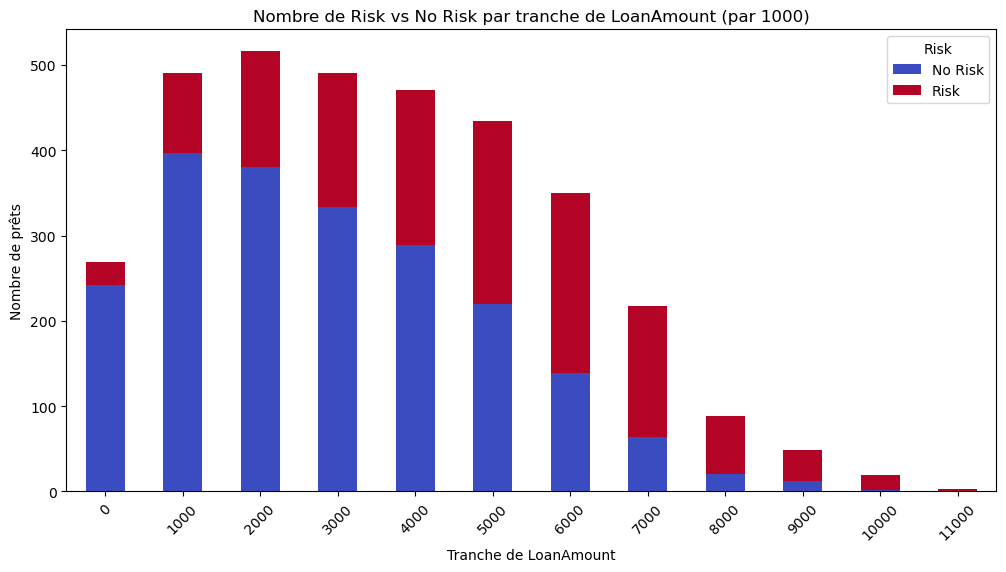

In [136]:
# Créer une nouvelle colonne pour regrouper les montants des prêts par tranches de 1000
t = train_df[train_df["LoanAmount"]!=250]
t["LoanAmount_Bin"] = (t["LoanAmount"] // 1000) * 1000

# Compter le nombre de risques par tranche de prêt
loan_risk_count = t.groupby("LoanAmount_Bin")["Risk"].value_counts().unstack()

# Tracer le barplot empilé
loan_risk_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Nombre de Risk vs No Risk par tranche de LoanAmount (par 1000)")
plt.xlabel("Tranche de LoanAmount")
plt.ylabel("Nombre de prêts")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()

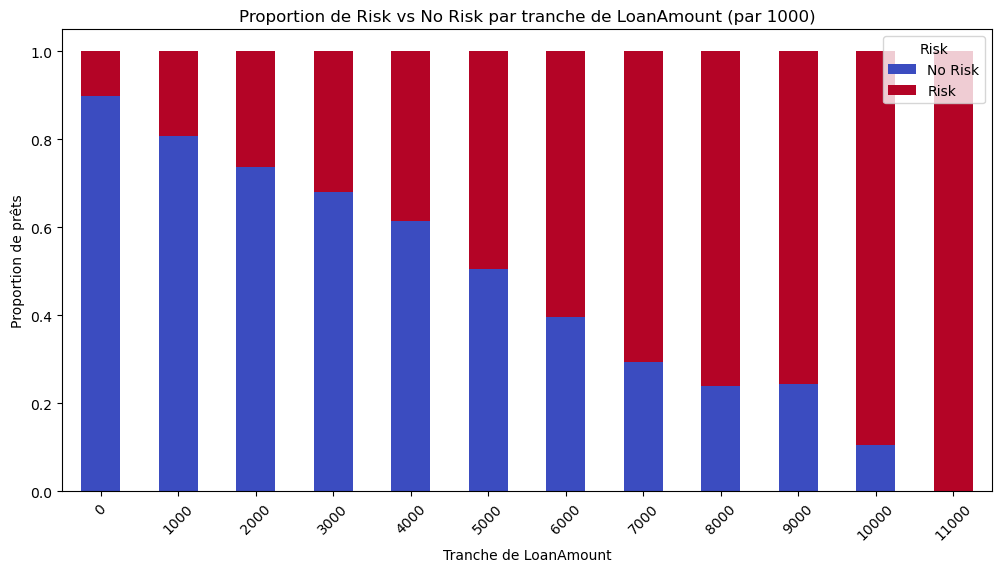

In [137]:
import matplotlib.pyplot as plt

# Créer une nouvelle colonne pour regrouper les montants des prêts par tranches de 1000
t = train_df[train_df["LoanAmount"] != 250]
t["LoanAmount_Bin"] = (t["LoanAmount"] // 1000) * 1000

# Calculer le nombre de risques par tranche de prêt
loan_risk_count = t.groupby("LoanAmount_Bin")["Risk"].value_counts(normalize=True).unstack()

# Tracer le barplot empilé avec les proportions
loan_risk_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion de Risk vs No Risk par tranche de LoanAmount (par 1000)")
plt.xlabel("Tranche de LoanAmount")
plt.ylabel("Proportion de prêts")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


C:\Users\pierr\AppData\Local\Temp\ipykernel_17380\1223892818.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_risk_count = t.groupby("LoanAmount_Bin")["Risk"].value_counts(normalize=True).unstack()


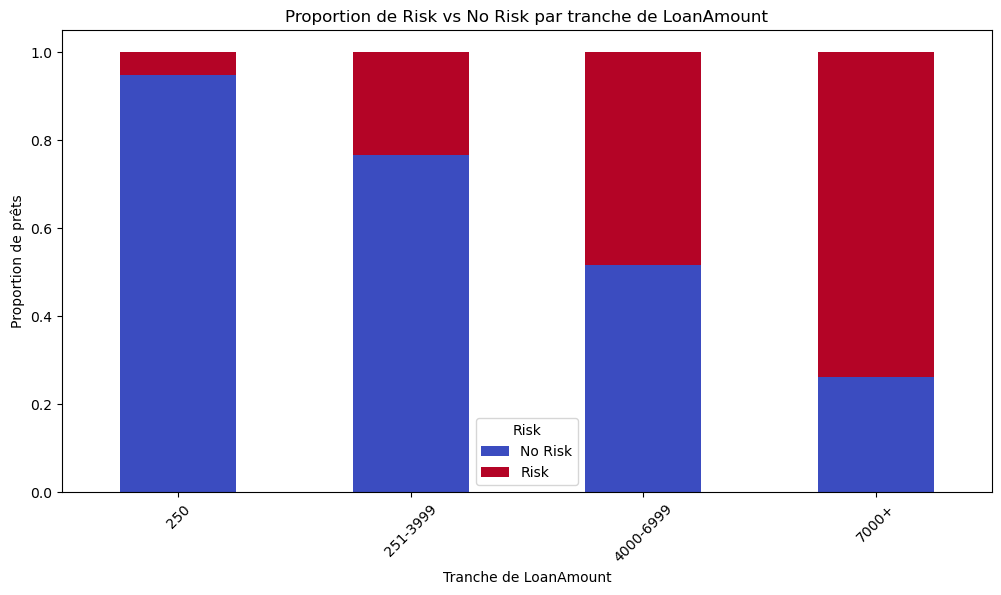

In [142]:
import pandas as pd
import matplotlib.pyplot as plt

# Définir les catégories personnalisées pour LoanAmount
bins = [0, 251, 4000, 7000, float('inf')]  # 250, 251-3999, 4000-6999, 7000+
labels = ['250', '251-3999', '4000-6999', '7000+']
t = train_df
# Créer une nouvelle colonne pour les catégories de LoanAmount
t["LoanAmount_Bin"] = pd.cut(t["LoanAmount"], bins=bins, labels=labels, right=False)

# Calculer la proportion de risques par tranche de LoanAmount
loan_risk_count = t.groupby("LoanAmount_Bin")["Risk"].value_counts(normalize=True).unstack()

# Tracer le barplot empilé avec les proportions
loan_risk_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Proportion de Risk vs No Risk par tranche de LoanAmount")
plt.xlabel("Tranche de LoanAmount")
plt.ylabel("Proportion de prêts")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()



C:\Users\pierr\AppData\Local\Temp\ipykernel_17380\3069773531.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_risk_count = t.groupby("LoanAmount_Bin")["Risk"].value_counts().unstack()


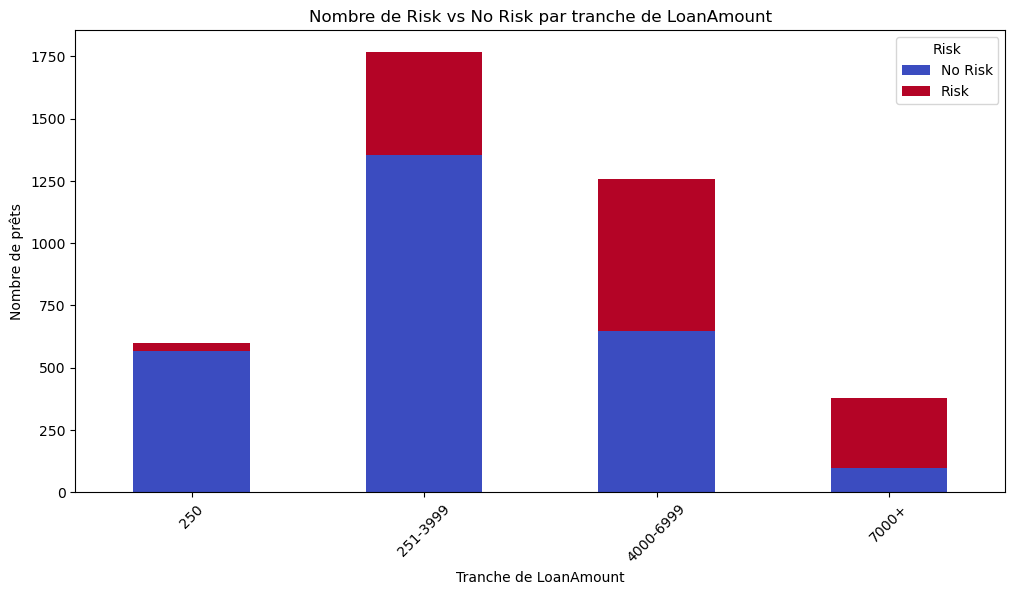

In [143]:
import pandas as pd
import matplotlib.pyplot as plt

# Définir les catégories personnalisées pour LoanAmount
bins = [0, 251, 4000, 7000, float('inf')]  # 250, 251-3999, 4000-6999, 7000+
labels = ['250', '251-3999', '4000-6999', '7000+']
t = train_df

# Créer une nouvelle colonne pour les catégories de LoanAmount
t["LoanAmount_Bin"] = pd.cut(t["LoanAmount"], bins=bins, labels=labels, right=False)

# Calculer le nombre de risques par tranche de LoanAmount
loan_risk_count = t.groupby("LoanAmount_Bin")["Risk"].value_counts().unstack()

# Tracer le barplot empilé avec les comptes
loan_risk_count.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="coolwarm")
plt.title("Nombre de Risk vs No Risk par tranche de LoanAmount")
plt.xlabel("Tranche de LoanAmount")
plt.ylabel("Nombre de prêts")
plt.xticks(rotation=45)
plt.legend(title="Risk")
plt.show()


# Submission 11 Strat 4 modeles

In [144]:

model_250 = HistGradientBoostingClassifier(
    max_iter=100, max_depth=5, learning_rate=0.07114061293853184, 
    l2_regularization=1.3702344526429108e-05, random_state=8
)

model_251_3999 = HistGradientBoostingClassifier(
    max_iter=100, max_depth=5, learning_rate=0.07114061293853184, 
    l2_regularization=1.3702344526429108e-05, random_state=8
)

model_4000_6999 = HistGradientBoostingClassifier(
    max_iter=100, max_depth=5, learning_rate=0.07114061293853184, 
    l2_regularization=1.3702344526429108e-05, random_state=8
)

model_7000_plus = HistGradientBoostingClassifier(
    max_iter=100, max_depth=5, learning_rate=0.07114061293853184, 
    l2_regularization=1.3702344526429108e-05, random_state=8
)

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 499): 0.45, (500, 999): 0.71, (1000, 1499): 0.59, (1500, 1999): 0.76,
    (2000, 2499): 0.77, (2500, 2999): 0.58, (3000, 3499): 0.58, (3500, 3999): 0.7,
    (4000, 4499): 0.74, (4500, 4999): 0.64, (5000, 5499): 0.67, (5500, 5999): 0.75,
    (6000, 6499): 0.66, (6500, 6999): 0.67, (7000, 7499): 0.62, (7500, 7999): 0.59,
    (8000, float('inf')): 0.75
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

# Séparer les données en 4 groupes selon LoanAmount
train_250 = train_df[train_df["LoanAmount"] == 250].copy()
train_251_3999 = train_df[(train_df["LoanAmount"] >= 251) & (train_df["LoanAmount"] <= 3999)].copy()
train_4000_6999 = train_df[(train_df["LoanAmount"] >= 4000) & (train_df["LoanAmount"] <= 6999)].copy()
train_7000_plus = train_df[train_df["LoanAmount"] >= 7000].copy()

test_250 = test_df[test_df["LoanAmount"] == 250].copy()
test_251_3999 = test_df[(test_df["LoanAmount"] >= 251) & (test_df["LoanAmount"] <= 3999)].copy()
test_4000_6999 = test_df[(test_df["LoanAmount"] >= 4000) & (test_df["LoanAmount"] <= 6999)].copy()
test_7000_plus = test_df[test_df["LoanAmount"] >= 7000].copy()

# Séparer X et y pour l'entraînement
X_train_250, y_train_250 = train_250.drop(columns=['Risk']), train_250['Risk']
X_train_251_3999, y_train_251_3999 = train_251_3999.drop(columns=['Risk']), train_251_3999['Risk']
X_train_4000_6999, y_train_4000_6999 = train_4000_6999.drop(columns=['Risk']), train_4000_6999['Risk']
X_train_7000_plus, y_train_7000_plus = train_7000_plus.drop(columns=['Risk']), train_7000_plus['Risk']

# Supprimer l'ID des données de test
X_test_250 = test_250.drop(columns=['Id'])
X_test_251_3999 = test_251_3999.drop(columns=['Id'])
X_test_4000_6999 = test_4000_6999.drop(columns=['Id'])
X_test_7000_plus = test_7000_plus.drop(columns=['Id'])

# Appliquer le preprocessing (fit uniquement sur le train)
preprocessor_250 = create_preprocessor(feature_engineering(X_train_250))
X_train_250_prep = preprocessor_250.fit_transform(feature_engineering(X_train_250))
X_test_250_prep = preprocessor_250.transform(feature_engineering(X_test_250))

preprocessor_251_3999 = create_preprocessor(feature_engineering(X_train_251_3999))
X_train_251_3999_prep = preprocessor_251_3999.fit_transform(feature_engineering(X_train_251_3999))
X_test_251_3999_prep = preprocessor_251_3999.transform(feature_engineering(X_test_251_3999))

preprocessor_4000_6999 = create_preprocessor(feature_engineering(X_train_4000_6999))
X_train_4000_6999_prep = preprocessor_4000_6999.fit_transform(feature_engineering(X_train_4000_6999))
X_test_4000_6999_prep = preprocessor_4000_6999.transform(feature_engineering(X_test_4000_6999))

preprocessor_7000_plus = create_preprocessor(feature_engineering(X_train_7000_plus))
X_train_7000_plus_prep = preprocessor_7000_plus.fit_transform(feature_engineering(X_train_7000_plus))
X_test_7000_plus_prep = preprocessor_7000_plus.transform(feature_engineering(X_test_7000_plus))

# Ajouter les sample weights
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights_250 = y_train_250.map(class_weights)
sample_weights_251_3999 = y_train_251_3999.map(class_weights)
sample_weights_4000_6999 = y_train_4000_6999.map(class_weights)
sample_weights_7000_plus = y_train_7000_plus.map(class_weights)

# Entraîner les modèles
model_250.fit(X_train_250_prep, y_train_250, sample_weight=sample_weights_250)
model_251_3999.fit(X_train_251_3999_prep, y_train_251_3999, sample_weight=sample_weights_251_3999)
model_4000_6999.fit(X_train_4000_6999_prep, y_train_4000_6999, sample_weight=sample_weights_4000_6999)
model_7000_plus.fit(X_train_7000_plus_prep, y_train_7000_plus, sample_weight=sample_weights_7000_plus)

# Prédictions et application des seuils optimaux
def apply_threshold(model, X_test_prep, X_test, thresholds):
    y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
    Risk_labels = np.empty(len(y_pred_proba), dtype=object)
    for (low, high), thresh in thresholds.items():
        mask = (X_test["LoanAmount"] >= low) & (X_test["LoanAmount"] <= high)
        Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")
    return Risk_labels

submission_250 = test_250.copy()
submission_250["Risk"] = apply_threshold(model_250, X_test_250_prep, X_test_250, best_thresholds)

submission_251_3999 = test_251_3999.copy()
submission_251_3999["Risk"] = apply_threshold(model_251_3999, X_test_251_3999_prep, X_test_251_3999, best_thresholds)

submission_4000_6999 = test_4000_6999.copy()
submission_4000_6999["Risk"] = apply_threshold(model_4000_6999, X_test_4000_6999_prep, X_test_4000_6999, best_thresholds)

submission_7000_plus = test_7000_plus.copy()
submission_7000_plus["Risk"] = apply_threshold(model_7000_plus, X_test_7000_plus_prep, X_test_7000_plus, best_thresholds)

# Fusionner et sauvegarder
submission = pd.concat([submission_250, submission_251_3999, submission_4000_6999, submission_7000_plus]).sort_index()
submission[['Id', 'Risk']].to_csv('submission_11.csv', index=False, sep=',', header=True)


# SUbmission 12

In [148]:
## tuning des modèles

In [152]:
# Désactiver les warnings SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
train_df = train_df[train_df["LoanAmount"] >= 7000].copy()


X = train_df.drop(columns=['Risk'])  
y = train_df['Risk']
X_transformed = feature_engineering(X)


def objective(trial):
    # Définir les hyperparamètres à tester
    max_iter = trial.suggest_int("max_iter", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1, log=True)
    l2_regularization = trial.suggest_float("l2_regularization", 1e-5, 1, log=True)

    # Initialiser le modèle avec les hyperparamètres suggérés
    model = HistGradientBoostingClassifier(
        max_iter=max_iter,
        max_depth=max_depth,
        learning_rate=learning_rate,
        l2_regularization=l2_regularization,
        random_state=8
    )

    # Définir la stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)
    cv_losses = []

    for train_index, val_index in skf.split(X_transformed, y):
        X_train_fold, X_val_fold = X_transformed.iloc[train_index], X_transformed.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        # Preprocessing
        preprocessor = create_preprocessor(X_train_fold)
        X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
        X_val_fold_prep = preprocessor.transform(X_val_fold)

        # Entraîner le modèle
        class_weights = {"No Risk": 1, "Risk": 1.1}
        sample_weights = y_train_fold.map(class_weights)
        model.fit(X_train_fold_prep, y_train_fold, sample_weights)

        # Prédictions avec les probabilités
        y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]
        # Prédictions et application des seuils optimaux

        Risk_labels = np.where(y_pred_proba > 0.71, "Risk", "No Risk")

        # Calculer la perte personnalisée pour ce fold
        submission = X_val_fold.copy()   
        submission["Risk"] = Risk_labels
        solution = X_val_fold.copy()  
        solution['Risk'] = y_val_fold
        custom_loss = score(solution, submission)
        
        # Ajouter le loss de ce fold à la liste des losses
        cv_losses.append(custom_loss)

    # Retourner la perte moyenne pour tous les folds
    return np.mean(cv_losses)

# Création de l'étude Optuna

def print_callback(study, trial):
    print(f"Trial {trial.number}: {trial.params} -> {trial.value}")


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=60, callbacks=[print_callback])

# Affichage des meilleurs hyperparamètres
print(f"Best hyperparameters : {study.best_params}")
print(f"Best custom loss : {study.best_value}")

[I 2025-03-29 22:35:38,079] A new study created in memory with name: no-name-8d9d62e5-02e0-41dc-a91f-95f98649dc70
[I 2025-03-29 22:35:38,818] Trial 0 finished with value: -53.853453210526325 and parameters: {'max_iter': 69, 'max_depth': 8, 'learning_rate': 0.037921358409887515, 'l2_regularization': 0.08386658286096556}. Best is trial 0 with value: -53.853453210526325.


Trial 0: {'max_iter': 69, 'max_depth': 8, 'learning_rate': 0.037921358409887515, 'l2_regularization': 0.08386658286096556} -> -53.853453210526325


[I 2025-03-29 22:35:40,453] Trial 1 finished with value: -49.023235631578956 and parameters: {'max_iter': 232, 'max_depth': 5, 'learning_rate': 0.04021962504802532, 'l2_regularization': 0.13945237097535523}. Best is trial 0 with value: -53.853453210526325.


Trial 1: {'max_iter': 232, 'max_depth': 5, 'learning_rate': 0.04021962504802532, 'l2_regularization': 0.13945237097535523} -> -49.023235631578956


[I 2025-03-29 22:35:41,853] Trial 2 finished with value: -54.76382868421052 and parameters: {'max_iter': 151, 'max_depth': 12, 'learning_rate': 0.017646954271699662, 'l2_regularization': 0.5393324659698265}. Best is trial 2 with value: -54.76382868421052.


Trial 2: {'max_iter': 151, 'max_depth': 12, 'learning_rate': 0.017646954271699662, 'l2_regularization': 0.5393324659698265} -> -54.76382868421052


[I 2025-03-29 22:35:43,011] Trial 3 finished with value: -52.52475931578948 and parameters: {'max_iter': 105, 'max_depth': 11, 'learning_rate': 0.020095118316848567, 'l2_regularization': 0.06198680651892022}. Best is trial 2 with value: -54.76382868421052.


Trial 3: {'max_iter': 105, 'max_depth': 11, 'learning_rate': 0.020095118316848567, 'l2_regularization': 0.06198680651892022} -> -52.52475931578948


[I 2025-03-29 22:35:43,854] Trial 4 finished with value: -54.040762000000015 and parameters: {'max_iter': 70, 'max_depth': 7, 'learning_rate': 0.03674408449717556, 'l2_regularization': 0.0042709514932041575}. Best is trial 2 with value: -54.76382868421052.


Trial 4: {'max_iter': 70, 'max_depth': 7, 'learning_rate': 0.03674408449717556, 'l2_regularization': 0.0042709514932041575} -> -54.040762000000015


[I 2025-03-29 22:35:50,449] Trial 5 finished with value: -37.433291105263166 and parameters: {'max_iter': 380, 'max_depth': 11, 'learning_rate': 0.053411894768341316, 'l2_regularization': 0.0001731485290318663}. Best is trial 2 with value: -54.76382868421052.


Trial 5: {'max_iter': 380, 'max_depth': 11, 'learning_rate': 0.053411894768341316, 'l2_regularization': 0.0001731485290318663} -> -37.433291105263166


[I 2025-03-29 22:35:57,669] Trial 6 finished with value: -41.74466342105264 and parameters: {'max_iter': 499, 'max_depth': 5, 'learning_rate': 0.017250571887334688, 'l2_regularization': 0.00135639046192813}. Best is trial 2 with value: -54.76382868421052.


Trial 6: {'max_iter': 499, 'max_depth': 5, 'learning_rate': 0.017250571887334688, 'l2_regularization': 0.00135639046192813} -> -41.74466342105264


[I 2025-03-29 22:35:59,535] Trial 7 finished with value: -53.328666 and parameters: {'max_iter': 87, 'max_depth': 6, 'learning_rate': 0.011127461054429352, 'l2_regularization': 8.505263515461343e-05}. Best is trial 2 with value: -54.76382868421052.


Trial 7: {'max_iter': 87, 'max_depth': 6, 'learning_rate': 0.011127461054429352, 'l2_regularization': 8.505263515461343e-05} -> -53.328666


[I 2025-03-29 22:36:04,637] Trial 8 finished with value: -56.66708831578948 and parameters: {'max_iter': 322, 'max_depth': 8, 'learning_rate': 0.010938116102526934, 'l2_regularization': 0.3198207937326963}. Best is trial 8 with value: -56.66708831578948.


Trial 8: {'max_iter': 322, 'max_depth': 8, 'learning_rate': 0.010938116102526934, 'l2_regularization': 0.3198207937326963} -> -56.66708831578948


[I 2025-03-29 22:36:10,801] Trial 9 finished with value: -37.31170868421053 and parameters: {'max_iter': 434, 'max_depth': 13, 'learning_rate': 0.03459350755564092, 'l2_regularization': 0.009225391622725825}. Best is trial 8 with value: -56.66708831578948.


Trial 9: {'max_iter': 434, 'max_depth': 13, 'learning_rate': 0.03459350755564092, 'l2_regularization': 0.009225391622725825} -> -37.31170868421053


[I 2025-03-29 22:36:13,277] Trial 10 finished with value: -43.25639489473684 and parameters: {'max_iter': 313, 'max_depth': 3, 'learning_rate': 0.09001876832637423, 'l2_regularization': 0.8817874097490058}. Best is trial 8 with value: -56.66708831578948.


Trial 10: {'max_iter': 313, 'max_depth': 3, 'learning_rate': 0.09001876832637423, 'l2_regularization': 0.8817874097490058} -> -43.25639489473684


[I 2025-03-29 22:36:16,316] Trial 11 finished with value: -55.334850578947375 and parameters: {'max_iter': 207, 'max_depth': 15, 'learning_rate': 0.010236170604015474, 'l2_regularization': 0.6298562521553572}. Best is trial 8 with value: -56.66708831578948.


Trial 11: {'max_iter': 207, 'max_depth': 15, 'learning_rate': 0.010236170604015474, 'l2_regularization': 0.6298562521553572} -> -55.334850578947375


[I 2025-03-29 22:36:20,337] Trial 12 finished with value: -54.04601689473685 and parameters: {'max_iter': 256, 'max_depth': 14, 'learning_rate': 0.010097990332282415, 'l2_regularization': 0.020523140221768415}. Best is trial 8 with value: -56.66708831578948.


Trial 12: {'max_iter': 256, 'max_depth': 14, 'learning_rate': 0.010097990332282415, 'l2_regularization': 0.020523140221768415} -> -54.04601689473685


[I 2025-03-29 22:36:26,360] Trial 13 finished with value: -54.75404847368422 and parameters: {'max_iter': 201, 'max_depth': 15, 'learning_rate': 0.013832755058307727, 'l2_regularization': 1.2755068967043557e-05}. Best is trial 8 with value: -56.66708831578948.


Trial 13: {'max_iter': 201, 'max_depth': 15, 'learning_rate': 0.013832755058307727, 'l2_regularization': 1.2755068967043557e-05} -> -54.75404847368422


[I 2025-03-29 22:36:32,250] Trial 14 finished with value: -43.55995942105264 and parameters: {'max_iter': 325, 'max_depth': 9, 'learning_rate': 0.023799376766003688, 'l2_regularization': 0.2814437816581002}. Best is trial 8 with value: -56.66708831578948.


Trial 14: {'max_iter': 325, 'max_depth': 9, 'learning_rate': 0.023799376766003688, 'l2_regularization': 0.2814437816581002} -> -43.55995942105264


[I 2025-03-29 22:36:34,665] Trial 15 finished with value: -53.70687800000002 and parameters: {'max_iter': 160, 'max_depth': 10, 'learning_rate': 0.01364107506404847, 'l2_regularization': 0.03393821430387796}. Best is trial 8 with value: -56.66708831578948.


Trial 15: {'max_iter': 160, 'max_depth': 10, 'learning_rate': 0.01364107506404847, 'l2_regularization': 0.03393821430387796} -> -53.70687800000002


[I 2025-03-29 22:36:39,185] Trial 16 finished with value: -50.797255210526316 and parameters: {'max_iter': 321, 'max_depth': 9, 'learning_rate': 0.02538077200962189, 'l2_regularization': 0.0012967489854161106}. Best is trial 8 with value: -56.66708831578948.


Trial 16: {'max_iter': 321, 'max_depth': 9, 'learning_rate': 0.02538077200962189, 'l2_regularization': 0.0012967489854161106} -> -50.797255210526316


[I 2025-03-29 22:36:46,473] Trial 17 finished with value: -47.91867373684211 and parameters: {'max_iter': 378, 'max_depth': 15, 'learning_rate': 0.01373197581370389, 'l2_regularization': 0.24650333386219328}. Best is trial 8 with value: -56.66708831578948.


Trial 17: {'max_iter': 378, 'max_depth': 15, 'learning_rate': 0.01373197581370389, 'l2_regularization': 0.24650333386219328} -> -47.91867373684211


[I 2025-03-29 22:36:49,041] Trial 18 finished with value: -48.98556378947369 and parameters: {'max_iter': 211, 'max_depth': 3, 'learning_rate': 0.0653573413589555, 'l2_regularization': 0.9417960933207793}. Best is trial 8 with value: -56.66708831578948.


Trial 18: {'max_iter': 211, 'max_depth': 3, 'learning_rate': 0.0653573413589555, 'l2_regularization': 0.9417960933207793} -> -48.98556378947369


[I 2025-03-29 22:36:53,011] Trial 19 finished with value: -53.25122868421054 and parameters: {'max_iter': 274, 'max_depth': 7, 'learning_rate': 0.011853000683418356, 'l2_regularization': 0.015075674826625262}. Best is trial 8 with value: -56.66708831578948.


Trial 19: {'max_iter': 274, 'max_depth': 7, 'learning_rate': 0.011853000683418356, 'l2_regularization': 0.015075674826625262} -> -53.25122868421054


[I 2025-03-29 22:36:58,499] Trial 20 finished with value: -43.95339352631579 and parameters: {'max_iter': 370, 'max_depth': 13, 'learning_rate': 0.026198304447855196, 'l2_regularization': 0.17274788657942738}. Best is trial 8 with value: -56.66708831578948.


Trial 20: {'max_iter': 370, 'max_depth': 13, 'learning_rate': 0.026198304447855196, 'l2_regularization': 0.17274788657942738} -> -43.95339352631579


[I 2025-03-29 22:37:01,418] Trial 21 finished with value: -54.54270447368422 and parameters: {'max_iter': 150, 'max_depth': 12, 'learning_rate': 0.017503323839447426, 'l2_regularization': 0.6589650114896627}. Best is trial 8 with value: -56.66708831578948.


Trial 21: {'max_iter': 150, 'max_depth': 12, 'learning_rate': 0.017503323839447426, 'l2_regularization': 0.6589650114896627} -> -54.54270447368422


[I 2025-03-29 22:37:03,687] Trial 22 finished with value: -54.173963263157894 and parameters: {'max_iter': 158, 'max_depth': 13, 'learning_rate': 0.01789344120560851, 'l2_regularization': 0.3471526772049122}. Best is trial 8 with value: -56.66708831578948.


Trial 22: {'max_iter': 158, 'max_depth': 13, 'learning_rate': 0.01789344120560851, 'l2_regularization': 0.3471526772049122} -> -54.173963263157894


[I 2025-03-29 22:37:06,389] Trial 23 finished with value: -52.849598 and parameters: {'max_iter': 162, 'max_depth': 11, 'learning_rate': 0.014451842645584249, 'l2_regularization': 0.05818133195074248}. Best is trial 8 with value: -56.66708831578948.


Trial 23: {'max_iter': 162, 'max_depth': 11, 'learning_rate': 0.014451842645584249, 'l2_regularization': 0.05818133195074248} -> -52.849598


[I 2025-03-29 22:37:09,541] Trial 24 finished with value: -53.874572947368435 and parameters: {'max_iter': 196, 'max_depth': 14, 'learning_rate': 0.010421487759560779, 'l2_regularization': 0.48521062477023447}. Best is trial 8 with value: -56.66708831578948.


Trial 24: {'max_iter': 196, 'max_depth': 14, 'learning_rate': 0.010421487759560779, 'l2_regularization': 0.48521062477023447} -> -53.874572947368435


[I 2025-03-29 22:37:11,643] Trial 25 finished with value: -55.44546600000001 and parameters: {'max_iter': 129, 'max_depth': 10, 'learning_rate': 0.02073608681385448, 'l2_regularization': 0.12821382081391905}. Best is trial 8 with value: -56.66708831578948.


Trial 25: {'max_iter': 129, 'max_depth': 10, 'learning_rate': 0.02073608681385448, 'l2_regularization': 0.12821382081391905} -> -55.44546600000001


[I 2025-03-29 22:37:14,096] Trial 26 finished with value: -52.88463800000001 and parameters: {'max_iter': 116, 'max_depth': 8, 'learning_rate': 0.02133083977719627, 'l2_regularization': 0.11681501278741283}. Best is trial 8 with value: -56.66708831578948.


Trial 26: {'max_iter': 116, 'max_depth': 8, 'learning_rate': 0.02133083977719627, 'l2_regularization': 0.11681501278741283} -> -52.88463800000001


[I 2025-03-29 22:37:17,798] Trial 27 finished with value: -44.673781315789476 and parameters: {'max_iter': 233, 'max_depth': 10, 'learning_rate': 0.02830849557910938, 'l2_regularization': 0.00677809483579497}. Best is trial 8 with value: -56.66708831578948.


Trial 27: {'max_iter': 233, 'max_depth': 10, 'learning_rate': 0.02830849557910938, 'l2_regularization': 0.00677809483579497} -> -44.673781315789476


[I 2025-03-29 22:37:23,743] Trial 28 finished with value: -51.710668684210546 and parameters: {'max_iter': 279, 'max_depth': 8, 'learning_rate': 0.011817965738360747, 'l2_regularization': 0.04148954493903509}. Best is trial 8 with value: -56.66708831578948.


Trial 28: {'max_iter': 279, 'max_depth': 8, 'learning_rate': 0.011817965738360747, 'l2_regularization': 0.04148954493903509} -> -51.710668684210546


[I 2025-03-29 22:37:25,339] Trial 29 finished with value: -50.79125536842106 and parameters: {'max_iter': 59, 'max_depth': 7, 'learning_rate': 0.015327917689468791, 'l2_regularization': 0.10675464586001845}. Best is trial 8 with value: -56.66708831578948.


Trial 29: {'max_iter': 59, 'max_depth': 7, 'learning_rate': 0.015327917689468791, 'l2_regularization': 0.10675464586001845} -> -50.79125536842106


[I 2025-03-29 22:37:26,623] Trial 30 finished with value: -58.8663822631579 and parameters: {'max_iter': 122, 'max_depth': 9, 'learning_rate': 0.012586794551365093, 'l2_regularization': 0.0016479276275305915}. Best is trial 30 with value: -58.8663822631579.


Trial 30: {'max_iter': 122, 'max_depth': 9, 'learning_rate': 0.012586794551365093, 'l2_regularization': 0.0016479276275305915} -> -58.8663822631579


[I 2025-03-29 22:37:29,362] Trial 31 finished with value: -56.78989910526317 and parameters: {'max_iter': 122, 'max_depth': 9, 'learning_rate': 0.012547360059929777, 'l2_regularization': 0.0014645167982731684}. Best is trial 30 with value: -58.8663822631579.


Trial 31: {'max_iter': 122, 'max_depth': 9, 'learning_rate': 0.012547360059929777, 'l2_regularization': 0.0014645167982731684} -> -56.78989910526317


[I 2025-03-29 22:37:32,046] Trial 32 finished with value: -54.13415394736843 and parameters: {'max_iter': 103, 'max_depth': 10, 'learning_rate': 0.012310722635610259, 'l2_regularization': 0.001278325455995805}. Best is trial 30 with value: -58.8663822631579.


Trial 32: {'max_iter': 103, 'max_depth': 10, 'learning_rate': 0.012310722635610259, 'l2_regularization': 0.001278325455995805} -> -54.13415394736843


[I 2025-03-29 22:37:33,880] Trial 33 finished with value: -54.06409210526317 and parameters: {'max_iter': 126, 'max_depth': 8, 'learning_rate': 0.015667182590132316, 'l2_regularization': 0.00043643955281059716}. Best is trial 30 with value: -58.8663822631579.


Trial 33: {'max_iter': 126, 'max_depth': 8, 'learning_rate': 0.015667182590132316, 'l2_regularization': 0.00043643955281059716} -> -54.06409210526317


[I 2025-03-29 22:37:34,696] Trial 34 finished with value: -56.81792415789473 and parameters: {'max_iter': 52, 'max_depth': 9, 'learning_rate': 0.021309854473635342, 'l2_regularization': 0.0004614888588422889}. Best is trial 30 with value: -58.8663822631579.


Trial 34: {'max_iter': 52, 'max_depth': 9, 'learning_rate': 0.021309854473635342, 'l2_regularization': 0.0004614888588422889} -> -56.81792415789473


[I 2025-03-29 22:37:36,814] Trial 35 finished with value: -53.625978578947375 and parameters: {'max_iter': 78, 'max_depth': 9, 'learning_rate': 0.047786153247446304, 'l2_regularization': 0.00046595879568675383}. Best is trial 30 with value: -58.8663822631579.


Trial 35: {'max_iter': 78, 'max_depth': 9, 'learning_rate': 0.047786153247446304, 'l2_regularization': 0.00046595879568675383} -> -53.625978578947375


[I 2025-03-29 22:37:38,199] Trial 36 finished with value: -56.499480157894745 and parameters: {'max_iter': 55, 'max_depth': 6, 'learning_rate': 0.030559958337056197, 'l2_regularization': 0.002727475534138385}. Best is trial 30 with value: -58.8663822631579.


Trial 36: {'max_iter': 55, 'max_depth': 6, 'learning_rate': 0.030559958337056197, 'l2_regularization': 0.002727475534138385} -> -56.499480157894745


[I 2025-03-29 22:37:40,332] Trial 37 finished with value: -53.40969184210527 and parameters: {'max_iter': 96, 'max_depth': 9, 'learning_rate': 0.012570553642118482, 'l2_regularization': 0.00041009119307395614}. Best is trial 30 with value: -58.8663822631579.


Trial 37: {'max_iter': 96, 'max_depth': 9, 'learning_rate': 0.012570553642118482, 'l2_regularization': 0.00041009119307395614} -> -53.40969184210527


[I 2025-03-29 22:37:40,864] Trial 38 finished with value: -53.24040926315789 and parameters: {'max_iter': 50, 'max_depth': 6, 'learning_rate': 0.01905910859304625, 'l2_regularization': 8.27575353392317e-05}. Best is trial 30 with value: -58.8663822631579.


Trial 38: {'max_iter': 50, 'max_depth': 6, 'learning_rate': 0.01905910859304625, 'l2_regularization': 8.27575353392317e-05} -> -53.24040926315789


[I 2025-03-29 22:37:44,271] Trial 39 finished with value: -54.75404847368422 and parameters: {'max_iter': 182, 'max_depth': 7, 'learning_rate': 0.01563316486854244, 'l2_regularization': 0.0034524709478587676}. Best is trial 30 with value: -58.8663822631579.


Trial 39: {'max_iter': 182, 'max_depth': 7, 'learning_rate': 0.01563316486854244, 'l2_regularization': 0.0034524709478587676} -> -54.75404847368422


[I 2025-03-29 22:37:50,509] Trial 40 finished with value: -44.81205842105263 and parameters: {'max_iter': 418, 'max_depth': 11, 'learning_rate': 0.02269315324741071, 'l2_regularization': 0.00016751377296630136}. Best is trial 30 with value: -58.8663822631579.


Trial 40: {'max_iter': 418, 'max_depth': 11, 'learning_rate': 0.02269315324741071, 'l2_regularization': 0.00016751377296630136} -> -44.81205842105263


[I 2025-03-29 22:37:51,678] Trial 41 finished with value: -51.095072473684226 and parameters: {'max_iter': 74, 'max_depth': 5, 'learning_rate': 0.04076591014917961, 'l2_regularization': 0.0008144034464021648}. Best is trial 30 with value: -58.8663822631579.


Trial 41: {'max_iter': 74, 'max_depth': 5, 'learning_rate': 0.04076591014917961, 'l2_regularization': 0.0008144034464021648} -> -51.095072473684226


[I 2025-03-29 22:37:53,278] Trial 42 finished with value: -53.455732263157905 and parameters: {'max_iter': 136, 'max_depth': 4, 'learning_rate': 0.034143566662383405, 'l2_regularization': 0.00378620892119819}. Best is trial 30 with value: -58.8663822631579.


Trial 42: {'max_iter': 136, 'max_depth': 4, 'learning_rate': 0.034143566662383405, 'l2_regularization': 0.00378620892119819} -> -53.455732263157905


[I 2025-03-29 22:37:54,762] Trial 43 finished with value: -53.1589097894737 and parameters: {'max_iter': 89, 'max_depth': 6, 'learning_rate': 0.028551724301442417, 'l2_regularization': 0.0019713926876646936}. Best is trial 30 with value: -58.8663822631579.


Trial 43: {'max_iter': 89, 'max_depth': 6, 'learning_rate': 0.028551724301442417, 'l2_regularization': 0.0019713926876646936} -> -53.1589097894737


[I 2025-03-29 22:37:55,712] Trial 44 finished with value: -45.572225736842114 and parameters: {'max_iter': 50, 'max_depth': 8, 'learning_rate': 0.011209361426349823, 'l2_regularization': 0.006436950926661284}. Best is trial 30 with value: -58.8663822631579.


Trial 44: {'max_iter': 50, 'max_depth': 8, 'learning_rate': 0.011209361426349823, 'l2_regularization': 0.006436950926661284} -> -45.572225736842114


[I 2025-03-29 22:37:57,281] Trial 45 finished with value: -52.58164173684211 and parameters: {'max_iter': 106, 'max_depth': 6, 'learning_rate': 0.04180107950749443, 'l2_regularization': 0.00227276807236714}. Best is trial 30 with value: -58.8663822631579.


Trial 45: {'max_iter': 106, 'max_depth': 6, 'learning_rate': 0.04180107950749443, 'l2_regularization': 0.00227276807236714} -> -52.58164173684211


[I 2025-03-29 22:37:58,516] Trial 46 finished with value: -50.15708615789474 and parameters: {'max_iter': 71, 'max_depth': 9, 'learning_rate': 0.06721652475103683, 'l2_regularization': 0.00023770502492050606}. Best is trial 30 with value: -58.8663822631579.


Trial 46: {'max_iter': 71, 'max_depth': 9, 'learning_rate': 0.06721652475103683, 'l2_regularization': 0.00023770502492050606} -> -50.15708615789474


[I 2025-03-29 22:38:04,854] Trial 47 finished with value: -48.26860094736843 and parameters: {'max_iter': 359, 'max_depth': 7, 'learning_rate': 0.03064761024952862, 'l2_regularization': 0.0006778697972212774}. Best is trial 30 with value: -58.8663822631579.


Trial 47: {'max_iter': 359, 'max_depth': 7, 'learning_rate': 0.03064761024952862, 'l2_regularization': 0.0006778697972212774} -> -48.26860094736843


[I 2025-03-29 22:38:09,261] Trial 48 finished with value: -51.774564736842116 and parameters: {'max_iter': 344, 'max_depth': 8, 'learning_rate': 0.012840029757523937, 'l2_regularization': 3.0381155046692058e-05}. Best is trial 30 with value: -58.8663822631579.


Trial 48: {'max_iter': 344, 'max_depth': 8, 'learning_rate': 0.012840029757523937, 'l2_regularization': 3.0381155046692058e-05} -> -51.774564736842116


[I 2025-03-29 22:38:13,328] Trial 49 finished with value: -53.29496068421054 and parameters: {'max_iter': 284, 'max_depth': 4, 'learning_rate': 0.01656689391333995, 'l2_regularization': 0.0017385459174092022}. Best is trial 30 with value: -58.8663822631579.


Trial 49: {'max_iter': 284, 'max_depth': 4, 'learning_rate': 0.01656689391333995, 'l2_regularization': 0.0017385459174092022} -> -53.29496068421054


[I 2025-03-29 22:38:16,847] Trial 50 finished with value: -48.77511352631579 and parameters: {'max_iter': 299, 'max_depth': 5, 'learning_rate': 0.018795165722742355, 'l2_regularization': 0.01564069500436197}. Best is trial 30 with value: -58.8663822631579.


Trial 50: {'max_iter': 299, 'max_depth': 5, 'learning_rate': 0.018795165722742355, 'l2_regularization': 0.01564069500436197} -> -48.77511352631579


[I 2025-03-29 22:38:19,528] Trial 51 finished with value: -51.70187184210526 and parameters: {'max_iter': 127, 'max_depth': 10, 'learning_rate': 0.0204402584719083, 'l2_regularization': 0.0007897867708248657}. Best is trial 30 with value: -58.8663822631579.


Trial 51: {'max_iter': 127, 'max_depth': 10, 'learning_rate': 0.0204402584719083, 'l2_regularization': 0.0007897867708248657} -> -51.70187184210526


[I 2025-03-29 22:38:23,260] Trial 52 finished with value: -53.976042578947386 and parameters: {'max_iter': 139, 'max_depth': 10, 'learning_rate': 0.02337812613405357, 'l2_regularization': 0.0058003805389017235}. Best is trial 30 with value: -58.8663822631579.


Trial 52: {'max_iter': 139, 'max_depth': 10, 'learning_rate': 0.02337812613405357, 'l2_regularization': 0.0058003805389017235} -> -53.976042578947386


[I 2025-03-29 22:38:28,664] Trial 53 finished with value: -53.837583842105275 and parameters: {'max_iter': 236, 'max_depth': 9, 'learning_rate': 0.010924827148430022, 'l2_regularization': 0.011152926531666083}. Best is trial 30 with value: -58.8663822631579.


Trial 53: {'max_iter': 236, 'max_depth': 9, 'learning_rate': 0.010924827148430022, 'l2_regularization': 0.011152926531666083} -> -53.837583842105275


[I 2025-03-29 22:38:30,413] Trial 54 finished with value: -55.20754052631579 and parameters: {'max_iter': 87, 'max_depth': 11, 'learning_rate': 0.01432245305842205, 'l2_regularization': 0.002736240495779813}. Best is trial 30 with value: -58.8663822631579.


Trial 54: {'max_iter': 87, 'max_depth': 11, 'learning_rate': 0.01432245305842205, 'l2_regularization': 0.002736240495779813} -> -55.20754052631579


[I 2025-03-29 22:38:33,011] Trial 55 finished with value: -45.68988931578947 and parameters: {'max_iter': 180, 'max_depth': 10, 'learning_rate': 0.03295138314298486, 'l2_regularization': 0.0002189120139611403}. Best is trial 30 with value: -58.8663822631579.


Trial 55: {'max_iter': 180, 'max_depth': 10, 'learning_rate': 0.03295138314298486, 'l2_regularization': 0.0002189120139611403} -> -45.68988931578947


[I 2025-03-29 22:38:34,679] Trial 56 finished with value: -50.094838842105275 and parameters: {'max_iter': 114, 'max_depth': 11, 'learning_rate': 0.03696261050526278, 'l2_regularization': 0.001163843462406302}. Best is trial 30 with value: -58.8663822631579.


Trial 56: {'max_iter': 114, 'max_depth': 11, 'learning_rate': 0.03696261050526278, 'l2_regularization': 0.001163843462406302} -> -50.094838842105275


[I 2025-03-29 22:38:35,879] Trial 57 finished with value: -50.213138157894754 and parameters: {'max_iter': 72, 'max_depth': 12, 'learning_rate': 0.010027290207706584, 'l2_regularization': 0.18486505418295301}. Best is trial 30 with value: -58.8663822631579.


Trial 57: {'max_iter': 72, 'max_depth': 12, 'learning_rate': 0.010027290207706584, 'l2_regularization': 0.18486505418295301} -> -50.213138157894754


[I 2025-03-29 22:38:40,951] Trial 58 finished with value: -48.66593589473685 and parameters: {'max_iter': 416, 'max_depth': 8, 'learning_rate': 0.013199262184653194, 'l2_regularization': 0.004879166090956943}. Best is trial 30 with value: -58.8663822631579.


Trial 58: {'max_iter': 416, 'max_depth': 8, 'learning_rate': 0.013199262184653194, 'l2_regularization': 0.004879166090956943} -> -48.66593589473685


[I 2025-03-29 22:38:44,388] Trial 59 finished with value: -44.79477015789474 and parameters: {'max_iter': 260, 'max_depth': 9, 'learning_rate': 0.02082551932306218, 'l2_regularization': 0.027263212888874913}. Best is trial 30 with value: -58.8663822631579.


Trial 59: {'max_iter': 260, 'max_depth': 9, 'learning_rate': 0.02082551932306218, 'l2_regularization': 0.027263212888874913} -> -44.79477015789474
Best hyperparameters : {'max_iter': 122, 'max_depth': 9, 'learning_rate': 0.012586794551365093, 'l2_regularization': 0.0016479276275305915}
Best custom loss : -58.8663822631579


In [12]:
train_df = pd.read_csv("german_credit_train.csv",header=0,sep=',')
train_df = train_df[train_df["LoanAmount"] >= 7000].copy()

# 1) Séparer les features et la cible
X = train_df.drop(columns=['Risk'])  # Supposons que 'Risk' est la variable cible
y = train_df['Risk']

X_train_transformed = feature_engineering(X)

# Définition du modèle
model_7000_plus = HistGradientBoostingClassifier(
    max_iter=122, max_depth=9, learning_rate=0.012586794551365093, 
    l2_regularization=0.0016479276275305915, random_state=8
)

# Définition des intervalles de LoanAmount par tranche de 1000
intervals = [(i, i + 999) for i in range(7000, 8000, 1000)] + [(8000, float('inf'))]
#intervals = [(0,250)]

# Génération des seuils possibles (de 0.01 à 1.00 par pas de 0.01)
threshold_values = [0.4 + 0.01 * i for i in range(1, 41)]

# Initialisation des seuils à 0.05 (valeur par défaut)
best_thresholds = {interval: 0.05 for interval in intervals}
best_loss = float('inf')

# Définir la stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=8)

# Optimisation des seuils
for interval in intervals:
    print(f"\n🔍 Optimisation pour l'intervalle {interval}")
    best_threshold_for_interval = best_thresholds[interval]
    
    for tresh in threshold_values:
        current_thresholds = best_thresholds.copy()
        current_thresholds[interval] = tresh

        cv_losses = []

        # Boucle sur les folds
        for train_index, val_index in skf.split(X_train_transformed, y):
            X_train_fold, X_val_fold = X_train_transformed.iloc[train_index], X_train_transformed.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            # Preprocessing
            preprocessor = create_preprocessor(X_train_fold)
            X_train_fold_prep = preprocessor.fit_transform(X_train_fold)
            X_val_fold_prep = preprocessor.transform(X_val_fold)

            # Entraîner le modèle
            class_weights = {"No Risk": 1, "Risk": 1.1}
            sample_weights = y_train_fold.map(class_weights)
            model.fit(X_train_fold_prep, y_train_fold,sample_weight=sample_weights)
            y_pred_proba = model.predict_proba(X_val_fold_prep)[:, 1]

            Risk_labels = np.empty(len(y_pred_proba), dtype=object)

            for (low, high), thresh in current_thresholds.items():
                mask = (X_val_fold["LoanAmount"] >= low) & (X_val_fold["LoanAmount"] <= high)
                Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")



            submission = X_val_fold.copy()
            submission['Risk'] = Risk_labels
            solution = X_val_fold.copy()
            solution['Risk'] = y_val_fold
            custom_loss = score(solution, submission)
            cv_losses.append(custom_loss)

        avg_loss = np.mean(cv_losses)
        
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_threshold_for_interval = tresh

    best_thresholds[interval] = best_threshold_for_interval
    print(f"✅ Meilleur seuil pour {interval}: {best_threshold_for_interval:.2f}")

# Affichage des résultats globaux
print("\n🔹 Meilleure configuration de thresholds trouvée :")
print(best_thresholds)
print(f"Custom Loss Moyenne : {best_loss:.4f}")


🔍 Optimisation pour l'intervalle (7000, 7999)
✅ Meilleur seuil pour (7000, 7999): 0.75

🔍 Optimisation pour l'intervalle (8000, inf)
✅ Meilleur seuil pour (8000, inf): 0.77

🔹 Meilleure configuration de thresholds trouvée :
{(7000, 7999): 0.75, (8000, inf): 0.77}
Custom Loss Moyenne : -65.2881


In [ ]:
🔍 Optimisation pour l'intervalle (0, 250)
✅ Meilleur seuil pour (0, 250): 0.67

🔍 Optimisation pour l'intervalle (251, 999)
✅ Meilleur seuil pour (251, 999): 0.63

🔍 Optimisation pour l'intervalle (1000, 1999)
✅ Meilleur seuil pour (1000, 1999): 0.72

🔍 Optimisation pour l'intervalle (2000, 2999)
✅ Meilleur seuil pour (2000, 2999): 0.60

🔍 Optimisation pour l'intervalle (3000, 3999)
✅ Meilleur seuil pour (3000, 3999): 0.72

🔍 Optimisation pour l'intervalle (4000, 4999)
✅ Meilleur seuil pour (4000, 4999): 0.72

🔍 Optimisation pour l'intervalle (5000, 5999)
✅ Meilleur seuil pour (5000, 5999): 0.76

🔍 Optimisation pour l'intervalle (6000, 6999)
✅ Meilleur seuil pour (6000, 6999): 0.71

🔍 Optimisation pour l'intervalle (7000, 7999)
✅ Meilleur seuil pour (7000, 7999): 0.75

🔍 Optimisation pour l'intervalle (8000, inf)
✅ Meilleur seuil pour (8000, inf): 0.77





In [13]:

model_250 = HistGradientBoostingClassifier(
    max_iter=234, max_depth=7, learning_rate=0.018776491396919618, 
    l2_regularization=2.745689392230923e-05, random_state=8
)

model_251_3999 = HistGradientBoostingClassifier(
    max_iter=266, max_depth=3, learning_rate=0.029251167511661843, 
    l2_regularization=0.01710427734126001, random_state=8
)

model_4000_6999 = HistGradientBoostingClassifier(
    max_iter=182, max_depth=9, learning_rate=0.01360055646248309, 
    l2_regularization=0.02320238535421819, random_state=8
)

model_7000_plus = HistGradientBoostingClassifier(
    max_iter=122, max_depth=9, learning_rate=0.012586794551365093, 
    l2_regularization=0.0016479276275305915, random_state=8
)

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 499): 0.71, (500, 999): 0.71, (1000, 1499): 0.71, (1500, 1999): 0.71,
    (2000, 2499): 0.71, (2500, 2999): 0.71, (3000, 3499): 0.71, (3500, 3999): 0.71,
    (4000, 4499): 0.71, (4500, 4999): 0.71, (5000, 5499): 0.71, (5500, 5999): 0.71,
    (6000, 6499): 0.71, (6500, 6999): 0.71, (7000, 7499): 0.71, (7500, 7999): 0.71,
    (8000, float('inf')): 0.71
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

# Séparer les données en 4 groupes selon LoanAmount
train_250 = train_df[train_df["LoanAmount"] == 250].copy()
train_251_3999 = train_df[(train_df["LoanAmount"] >= 251) & (train_df["LoanAmount"] <= 3999)].copy()
train_4000_6999 = train_df[(train_df["LoanAmount"] >= 4000) & (train_df["LoanAmount"] <= 6999)].copy()
train_7000_plus = train_df[train_df["LoanAmount"] >= 7000].copy()

test_250 = test_df[test_df["LoanAmount"] == 250].copy()
test_251_3999 = test_df[(test_df["LoanAmount"] >= 251) & (test_df["LoanAmount"] <= 3999)].copy()
test_4000_6999 = test_df[(test_df["LoanAmount"] >= 4000) & (test_df["LoanAmount"] <= 6999)].copy()
test_7000_plus = test_df[test_df["LoanAmount"] >= 7000].copy()

# Séparer X et y pour l'entraînement
X_train_250, y_train_250 = train_250.drop(columns=['Risk']), train_250['Risk']
X_train_251_3999, y_train_251_3999 = train_251_3999.drop(columns=['Risk']), train_251_3999['Risk']
X_train_4000_6999, y_train_4000_6999 = train_4000_6999.drop(columns=['Risk']), train_4000_6999['Risk']
X_train_7000_plus, y_train_7000_plus = train_7000_plus.drop(columns=['Risk']), train_7000_plus['Risk']

# Supprimer l'ID des données de test
X_test_250 = test_250.drop(columns=['Id'])
X_test_251_3999 = test_251_3999.drop(columns=['Id'])
X_test_4000_6999 = test_4000_6999.drop(columns=['Id'])
X_test_7000_plus = test_7000_plus.drop(columns=['Id'])

# Appliquer le preprocessing (fit uniquement sur le train)
preprocessor_250 = create_preprocessor(feature_engineering(X_train_250))
X_train_250_prep = preprocessor_250.fit_transform(feature_engineering(X_train_250))
X_test_250_prep = preprocessor_250.transform(feature_engineering(X_test_250))

preprocessor_251_3999 = create_preprocessor(feature_engineering(X_train_251_3999))
X_train_251_3999_prep = preprocessor_251_3999.fit_transform(feature_engineering(X_train_251_3999))
X_test_251_3999_prep = preprocessor_251_3999.transform(feature_engineering(X_test_251_3999))

preprocessor_4000_6999 = create_preprocessor(feature_engineering(X_train_4000_6999))
X_train_4000_6999_prep = preprocessor_4000_6999.fit_transform(feature_engineering(X_train_4000_6999))
X_test_4000_6999_prep = preprocessor_4000_6999.transform(feature_engineering(X_test_4000_6999))

preprocessor_7000_plus = create_preprocessor(feature_engineering(X_train_7000_plus))
X_train_7000_plus_prep = preprocessor_7000_plus.fit_transform(feature_engineering(X_train_7000_plus))
X_test_7000_plus_prep = preprocessor_7000_plus.transform(feature_engineering(X_test_7000_plus))

# Ajouter les sample weights
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights_250 = y_train_250.map(class_weights)
sample_weights_251_3999 = y_train_251_3999.map(class_weights)
sample_weights_4000_6999 = y_train_4000_6999.map(class_weights)
sample_weights_7000_plus = y_train_7000_plus.map(class_weights)

# Entraîner les modèles
model_250.fit(X_train_250_prep, y_train_250, sample_weight=sample_weights_250)
model_251_3999.fit(X_train_251_3999_prep, y_train_251_3999, sample_weight=sample_weights_251_3999)
model_4000_6999.fit(X_train_4000_6999_prep, y_train_4000_6999, sample_weight=sample_weights_4000_6999)
model_7000_plus.fit(X_train_7000_plus_prep, y_train_7000_plus, sample_weight=sample_weights_7000_plus)

# Prédictions et application des seuils optimaux
def apply_threshold(model, X_test_prep, X_test, thresholds):
    y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
    Risk_labels = np.empty(len(y_pred_proba), dtype=object)
    for (low, high), thresh in thresholds.items():
        mask = (X_test["LoanAmount"] >= low) & (X_test["LoanAmount"] <= high)
        Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")
    return Risk_labels

submission_250 = test_250.copy()
submission_250["Risk"] = apply_threshold(model_250, X_test_250_prep, X_test_250, best_thresholds)

submission_251_3999 = test_251_3999.copy()
submission_251_3999["Risk"] = apply_threshold(model_251_3999, X_test_251_3999_prep, X_test_251_3999, best_thresholds)

submission_4000_6999 = test_4000_6999.copy()
submission_4000_6999["Risk"] = apply_threshold(model_4000_6999, X_test_4000_6999_prep, X_test_4000_6999, best_thresholds)

submission_7000_plus = test_7000_plus.copy()
submission_7000_plus["Risk"] = apply_threshold(model_7000_plus, X_test_7000_plus_prep, X_test_7000_plus, best_thresholds)

# Fusionner et sauvegarder
submission = pd.concat([submission_250, submission_251_3999, submission_4000_6999, submission_7000_plus]).sort_index()
submission[['Id', 'Risk']].to_csv('submission_12.csv', index=False, sep=',', header=True)


# Submission 13 

In [14]:

model_250 = HistGradientBoostingClassifier(
    max_iter=234, max_depth=7, learning_rate=0.018776491396919618, 
    l2_regularization=2.745689392230923e-05, random_state=8
)

model_251_3999 = HistGradientBoostingClassifier(
    max_iter=266, max_depth=3, learning_rate=0.029251167511661843, 
    l2_regularization=0.01710427734126001, random_state=8
)

model_4000_6999 = HistGradientBoostingClassifier(
    max_iter=182, max_depth=9, learning_rate=0.01360055646248309, 
    l2_regularization=0.02320238535421819, random_state=8
)

model_7000_plus = HistGradientBoostingClassifier(
    max_iter=122, max_depth=9, learning_rate=0.012586794551365093, 
    l2_regularization=0.0016479276275305915, random_state=8
)

# Meilleurs seuils trouvés
best_thresholds = {
    (0, 250): 0.67, (251, 999): 0.63, (1000, 1999): 0.72, (2000, 2999): 0.60,
    (3000, 3999): 0.72, (4000, 4999): 0.72, (5000, 5999): 0.76, (6000, 6999): 0.71,
    (7000, 7999): 0.75, (8000, float('inf')): 0.77
}

# Charger les données
train_df = pd.read_csv("german_credit_train.csv", header=0, sep=',')
test_df = pd.read_csv("german_credit_test.csv", header=0, sep=',')

# Séparer les données en 4 groupes selon LoanAmount
train_250 = train_df[train_df["LoanAmount"] == 250].copy()
train_251_3999 = train_df[(train_df["LoanAmount"] >= 251) & (train_df["LoanAmount"] <= 3999)].copy()
train_4000_6999 = train_df[(train_df["LoanAmount"] >= 4000) & (train_df["LoanAmount"] <= 6999)].copy()
train_7000_plus = train_df[train_df["LoanAmount"] >= 7000].copy()

test_250 = test_df[test_df["LoanAmount"] == 250].copy()
test_251_3999 = test_df[(test_df["LoanAmount"] >= 251) & (test_df["LoanAmount"] <= 3999)].copy()
test_4000_6999 = test_df[(test_df["LoanAmount"] >= 4000) & (test_df["LoanAmount"] <= 6999)].copy()
test_7000_plus = test_df[test_df["LoanAmount"] >= 7000].copy()

# Séparer X et y pour l'entraînement
X_train_250, y_train_250 = train_250.drop(columns=['Risk']), train_250['Risk']
X_train_251_3999, y_train_251_3999 = train_251_3999.drop(columns=['Risk']), train_251_3999['Risk']
X_train_4000_6999, y_train_4000_6999 = train_4000_6999.drop(columns=['Risk']), train_4000_6999['Risk']
X_train_7000_plus, y_train_7000_plus = train_7000_plus.drop(columns=['Risk']), train_7000_plus['Risk']

# Supprimer l'ID des données de test
X_test_250 = test_250.drop(columns=['Id'])
X_test_251_3999 = test_251_3999.drop(columns=['Id'])
X_test_4000_6999 = test_4000_6999.drop(columns=['Id'])
X_test_7000_plus = test_7000_plus.drop(columns=['Id'])

# Appliquer le preprocessing (fit uniquement sur le train)
preprocessor_250 = create_preprocessor(feature_engineering(X_train_250))
X_train_250_prep = preprocessor_250.fit_transform(feature_engineering(X_train_250))
X_test_250_prep = preprocessor_250.transform(feature_engineering(X_test_250))

preprocessor_251_3999 = create_preprocessor(feature_engineering(X_train_251_3999))
X_train_251_3999_prep = preprocessor_251_3999.fit_transform(feature_engineering(X_train_251_3999))
X_test_251_3999_prep = preprocessor_251_3999.transform(feature_engineering(X_test_251_3999))

preprocessor_4000_6999 = create_preprocessor(feature_engineering(X_train_4000_6999))
X_train_4000_6999_prep = preprocessor_4000_6999.fit_transform(feature_engineering(X_train_4000_6999))
X_test_4000_6999_prep = preprocessor_4000_6999.transform(feature_engineering(X_test_4000_6999))

preprocessor_7000_plus = create_preprocessor(feature_engineering(X_train_7000_plus))
X_train_7000_plus_prep = preprocessor_7000_plus.fit_transform(feature_engineering(X_train_7000_plus))
X_test_7000_plus_prep = preprocessor_7000_plus.transform(feature_engineering(X_test_7000_plus))

# Ajouter les sample weights
class_weights = {"No Risk": 1, "Risk": 1.1}
sample_weights_250 = y_train_250.map(class_weights)
sample_weights_251_3999 = y_train_251_3999.map(class_weights)
sample_weights_4000_6999 = y_train_4000_6999.map(class_weights)
sample_weights_7000_plus = y_train_7000_plus.map(class_weights)

# Entraîner les modèles
model_250.fit(X_train_250_prep, y_train_250, sample_weight=sample_weights_250)
model_251_3999.fit(X_train_251_3999_prep, y_train_251_3999, sample_weight=sample_weights_251_3999)
model_4000_6999.fit(X_train_4000_6999_prep, y_train_4000_6999, sample_weight=sample_weights_4000_6999)
model_7000_plus.fit(X_train_7000_plus_prep, y_train_7000_plus, sample_weight=sample_weights_7000_plus)

# Prédictions et application des seuils optimaux
def apply_threshold(model, X_test_prep, X_test, thresholds):
    y_pred_proba = model.predict_proba(X_test_prep)[:, 1]
    Risk_labels = np.empty(len(y_pred_proba), dtype=object)
    for (low, high), thresh in thresholds.items():
        mask = (X_test["LoanAmount"] >= low) & (X_test["LoanAmount"] <= high)
        Risk_labels[mask] = np.where(y_pred_proba[mask] > thresh, "Risk", "No Risk")
    return Risk_labels

submission_250 = test_250.copy()
submission_250["Risk"] = apply_threshold(model_250, X_test_250_prep, X_test_250, best_thresholds)

submission_251_3999 = test_251_3999.copy()
submission_251_3999["Risk"] = apply_threshold(model_251_3999, X_test_251_3999_prep, X_test_251_3999, best_thresholds)

submission_4000_6999 = test_4000_6999.copy()
submission_4000_6999["Risk"] = apply_threshold(model_4000_6999, X_test_4000_6999_prep, X_test_4000_6999, best_thresholds)

submission_7000_plus = test_7000_plus.copy()
submission_7000_plus["Risk"] = apply_threshold(model_7000_plus, X_test_7000_plus_prep, X_test_7000_plus, best_thresholds)

# Fusionner et sauvegarder
submission = pd.concat([submission_250, submission_251_3999, submission_4000_6999, submission_7000_plus]).sort_index()
submission[['Id', 'Risk']].to_csv('submission_13.csv', index=False, sep=',', header=True)
